##  pretrained models in PyTorch

This notebook only has the default pyTorch models

More models are available in the osmr and/or cadene repos

https://github.com/Cadene/pretrained-models.pytorch

In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn

import pandas as pd

import numpy as np
import powerlaw

from sklearn.decomposition import TruncatedSVD
 

from tqdm import tqdm_notebook as tqdm

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5,5]
matplotlib.rcParams.update({'font.size': 16})

### Models in Torch

Accuracies file is taken from the Cadene website

https://github.com/Cadene/pretrained-models.pytorch

Although I discovered later that this package does not work consistantly so I just use the prebuilt pytorch models here

### <font color='red'> Check this file to ensure the numbers are correct...I am sure the trends are correct

In [3]:
accuracies = pd.read_csv('accuracies', delimiter="\t")
len(accuracies)

62

In [4]:
accuracies['platform'].unique()

array(['Tensorflow', 'ourporting', 'Caffe', 'Torch7', 'Keras', 'Pytorch'],
      dtype=object)

In [5]:
our_acc = accuracies[accuracies['platform']=='ourporting']
len(our_acc), our_acc

(24,                   model    platform    acc1    acc5
 1       PNASNet-5-Large  ourporting  82.736  95.992
 3        NASNet-A-Large  ourporting  82.566  96.086
 5              SENet154  ourporting  81.304  95.498
 7               PolyNet  ourporting  81.002  95.624
 10  SE-ResNeXt101_32x4d  ourporting  80.236  95.028
 12    InceptionResNetV2  ourporting  80.170  95.234
 13          InceptionV4  ourporting  80.062  94.926
 14    DualPathNet107_5k  ourporting  79.746  94.684
 16       DualPathNet131  ourporting  79.432  94.574
 17     DualPathNet92_5k  ourporting  79.400  94.620
 18        DualPathNet98  ourporting  79.224  94.488
 19   SE-ResNeXt50_32x4d  ourporting  79.076  94.434
 22     ResNeXt101_64x4d  ourporting  78.956  94.252
 23             Xception  ourporting  78.888  94.292
 26         SE-ResNet152  ourporting  78.658  94.374
 28         SE-ResNet101  ourporting  78.396  94.258
 30     ResNeXt101_32x4d  ourporting  78.188  93.886
 33          SE-ResNet50  ourporting  77.6

In [6]:
py_acc = accuracies[accuracies['platform']=='Pytorch']
len(py_acc), py_acc

(21,             model platform    acc1    acc5
 27      ResNet152  Pytorch  78.428  94.110
 34    DenseNet161  Pytorch  77.560  93.798
 35      ResNet101  Pytorch  77.438  93.672
 37    InceptionV3  Pytorch  77.294  93.454
 38    DenseNet201  Pytorch  77.152  93.548
 42    DenseNet169  Pytorch  76.026  92.992
 43       ResNet50  Pytorch  76.002  92.980
 45    DenseNet121  Pytorch  74.646  92.136
 46       VGG19_BN  Pytorch  74.266  92.066
 49       ResNet34  Pytorch  73.554  91.456
 51       VGG16_BN  Pytorch  73.518  91.608
 52          VGG19  Pytorch  72.080  90.822
 53          VGG16  Pytorch  71.636  90.354
 54       VGG13_BN  Pytorch  71.508  90.494
 55       VGG11_BN  Pytorch  70.452  89.818
 56       ResNet18  Pytorch  70.142  89.274
 57          VGG13  Pytorch  69.662  89.264
 58          VGG11  Pytorch  68.970  88.746
 59  SqueezeNet1_1  Pytorch  58.250  80.800
 60  SqueezeNet1_0  Pytorch  58.108  80.428
 61        Alexnet  Pytorch  56.432  79.194)

- merge dataframes
- get model names
- load pretrained
- compute lognorm
- store in data frame

In [7]:
df =  pd.concat([py_acc, our_acc])
df.head()

,model,platform,acc1,acc5
27,ResNet152,Pytorch,78.428,94.110
34,DenseNet161,Pytorch,77.560,93.798
35,ResNet101,Pytorch,77.438,93.672
37,InceptionV3,Pytorch,77.294,93.454
38,DenseNet201,Pytorch,77.152,93.548


### Minimum dimension for W

In [8]:
MIN_DIM = 50

### All Linear Models

In [9]:
# Suppress the powerlaw package warnings
# "powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide"
# "powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide"
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [10]:
def calc_model_weighted_alphas(model):
    """
    Metrics ar:
        alpha_weighted
        alpha_weighted_compound
        alpha
        alpha_compound
        lognorm
        lognorm_compound
        
    """
#     try:
    w_alphas = {}

    import weightwatcher as ww

    watcher = ww.WeightWatcher(model=model)

    #results = watcher.analyze(compute_power=True)
    results = watcher.analyze(compute_power=True, max_size=256) # Faster testing

    summary = watcher.get_summary()
    
    for metric in ["alpha_weighted", "alpha_weighted_compound", "alpha", "alpha_compound", "lognorm", "lognorm_compound"]:
        if metric in summary:
            w_alphas[metric] = summary[metric]

#         for W in tqdm(iter_pytorch_layers(model)):
#             M, N = np.min(W.shape), np.max(W.shape)
            
#             # we do NOT normalize by N here...
#             # probably should uses tructaed ZSVD for speed
#             #X=np.dot(W.T,W)#/N
#             #evals = np.linalg.eigvals(X)
            
#             # orders of magnitude faster, even if we are missing very small 1 SV
#             svd = TruncatedSVD(n_components=M-1, n_iter=7, random_state=42)
#             svd.fit(W) 
#             sv = svd.singular_values_
#             evals = sv*sv

#             l_max, l_min = np.max(evals), np.min(evals)
        
#             fit = powerlaw.Fit(evals, xmax=l_max, verbose=False)
#             w_alphas.append(fit.alpha*np.log10(l_max))
            

#     except Exception as e: 

#         print("skipping ", model_name)
#         print(e)

#         pass
    
    return w_alphas

In [11]:
w_alphas_4model = {}
w_alphas_4model_alpha_weighted_compound = {}
w_alphas_4model_alpha = {}
w_alphas_4model_alpha_compound = {}
w_alphas_4model_lognorm = {}
w_alphas_4model_lognorm_compound = {}
        
#counts_4model = {}
#models = [m.lower().replace('-','') for m in df['model'].values]
model_names = []

def update_model(model_name, model):
    print(model_name)
    results = calc_model_weighted_alphas(model)
    w_alphas_4model[model_name] = [results["alpha_weighted"]]
    w_alphas_4model_alpha_weighted_compound[model_name] = [results["alpha_weighted_compound"]]
    w_alphas_4model_alpha[model_name] = [results["alpha"]]
    w_alphas_4model_alpha_compound[model_name] = [results["alpha_compound"]]
    w_alphas_4model_lognorm[model_name] = [results["lognorm"]]
    w_alphas_4model_lognorm_compound[model_name] = [results["lognorm_compound"]]
    #counts_4model[model_name] = count_layers(model)
    model_names.append(model_name)
    
    
try:
    model_name = 'vgg11'
    model = models.vgg11(pretrained=True)
    update_model(model_name, model)

    model_name = 'vgg11_bn'
    model = models.vgg11_bn(pretrained=True)
    update_model(model_name, model)
    
    model_name = 'vgg13'
    model = models.vgg13(pretrained=True)
    update_model(model_name, model)
   
    model_name = 'vgg13_bn'
    model = models.vgg13_bn(pretrained=True)
    update_model(model_name, model)
    
    model_name = 'vgg16'
    model = models.vgg16(pretrained=True)
    update_model(model_name, model)
   
    model_name = 'vgg16_bn'
    model = models.vgg16_bn(pretrained=True)
    update_model(model_name, model)
    
    model_name = 'vgg19'
    model = models.vgg19(pretrained=True)
    update_model(model_name, model)
   
    model_name = 'vgg19_bn'
    model = models.vgg19_bn(pretrained=True)
    update_model(model_name, model)

    model_name = 'squeezenet1_0'
    model = models.squeezenet1_0(pretrained=True)
    update_model(model_name, model)
    
    model_name = 'squeezenet1_1'
    model = models.squeezenet1_1(pretrained=True)
    update_model(model_name, model)
    
    model_name = 'densenet121'
    model = models.densenet121(pretrained=True)
    update_model(model_name, model)
    
    model_name = 'densenet161'
    model = models.densenet161(pretrained=True)
    update_model(model_name, model)
    
    model_name = 'densenet169'
    model = models.densenet169(pretrained=True)
    update_model(model_name, model)
    
    model_name = 'densenet201'
    model = models.densenet201(pretrained=True)
    update_model(model_name, model)
    
    model_name = 'resnet18'
    model = models.resnet18(pretrained=True)
    update_model(model_name, model)
    
    model_name = 'resnet34'
    model = models.resnet34(pretrained=True)
    update_model(model_name, model)
        
    model_name = 'resnet50'
    model = models.resnet50(pretrained=True)
    update_model(model_name, model)

    model_name = 'resnet101'
    model = models.resnet101(pretrained=True)
    update_model(model_name, model)

    model_name = 'resnet152'
    model = models.resnet152(pretrained=True)
    update_model(model_name, model)
    
    
except Exception as e: 

    print("skipping ", model_name)
    print(e)
    pass

vgg11


Using TensorFlow backend.
2018-11-26 12:35:55,513 INFO 
WeightWatcher v0.2.dev0 by Calculation Consulting
Analyze weight matrices of Deep Neural Networks
https://calculationconsulting.com/
python      version 3.6.7 |Anaconda, Inc.| (default, Oct 23 2018, 14:01:38) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy       version 1.15.4
tensforflow version 1.12.0
keras       version 2.2.4
2018-11-26 12:35:55,516 INFO Analyzing model
2018-11-26 12:35:55,519 INFO Layer 0: VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(

2018-11-26 12:36:00,205 INFO     Weight matrix 9/9 (64,128): Lognorm: 0.7450646758079529
2018-11-26 12:36:00,208 INFO Layer 6: ReLU(inplace)
2018-11-26 12:36:00,218 INFO Layer 6: Skipping (Layer not supported)
2018-11-26 12:36:00,221 INFO Layer 7: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
2018-11-26 12:36:00,227 INFO Layer 7: Skipping (Layer not supported)
2018-11-26 12:36:00,231 INFO Layer 8: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2018-11-26 12:36:00,242 INFO Pytorch tensor shape detected: 256x128 (NxM), 3x3 (i,j)
2018-11-26 12:36:00,246 INFO Layer 8: Analyzing 9 weight matrices...
2018-11-26 12:36:00,253 INFO     Weight matrix 1/9 (128,256): Analyzing ...
2018-11-26 12:36:01,743 INFO     Weight matrix 1/9 (128,256): Alpha: 2.682211407006033, Alpha Weighted: 1.1110499237387716, D: 0.15839192109291017
2018-11-26 12:36:01,748 INFO     Weight matrix 1/9 (128,256): Lognorm: 0.7695422768592834
2018-11-26 12:36:01,753 INFO     We

2018-11-26 12:36:47,889 INFO     Weight matrix 4/9 (256,512): Alpha: 2.0557190033109602, Alpha Weighted: 1.2611990454013073, D: 0.1102519664380106
2018-11-26 12:36:47,895 INFO     Weight matrix 4/9 (256,512): Lognorm: 0.9493745565414429
2018-11-26 12:36:47,899 INFO     Weight matrix 5/9 (256,512): Analyzing ...
2018-11-26 12:36:51,437 INFO     Weight matrix 5/9 (256,512): Alpha: 3.8241563365024627, Alpha Weighted: 3.263759049479247, D: 0.0990651856076652
2018-11-26 12:36:51,440 INFO     Weight matrix 5/9 (256,512): Alpha 3.8241563365024627 is in the danger zone (1.5,3.5)
2018-11-26 12:36:51,444 INFO     Weight matrix 5/9 (256,512): Lognorm: 1.0106232166290283
2018-11-26 12:36:51,447 INFO     Weight matrix 6/9 (256,512): Analyzing ...
2018-11-26 12:36:54,387 INFO     Weight matrix 6/9 (256,512): Alpha: 2.841660949785283, Alpha Weighted: 1.7285448401474826, D: 0.10146026051677032
2018-11-26 12:36:54,392 INFO     Weight matrix 6/9 (256,512): Lognorm: 0.9507067203521729
2018-11-26 12:36:54

2018-11-26 12:37:06,360 INFO LogNorm: min: 0.7200042009353638, max: 1.0106232166290283, avg: 0.8541991114616394
2018-11-26 12:37:06,363 INFO LogNorm compound: min: 0.7691774302058749, max: 0.9451767736011081, avg: 0.854199061791102
2018-11-26 12:37:06,367 DEBUG Layer 5: Alpha compound: 1.5225809468085738
2018-11-26 12:37:06,372 DEBUG Layer 8: Alpha compound: 2.020700485087361
2018-11-26 12:37:06,375 DEBUG Layer 10: Alpha compound: 2.1596711151073524
2018-11-26 12:37:06,383 DEBUG Layer 13: Alpha compound: 2.6599743113634426
2018-11-26 12:37:06,387 INFO Alpha: min: 1.3854856815241523, max: 3.8241563365024627, avg: 2.0907317145916817
2018-11-26 12:37:06,390 INFO Alpha compound: min: 1.5225809468085738, max: 2.6599743113634426, avg: 2.0907317145916826
2018-11-26 12:37:06,393 DEBUG Layer 5: Alpha Weighted compound: 1.0634832760394002
2018-11-26 12:37:06,396 DEBUG Layer 8: Alpha Weighted compound: 1.1427921956113167
2018-11-26 12:37:06,399 DEBUG Layer 10: Alpha Weighted compound: 1.037109079

vgg11_bn


2018-11-26 12:37:13,928 INFO Layer 6: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2018-11-26 12:37:13,932 INFO Pytorch tensor shape detected: 128x64 (NxM), 3x3 (i,j)
2018-11-26 12:37:13,935 INFO Layer 6: Analyzing 9 weight matrices...
2018-11-26 12:37:13,940 INFO     Weight matrix 1/9 (64,128): Analyzing ...
2018-11-26 12:37:14,350 INFO     Weight matrix 1/9 (64,128): Alpha: 1.6496957456422598, Alpha Weighted: 0.5947317011500954, D: 0.20626953809225157
2018-11-26 12:37:14,354 INFO     Weight matrix 1/9 (64,128): Lognorm: 0.5997806191444397
2018-11-26 12:37:14,357 INFO     Weight matrix 2/9 (64,128): Analyzing ...
2018-11-26 12:37:14,706 INFO     Weight matrix 2/9 (64,128): Alpha: 1.5135118063674884, Alpha Weighted: 0.806305749102268, D: 0.23009813034916904
2018-11-26 12:37:14,709 INFO     Weight matrix 2/9 (64,128): Lognorm: 0.6721765995025635
2018-11-26 12:37:14,714 INFO     Weight matrix 3/9 (64,128): Analyzing ...
2018-11-26 12:37:15,074 INFO     Weight matrix

2018-11-26 12:37:34,062 INFO     Weight matrix 3/9 (256,256): Lognorm: 0.781470537185669
2018-11-26 12:37:34,065 INFO     Weight matrix 4/9 (256,256): Analyzing ...
2018-11-26 12:37:36,795 INFO     Weight matrix 4/9 (256,256): Alpha: 1.8870318130078412, Alpha Weighted: 0.4640333641964341, D: 0.14037330787297508
2018-11-26 12:37:36,800 INFO     Weight matrix 4/9 (256,256): Lognorm: 0.8162485361099243
2018-11-26 12:37:36,803 INFO     Weight matrix 5/9 (256,256): Analyzing ...
2018-11-26 12:37:39,285 INFO     Weight matrix 5/9 (256,256): Alpha: 4.426796167746652, Alpha Weighted: 2.2788759337027216, D: 0.12898363996584916
2018-11-26 12:37:39,288 INFO     Weight matrix 5/9 (256,256): Alpha 4.426796167746652 is in the danger zone (1.5,3.5)
2018-11-26 12:37:39,293 INFO     Weight matrix 5/9 (256,256): Lognorm: 0.8796184062957764
2018-11-26 12:37:39,297 INFO     Weight matrix 6/9 (256,256): Analyzing ...
2018-11-26 12:37:41,634 INFO     Weight matrix 6/9 (256,256): Alpha: 1.9802216846008944, A

2018-11-26 12:38:11,288 INFO     Weight matrix 4/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:38:11,292 INFO     Weight matrix 5/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:38:11,297 INFO     Weight matrix 6/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:38:11,304 INFO     Weight matrix 7/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:38:11,309 INFO     Weight matrix 8/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:38:11,319 INFO     Weight matrix 9/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:38:11,325 INFO Layer 25: BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:38:11,331 INFO Layer 25: Skipping (Layer not supported)
2018-11-26 12:38:11,334 INFO Layer 26: ReLU(inplace)
2018-11-26 12:38:11,340 INFO Layer 26: Skipping (Layer not supported)
2018-11-26 12:38:11,343 INFO Layer 27: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

2018-11-26 12:38:22,115 INFO Layer 1: Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (16): ReLU(inplace)
  (17): Conv2d(512, 512, kernel

vgg13


2018-11-26 12:38:22,899 INFO     Weight matrix 1/9 (64,64): Alpha: 1.998570664005624, Alpha Weighted: 0.530849783720195, D: 0.18598398449575027
2018-11-26 12:38:22,901 INFO     Weight matrix 1/9 (64,64): Lognorm: 0.555422306060791
2018-11-26 12:38:22,907 INFO     Weight matrix 2/9 (64,64): Analyzing ...
2018-11-26 12:38:23,441 INFO     Weight matrix 2/9 (64,64): Alpha: 1.5227656643676322, Alpha Weighted: 0.7031174869890701, D: 0.15918352804560132
2018-11-26 12:38:23,446 INFO     Weight matrix 2/9 (64,64): Lognorm: 0.5787814259529114
2018-11-26 12:38:23,448 INFO     Weight matrix 3/9 (64,64): Analyzing ...
2018-11-26 12:38:24,014 INFO     Weight matrix 3/9 (64,64): Alpha: 2.1369657470537424, Alpha Weighted: 0.6382029023227483, D: 0.16491792098667757
2018-11-26 12:38:24,017 INFO     Weight matrix 3/9 (64,64): Lognorm: 0.53458172082901
2018-11-26 12:38:24,021 INFO     Weight matrix 4/9 (64,64): Analyzing ...
2018-11-26 12:38:24,520 INFO     Weight matrix 4/9 (64,64): Alpha: 1.477575888554

2018-11-26 12:38:36,397 INFO     Weight matrix 5/9 (128,128): Analyzing ...
2018-11-26 12:38:37,514 INFO     Weight matrix 5/9 (128,128): Alpha: 4.822057822997586, Alpha Weighted: 2.2655184285306964, D: 0.14172972976977982
2018-11-26 12:38:37,516 INFO     Weight matrix 5/9 (128,128): Alpha 4.822057822997586 is in the danger zone (1.5,3.5)
2018-11-26 12:38:37,521 INFO     Weight matrix 5/9 (128,128): Lognorm: 0.7713156938552856
2018-11-26 12:38:37,524 INFO     Weight matrix 6/9 (128,128): Analyzing ...
2018-11-26 12:38:38,529 INFO     Weight matrix 6/9 (128,128): Alpha: 2.0045945509134526, Alpha Weighted: 0.5872486110176838, D: 0.16553413858855975
2018-11-26 12:38:38,533 INFO     Weight matrix 6/9 (128,128): Lognorm: 0.7348038554191589
2018-11-26 12:38:38,537 INFO     Weight matrix 7/9 (128,128): Analyzing ...
2018-11-26 12:38:39,488 INFO     Weight matrix 7/9 (128,128): Alpha: 1.9531349944986998, Alpha Weighted: 0.509380582994308, D: 0.1566485100885634
2018-11-26 12:38:39,493 INFO     

2018-11-26 12:39:13,511 INFO     Weight matrix 9/9 (256,256): Lognorm: 0.835618257522583
2018-11-26 12:39:13,514 INFO Layer 15: ReLU(inplace)
2018-11-26 12:39:13,517 INFO Layer 15: Skipping (Layer not supported)
2018-11-26 12:39:13,524 INFO Layer 16: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
2018-11-26 12:39:13,527 INFO Layer 16: Skipping (Layer not supported)
2018-11-26 12:39:13,530 INFO Layer 17: Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2018-11-26 12:39:13,557 INFO Pytorch tensor shape detected: 512x256 (NxM), 3x3 (i,j)
2018-11-26 12:39:13,560 INFO Layer 17: Analyzing 9 weight matrices...
2018-11-26 12:39:13,565 INFO     Weight matrix 1/9 (256,512): Analyzing ...
2018-11-26 12:39:16,210 INFO     Weight matrix 1/9 (256,512): Alpha: 2.339917930309967, Alpha Weighted: 1.009131880796214, D: 0.11919398522401647
2018-11-26 12:39:16,214 INFO     Weight matrix 1/9 (256,512): Lognorm: 0.916579008102417
2018-11-26 12:39:16,220 INFO   

2018-11-26 12:39:36,996 INFO Layer 28: Linear(in_features=25088, out_features=4096, bias=True)
2018-11-26 12:39:38,737 INFO Layer 28: Analyzing 1 weight matrices...
2018-11-26 12:39:38,741 INFO     Weight matrix 1/1 (4096,25088): Skipping: too big (testing) (>256)
2018-11-26 12:39:38,747 INFO Layer 29: ReLU(inplace)
2018-11-26 12:39:38,850 INFO Layer 29: Skipping (Layer not supported)
2018-11-26 12:39:38,852 INFO Layer 30: Dropout(p=0.5)
2018-11-26 12:39:38,855 INFO Layer 30: Skipping (Layer not supported)
2018-11-26 12:39:38,858 INFO Layer 31: Linear(in_features=4096, out_features=4096, bias=True)
2018-11-26 12:39:39,224 INFO Layer 31: Analyzing 1 weight matrices...
2018-11-26 12:39:39,229 INFO     Weight matrix 1/1 (4096,4096): Skipping: too big (testing) (>256)
2018-11-26 12:39:39,231 INFO Layer 32: ReLU(inplace)
2018-11-26 12:39:39,260 INFO Layer 32: Skipping (Layer not supported)
2018-11-26 12:39:39,263 INFO Layer 33: Dropout(p=0.5)
2018-11-26 12:39:39,266 INFO Layer 33: Skipping 

2018-11-26 12:39:46,690 INFO Layer 1: Skipping (Layer not supported)
2018-11-26 12:39:46,693 INFO Layer 2: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2018-11-26 12:39:46,696 INFO Pytorch tensor shape detected: 64x3 (NxM), 3x3 (i,j)
2018-11-26 12:39:46,699 INFO Layer 2: Analyzing 9 weight matrices...
2018-11-26 12:39:46,702 INFO     Weight matrix 1/9 (3,64): Skipping: too small (<50)
2018-11-26 12:39:46,704 INFO     Weight matrix 2/9 (3,64): Skipping: too small (<50)
2018-11-26 12:39:46,707 INFO     Weight matrix 3/9 (3,64): Skipping: too small (<50)
2018-11-26 12:39:46,710 INFO     Weight matrix 4/9 (3,64): Skipping: too small (<50)
2018-11-26 12:39:46,712 INFO     Weight matrix 5/9 (3,64): Skipping: too small (<50)
2018-11-26 12:39:46,716 INFO     Weight matrix 6/9 (3,64): Skipping: too small (<50)
2018-11-26 12:39:46,719 INFO     Weight matrix 7/9 (3,64): Skipping: too small (<50)
2018-11-26 12:39:46,721 INFO     Weight matrix 8/9 (3,64): Skipping: too small (<5

vgg13_bn


2018-11-26 12:39:47,151 INFO     Weight matrix 1/9 (64,64): Alpha: 1.5857116107935703, Alpha Weighted: 0.14409320123545785, D: 0.21408412654279574
2018-11-26 12:39:47,154 INFO     Weight matrix 1/9 (64,64): Lognorm: 0.3236437141895294
2018-11-26 12:39:47,157 INFO     Weight matrix 2/9 (64,64): Analyzing ...
2018-11-26 12:39:47,483 INFO     Weight matrix 2/9 (64,64): Alpha: 2.302359162359691, Alpha Weighted: 0.708629497779994, D: 0.23375388623241322
2018-11-26 12:39:47,487 INFO     Weight matrix 2/9 (64,64): Lognorm: 0.42646071314811707
2018-11-26 12:39:47,491 INFO     Weight matrix 3/9 (64,64): Analyzing ...
2018-11-26 12:39:47,819 INFO     Weight matrix 3/9 (64,64): Alpha: 1.539537263296173, Alpha Weighted: 0.09612662556461819, D: 0.23468191132558736
2018-11-26 12:39:47,822 INFO     Weight matrix 3/9 (64,64): Lognorm: 0.34800300002098083
2018-11-26 12:39:47,826 INFO     Weight matrix 4/9 (64,64): Analyzing ...
2018-11-26 12:39:48,174 INFO     Weight matrix 4/9 (64,64): Alpha: 3.142630

2018-11-26 12:39:57,042 INFO     Weight matrix 4/9 (128,128): Alpha 7.42748716716912 is in the danger zone (1.5,3.5)
2018-11-26 12:39:57,047 INFO     Weight matrix 4/9 (128,128): Lognorm: 0.6276276707649231
2018-11-26 12:39:57,050 INFO     Weight matrix 5/9 (128,128): Analyzing ...
2018-11-26 12:39:57,886 INFO     Weight matrix 5/9 (128,128): Alpha: 2.347539200837576, Alpha Weighted: 0.747634314845567, D: 0.19465044759456673
2018-11-26 12:39:57,891 INFO     Weight matrix 5/9 (128,128): Lognorm: 0.6993218064308167
2018-11-26 12:39:57,895 INFO     Weight matrix 6/9 (128,128): Analyzing ...
2018-11-26 12:39:58,826 INFO     Weight matrix 6/9 (128,128): Alpha: 3.1300679731191647, Alpha Weighted: 0.653084789245094, D: 0.17426578540387883
2018-11-26 12:39:58,832 INFO     Weight matrix 6/9 (128,128): Lognorm: 0.6377673745155334
2018-11-26 12:39:58,836 INFO     Weight matrix 7/9 (128,128): Analyzing ...
2018-11-26 12:39:59,692 INFO     Weight matrix 7/9 (128,128): Alpha: 1.9127083315698314, Alp

2018-11-26 12:40:30,282 INFO     Weight matrix 7/9 (256,256): Lognorm: 0.773457944393158
2018-11-26 12:40:30,286 INFO     Weight matrix 8/9 (256,256): Analyzing ...
2018-11-26 12:40:32,866 INFO     Weight matrix 8/9 (256,256): Alpha: 2.9914631198725967, Alpha Weighted: 0.6602291370139831, D: 0.14272879184194542
2018-11-26 12:40:32,870 INFO     Weight matrix 8/9 (256,256): Lognorm: 0.7922695279121399
2018-11-26 12:40:32,873 INFO     Weight matrix 9/9 (256,256): Analyzing ...
2018-11-26 12:40:35,134 INFO     Weight matrix 9/9 (256,256): Alpha: 2.419798207947503, Alpha Weighted: 0.4274390063006023, D: 0.12143165686640356
2018-11-26 12:40:35,139 INFO     Weight matrix 9/9 (256,256): Lognorm: 0.7736714482307434
2018-11-26 12:40:35,141 INFO Layer 20: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:40:35,143 INFO Layer 20: Skipping (Layer not supported)
2018-11-26 12:40:35,146 INFO Layer 21: ReLU(inplace)
2018-11-26 12:40:35,149 INFO Layer 21: Sk

2018-11-26 12:40:58,329 INFO     Weight matrix 3/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:40:58,334 INFO     Weight matrix 4/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:40:58,337 INFO     Weight matrix 5/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:40:58,340 INFO     Weight matrix 6/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:40:58,342 INFO     Weight matrix 7/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:40:58,345 INFO     Weight matrix 8/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:40:58,349 INFO     Weight matrix 9/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:40:58,351 INFO Layer 34: BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:40:58,354 INFO Layer 34: Skipping (Layer not supported)
2018-11-26 12:40:58,357 INFO Layer 35: ReLU(inplace)
2018-11-26 12:40:58,359 INFO Layer 35: Skipping (Layer not supported)
2018-11-

2018-11-26 12:41:07,659 INFO Layer 1: Skipping (Layer not supported)
2018-11-26 12:41:07,661 INFO Layer 2: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2018-11-26 12:41:07,664 INFO Pytorch tensor shape detected: 64x3 (NxM), 3x3 (i,j)
2018-11-26 12:41:07,667 INFO Layer 2: Analyzing 9 weight matrices...
2018-11-26 12:41:07,670 INFO     Weight matrix 1/9 (3,64): Skipping: too small (<50)
2018-11-26 12:41:07,673 INFO     Weight matrix 2/9 (3,64): Skipping: too small (<50)
2018-11-26 12:41:07,676 INFO     Weight matrix 3/9 (3,64): Skipping: too small (<50)
2018-11-26 12:41:07,679 INFO     Weight matrix 4/9 (3,64): Skipping: too small (<50)
2018-11-26 12:41:07,682 INFO     Weight matrix 5/9 (3,64): Skipping: too small (<50)
2018-11-26 12:41:07,684 INFO     Weight matrix 6/9 (3,64): Skipping: too small (<50)
2018-11-26 12:41:07,686 INFO     Weight matrix 7/9 (3,64): Skipping: too small (<50)
2018-11-26 12:41:07,689 INFO     Weight matrix 8/9 (3,64): Skipping: too small (<5

vgg16


2018-11-26 12:41:08,457 INFO     Weight matrix 1/9 (64,64): Alpha: 3.142422624589125, Alpha Weighted: 1.0356264827948563, D: 0.15201147360962397
2018-11-26 12:41:08,461 INFO     Weight matrix 1/9 (64,64): Lognorm: 0.5160806179046631
2018-11-26 12:41:08,465 INFO     Weight matrix 2/9 (64,64): Analyzing ...
2018-11-26 12:41:09,010 INFO     Weight matrix 2/9 (64,64): Alpha: 2.6926874054635874, Alpha Weighted: 1.4322326965670529, D: 0.1534784109075178
2018-11-26 12:41:09,013 INFO     Weight matrix 2/9 (64,64): Lognorm: 0.5779937505722046
2018-11-26 12:41:09,016 INFO     Weight matrix 3/9 (64,64): Analyzing ...
2018-11-26 12:41:09,487 INFO     Weight matrix 3/9 (64,64): Alpha: 1.7915681803151364, Alpha Weighted: 0.6032889084882009, D: 0.1834562240245426
2018-11-26 12:41:09,492 INFO     Weight matrix 3/9 (64,64): Lognorm: 0.5458888411521912
2018-11-26 12:41:09,499 INFO     Weight matrix 4/9 (64,64): Analyzing ...
2018-11-26 12:41:10,075 INFO     Weight matrix 4/9 (64,64): Alpha: 2.6447149023

2018-11-26 12:41:23,116 INFO     Weight matrix 6/9 (128,128): Lognorm: 0.6959487795829773
2018-11-26 12:41:23,121 INFO     Weight matrix 7/9 (128,128): Analyzing ...
2018-11-26 12:41:24,299 INFO     Weight matrix 7/9 (128,128): Alpha: 1.8584877197254208, Alpha Weighted: 0.3537002379603508, D: 0.16694163259821815
2018-11-26 12:41:24,303 INFO     Weight matrix 7/9 (128,128): Lognorm: 0.6658181548118591
2018-11-26 12:41:24,308 INFO     Weight matrix 8/9 (128,128): Analyzing ...
2018-11-26 12:41:25,561 INFO     Weight matrix 8/9 (128,128): Alpha: 1.950535876129496, Alpha Weighted: 0.5586787397014297, D: 0.1492966083512549
2018-11-26 12:41:25,566 INFO     Weight matrix 8/9 (128,128): Lognorm: 0.6898443102836609
2018-11-26 12:41:25,570 INFO     Weight matrix 9/9 (128,128): Analyzing ...
2018-11-26 12:41:26,777 INFO     Weight matrix 9/9 (128,128): Alpha: 1.8140198633768492, Alpha Weighted: 0.35767533193553785, D: 0.1445975545077023
2018-11-26 12:41:26,782 INFO     Weight matrix 9/9 (128,128)

2018-11-26 12:42:02,055 INFO     Weight matrix 1/9 (256,256): Alpha: 3.324629202913658, Alpha Weighted: 1.0493379152723756, D: 0.10513497292233537
2018-11-26 12:42:02,060 INFO     Weight matrix 1/9 (256,256): Lognorm: 0.7941233515739441
2018-11-26 12:42:02,063 INFO     Weight matrix 2/9 (256,256): Analyzing ...
2018-11-26 12:42:04,683 INFO     Weight matrix 2/9 (256,256): Alpha: 2.553583721655549, Alpha Weighted: 1.0952654760815128, D: 0.09881861386088847
2018-11-26 12:42:04,691 INFO     Weight matrix 2/9 (256,256): Lognorm: 0.8185930848121643
2018-11-26 12:42:04,694 INFO     Weight matrix 3/9 (256,256): Analyzing ...
2018-11-26 12:42:07,095 INFO     Weight matrix 3/9 (256,256): Alpha: 3.1631154497668703, Alpha Weighted: 0.7856250321557615, D: 0.11637832556125666
2018-11-26 12:42:07,098 INFO     Weight matrix 3/9 (256,256): Lognorm: 0.7924150824546814
2018-11-26 12:42:07,101 INFO     Weight matrix 4/9 (256,256): Analyzing ...
2018-11-26 12:42:09,429 INFO     Weight matrix 4/9 (256,256)

2018-11-26 12:42:47,326 INFO Pytorch tensor shape detected: 512x512 (NxM), 3x3 (i,j)
2018-11-26 12:42:47,329 INFO Layer 23: Analyzing 9 weight matrices...
2018-11-26 12:42:47,332 INFO     Weight matrix 1/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:42:47,334 INFO     Weight matrix 2/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:42:47,338 INFO     Weight matrix 3/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:42:47,340 INFO     Weight matrix 4/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:42:47,343 INFO     Weight matrix 5/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:42:47,345 INFO     Weight matrix 6/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:42:47,348 INFO     Weight matrix 7/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:42:47,350 INFO     Weight matrix 8/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:42:47,353 INFO     Weight matrix 9/9 (512,512): Skippin

2018-11-26 12:42:50,299 DEBUG Layer 19: Alpha compound: 2.8982662298315987
2018-11-26 12:42:50,304 INFO Alpha: min: 1.5250535090545694, max: 3.817706946103756, avg: 2.516576407633399
2018-11-26 12:42:50,307 INFO Alpha compound: min: 1.753525390798106, max: 3.2817891246208735, avg: 2.516576407633399
2018-11-26 12:42:50,321 DEBUG Layer 4: Alpha Weighted compound: 1.0690719264390671
2018-11-26 12:42:50,326 DEBUG Layer 7: Alpha Weighted compound: 0.7763150040135561
2018-11-26 12:42:50,334 DEBUG Layer 9: Alpha Weighted compound: 0.4626616570745104
2018-11-26 12:42:50,337 DEBUG Layer 12: Alpha Weighted compound: 0.8215900253683326
2018-11-26 12:42:50,340 DEBUG Layer 14: Alpha Weighted compound: 0.7535477194702142
2018-11-26 12:42:50,346 DEBUG Layer 16: Alpha Weighted compound: 1.2243075955639213
2018-11-26 12:42:50,349 DEBUG Layer 19: Alpha Weighted compound: 1.1626095426032361
2018-11-26 12:42:50,353 INFO Alpha Weighted: min: 0.3537002379603508, max: 2.1850252309560063, avg: 0.8957290672189

2018-11-26 12:42:58,187 INFO     Weight matrix 2/9 (3,64): Skipping: too small (<50)
2018-11-26 12:42:58,191 INFO     Weight matrix 3/9 (3,64): Skipping: too small (<50)
2018-11-26 12:42:58,194 INFO     Weight matrix 4/9 (3,64): Skipping: too small (<50)
2018-11-26 12:42:58,197 INFO     Weight matrix 5/9 (3,64): Skipping: too small (<50)
2018-11-26 12:42:58,200 INFO     Weight matrix 6/9 (3,64): Skipping: too small (<50)
2018-11-26 12:42:58,203 INFO     Weight matrix 7/9 (3,64): Skipping: too small (<50)
2018-11-26 12:42:58,207 INFO     Weight matrix 8/9 (3,64): Skipping: too small (<50)
2018-11-26 12:42:58,209 INFO     Weight matrix 9/9 (3,64): Skipping: too small (<50)
2018-11-26 12:42:58,211 INFO Layer 3: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:42:58,214 INFO Layer 3: Skipping (Layer not supported)
2018-11-26 12:42:58,217 INFO Layer 4: ReLU(inplace)
2018-11-26 12:42:58,219 INFO Layer 4: Skipping (Layer not supported)
2018-11-26 1

vgg16_bn


2018-11-26 12:42:58,766 INFO     Weight matrix 1/9 (64,64): Alpha: 3.067246042114857, Alpha Weighted: 0.08128032805170292, D: 0.16145711304065385
2018-11-26 12:42:58,769 INFO     Weight matrix 1/9 (64,64): Lognorm: 0.3020470440387726
2018-11-26 12:42:58,773 INFO     Weight matrix 2/9 (64,64): Analyzing ...
2018-11-26 12:42:59,281 INFO     Weight matrix 2/9 (64,64): Alpha: 2.487019328167813, Alpha Weighted: 0.7152870197005471, D: 0.1747309716215718
2018-11-26 12:42:59,283 INFO     Weight matrix 2/9 (64,64): Lognorm: 0.3800029456615448
2018-11-26 12:42:59,286 INFO     Weight matrix 3/9 (64,64): Analyzing ...
2018-11-26 12:42:59,718 INFO     Weight matrix 3/9 (64,64): Alpha: 3.209205464233937, Alpha Weighted: 0.4183594121167781, D: 0.216731296136003
2018-11-26 12:42:59,720 INFO     Weight matrix 3/9 (64,64): Lognorm: 0.3312205374240875
2018-11-26 12:42:59,724 INFO     Weight matrix 4/9 (64,64): Analyzing ...
2018-11-26 12:43:00,251 INFO     Weight matrix 4/9 (64,64): Alpha: 3.569984582151

2018-11-26 12:43:13,718 INFO     Weight matrix 5/9 (128,128): Alpha: 2.5531063639022538, Alpha Weighted: 0.5312905689512801, D: 0.1866319588834774
2018-11-26 12:43:13,722 INFO     Weight matrix 5/9 (128,128): Lognorm: 0.6633272767066956
2018-11-26 12:43:13,725 INFO     Weight matrix 6/9 (128,128): Analyzing ...
2018-11-26 12:43:14,704 INFO     Weight matrix 6/9 (128,128): Alpha: 2.9347511255896004, Alpha Weighted: 0.2728914972548323, D: 0.17412482270150087
2018-11-26 12:43:14,708 INFO     Weight matrix 6/9 (128,128): Lognorm: 0.5866610407829285
2018-11-26 12:43:14,712 INFO     Weight matrix 7/9 (128,128): Analyzing ...
2018-11-26 12:43:15,876 INFO     Weight matrix 7/9 (128,128): Alpha: 3.0368064390563916, Alpha Weighted: -0.03731662954558613, D: 0.17720243041572364
2018-11-26 12:43:15,881 INFO     Weight matrix 7/9 (128,128): Lognorm: 0.5274824500083923
2018-11-26 12:43:15,887 INFO     Weight matrix 8/9 (128,128): Analyzing ...
2018-11-26 12:43:17,064 INFO     Weight matrix 8/9 (128,1

2018-11-26 12:43:49,941 INFO     Weight matrix 9/9 (256,256): Analyzing ...
2018-11-26 12:43:52,530 INFO     Weight matrix 9/9 (256,256): Alpha: 2.620186784562488, Alpha Weighted: -0.02583837412378613, D: 0.13129343697231521
2018-11-26 12:43:52,535 INFO     Weight matrix 9/9 (256,256): Lognorm: 0.6866093277931213
2018-11-26 12:43:52,537 INFO Layer 20: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:43:52,540 INFO Layer 20: Skipping (Layer not supported)
2018-11-26 12:43:52,543 INFO Layer 21: ReLU(inplace)
2018-11-26 12:43:52,545 INFO Layer 21: Skipping (Layer not supported)
2018-11-26 12:43:52,548 INFO Layer 22: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2018-11-26 12:43:52,556 INFO Pytorch tensor shape detected: 256x256 (NxM), 3x3 (i,j)
2018-11-26 12:43:52,559 INFO Layer 22: Analyzing 9 weight matrices...
2018-11-26 12:43:52,562 INFO     Weight matrix 1/9 (256,256): Analyzing ...
2018-11-26 12:43:55,208 INFO     W

2018-11-26 12:44:38,546 INFO     Weight matrix 1/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:44:38,548 INFO     Weight matrix 2/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:44:38,551 INFO     Weight matrix 3/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:44:38,554 INFO     Weight matrix 4/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:44:38,558 INFO     Weight matrix 5/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:44:38,560 INFO     Weight matrix 6/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:44:38,563 INFO     Weight matrix 7/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:44:38,565 INFO     Weight matrix 8/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:44:38,568 INFO     Weight matrix 9/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:44:38,571 INFO Layer 30: BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11

2018-11-26 12:44:40,559 INFO Layer 50: Linear(in_features=4096, out_features=4096, bias=True)
2018-11-26 12:44:40,824 INFO Layer 50: Analyzing 1 weight matrices...
2018-11-26 12:44:40,827 INFO     Weight matrix 1/1 (4096,4096): Skipping: too big (testing) (>256)
2018-11-26 12:44:40,830 INFO Layer 51: ReLU(inplace)
2018-11-26 12:44:40,857 INFO Layer 51: Skipping (Layer not supported)
2018-11-26 12:44:40,859 INFO Layer 52: Dropout(p=0.5)
2018-11-26 12:44:40,862 INFO Layer 52: Skipping (Layer not supported)
2018-11-26 12:44:40,865 INFO Layer 53: Linear(in_features=4096, out_features=1000, bias=True)
2018-11-26 12:44:40,936 INFO Layer 53: Analyzing 1 weight matrices...
2018-11-26 12:44:40,939 INFO     Weight matrix 1/1 (1000,4096): Skipping: too big (testing) (>256)
2018-11-26 12:44:40,942 INFO ### Printing results ###
2018-11-26 12:44:40,944 DEBUG Layer 5: Lognorm compound: 0.35032408436139423
2018-11-26 12:44:40,947 DEBUG Layer 9: Lognorm compound: 0.549374520778656
2018-11-26 12:44:40,9

2018-11-26 12:44:48,839 INFO Layer 2: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2018-11-26 12:44:48,845 INFO Pytorch tensor shape detected: 64x3 (NxM), 3x3 (i,j)
2018-11-26 12:44:48,852 INFO Layer 2: Analyzing 9 weight matrices...
2018-11-26 12:44:48,855 INFO     Weight matrix 1/9 (3,64): Skipping: too small (<50)
2018-11-26 12:44:48,858 INFO     Weight matrix 2/9 (3,64): Skipping: too small (<50)
2018-11-26 12:44:48,860 INFO     Weight matrix 3/9 (3,64): Skipping: too small (<50)
2018-11-26 12:44:48,863 INFO     Weight matrix 4/9 (3,64): Skipping: too small (<50)
2018-11-26 12:44:48,866 INFO     Weight matrix 5/9 (3,64): Skipping: too small (<50)
2018-11-26 12:44:48,868 INFO     Weight matrix 6/9 (3,64): Skipping: too small (<50)
2018-11-26 12:44:48,871 INFO     Weight matrix 7/9 (3,64): Skipping: too small (<50)
2018-11-26 12:44:48,873 INFO     Weight matrix 8/9 (3,64): Skipping: too small (<50)
2018-11-26 12:44:48,876 INFO     Weight matrix 9/9 (3,64): Skippin

vgg19


2018-11-26 12:44:49,440 INFO     Weight matrix 1/9 (64,64): Alpha: 1.4433520467685375, Alpha Weighted: 0.37400046097904044, D: 0.18909774048615235
2018-11-26 12:44:49,442 INFO     Weight matrix 1/9 (64,64): Alpha 1.4433520467685375 is in the danger zone (1.5,3.5)
2018-11-26 12:44:49,446 INFO     Weight matrix 1/9 (64,64): Lognorm: 0.5246809124946594
2018-11-26 12:44:49,451 INFO     Weight matrix 2/9 (64,64): Analyzing ...
2018-11-26 12:44:49,980 INFO     Weight matrix 2/9 (64,64): Alpha: 1.528030971311867, Alpha Weighted: 0.6058797957651845, D: 0.1710957801181321
2018-11-26 12:44:49,983 INFO     Weight matrix 2/9 (64,64): Lognorm: 0.5623267889022827
2018-11-26 12:44:49,988 INFO     Weight matrix 3/9 (64,64): Analyzing ...
2018-11-26 12:44:50,504 INFO     Weight matrix 3/9 (64,64): Alpha: 2.133732906777966, Alpha Weighted: 0.5358820851415669, D: 0.19530522401359107
2018-11-26 12:44:50,509 INFO     Weight matrix 3/9 (64,64): Lognorm: 0.5185110569000244
2018-11-26 12:44:50,514 INFO     We

2018-11-26 12:45:02,787 INFO     Weight matrix 5/9 (128,128): Alpha: 1.7180822780212075, Alpha Weighted: 0.5963777794684845, D: 0.1695526553681827
2018-11-26 12:45:02,790 INFO     Weight matrix 5/9 (128,128): Lognorm: 0.7525110840797424
2018-11-26 12:45:02,793 INFO     Weight matrix 6/9 (128,128): Analyzing ...
2018-11-26 12:45:03,748 INFO     Weight matrix 6/9 (128,128): Alpha: 1.7889895686649337, Alpha Weighted: 0.36810295065656373, D: 0.16148107757776398
2018-11-26 12:45:03,753 INFO     Weight matrix 6/9 (128,128): Lognorm: 0.7028340697288513
2018-11-26 12:45:03,755 INFO     Weight matrix 7/9 (128,128): Analyzing ...
2018-11-26 12:45:04,839 INFO     Weight matrix 7/9 (128,128): Alpha: 1.8609072216895077, Alpha Weighted: 0.3281176042996576, D: 0.1453232371770954
2018-11-26 12:45:04,843 INFO     Weight matrix 7/9 (128,128): Lognorm: 0.6529442071914673
2018-11-26 12:45:04,850 INFO     Weight matrix 8/9 (128,128): Analyzing ...
2018-11-26 12:45:05,985 INFO     Weight matrix 8/9 (128,128

2018-11-26 12:45:42,395 INFO Layer 15: ReLU(inplace)
2018-11-26 12:45:42,398 INFO Layer 15: Skipping (Layer not supported)
2018-11-26 12:45:42,401 INFO Layer 16: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2018-11-26 12:45:42,412 INFO Pytorch tensor shape detected: 256x256 (NxM), 3x3 (i,j)
2018-11-26 12:45:42,414 INFO Layer 16: Analyzing 9 weight matrices...
2018-11-26 12:45:42,417 INFO     Weight matrix 1/9 (256,256): Analyzing ...
2018-11-26 12:45:45,301 INFO     Weight matrix 1/9 (256,256): Alpha: 3.1605873828336217, Alpha Weighted: 0.5854494529822111, D: 0.09937325826179755
2018-11-26 12:45:45,306 INFO     Weight matrix 1/9 (256,256): Lognorm: 0.7488040924072266
2018-11-26 12:45:45,312 INFO     Weight matrix 2/9 (256,256): Analyzing ...
2018-11-26 12:45:47,786 INFO     Weight matrix 2/9 (256,256): Alpha: 2.1304272274382496, Alpha Weighted: 0.6128599717274943, D: 0.1109695681537804
2018-11-26 12:45:47,791 INFO     Weight matrix 2/9 (256,256): Lognorm: 0.77216

2018-11-26 12:46:39,556 INFO     Weight matrix 2/9 (256,512): Alpha: 3.507828589206325, Alpha Weighted: 1.1740432163032473, D: 0.1276738047680409
2018-11-26 12:46:39,558 INFO     Weight matrix 2/9 (256,512): Alpha 3.507828589206325 is in the danger zone (1.5,3.5)
2018-11-26 12:46:39,563 INFO     Weight matrix 2/9 (256,512): Lognorm: 0.865201473236084
2018-11-26 12:46:39,566 INFO     Weight matrix 3/9 (256,512): Analyzing ...
2018-11-26 12:46:42,105 INFO     Weight matrix 3/9 (256,512): Alpha: 2.2675362783831474, Alpha Weighted: 0.5747423595567609, D: 0.12880285666085572
2018-11-26 12:46:42,110 INFO     Weight matrix 3/9 (256,512): Lognorm: 0.8419089317321777
2018-11-26 12:46:42,113 INFO     Weight matrix 4/9 (256,512): Analyzing ...
2018-11-26 12:46:44,709 INFO     Weight matrix 4/9 (256,512): Alpha: 2.841487823786245, Alpha Weighted: 0.9288110817386377, D: 0.11040072445899313
2018-11-26 12:46:44,714 INFO     Weight matrix 4/9 (256,512): Lognorm: 0.8585543632507324
2018-11-26 12:46:44,

2018-11-26 12:46:57,469 INFO     Weight matrix 2/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:46:57,472 INFO     Weight matrix 3/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:46:57,475 INFO     Weight matrix 4/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:46:57,477 INFO     Weight matrix 5/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:46:57,480 INFO     Weight matrix 6/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:46:57,483 INFO     Weight matrix 7/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:46:57,486 INFO     Weight matrix 8/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:46:57,489 INFO     Weight matrix 9/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 12:46:57,493 INFO Layer 33: ReLU(inplace)
2018-11-26 12:46:57,496 INFO Layer 33: Skipping (Layer not supported)
2018-11-26 12:46:57,499 INFO Layer 34: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1

2018-11-26 12:47:07,763 INFO Analyzing model
2018-11-26 12:47:07,769 INFO Layer 0: VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, pa

2018-11-26 12:47:07,807 INFO     Weight matrix 7/9 (3,64): Skipping: too small (<50)
2018-11-26 12:47:07,812 INFO     Weight matrix 8/9 (3,64): Skipping: too small (<50)
2018-11-26 12:47:07,815 INFO     Weight matrix 9/9 (3,64): Skipping: too small (<50)
2018-11-26 12:47:07,818 INFO Layer 3: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:47:07,820 INFO Layer 3: Skipping (Layer not supported)
2018-11-26 12:47:07,823 INFO Layer 4: ReLU(inplace)
2018-11-26 12:47:07,825 INFO Layer 4: Skipping (Layer not supported)
2018-11-26 12:47:07,828 INFO Layer 5: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2018-11-26 12:47:07,832 INFO Pytorch tensor shape detected: 64x64 (NxM), 3x3 (i,j)
2018-11-26 12:47:07,835 INFO Layer 5: Analyzing 9 weight matrices...
2018-11-26 12:47:07,839 INFO     Weight matrix 1/9 (64,64): Analyzing ...


vgg19_bn


2018-11-26 12:47:08,512 INFO     Weight matrix 1/9 (64,64): Alpha: 3.0726811832942302, Alpha Weighted: -0.06224750327449201, D: 0.2000000000000005
2018-11-26 12:47:08,518 INFO     Weight matrix 1/9 (64,64): Lognorm: 0.21840748190879822
2018-11-26 12:47:08,522 INFO     Weight matrix 2/9 (64,64): Analyzing ...
2018-11-26 12:47:08,923 INFO     Weight matrix 2/9 (64,64): Alpha: 2.4106269178904016, Alpha Weighted: 0.45840411143333326, D: 0.16889785261789775
2018-11-26 12:47:08,926 INFO     Weight matrix 2/9 (64,64): Lognorm: 0.300492525100708
2018-11-26 12:47:08,929 INFO     Weight matrix 3/9 (64,64): Analyzing ...
2018-11-26 12:47:09,419 INFO     Weight matrix 3/9 (64,64): Alpha: 1.690531407476214, Alpha Weighted: -0.17032384687729846, D: 0.21886507099897806
2018-11-26 12:47:09,422 INFO     Weight matrix 3/9 (64,64): Lognorm: 0.22294633090496063
2018-11-26 12:47:09,425 INFO     Weight matrix 4/9 (64,64): Analyzing ...
2018-11-26 12:47:09,929 INFO     Weight matrix 4/9 (64,64): Alpha: 1.528

2018-11-26 12:47:20,424 INFO     Weight matrix 5/9 (128,128): Analyzing ...
2018-11-26 12:47:21,700 INFO     Weight matrix 5/9 (128,128): Alpha: 2.8944534337115178, Alpha Weighted: 0.8052209021499531, D: 0.18607418558660138
2018-11-26 12:47:21,704 INFO     Weight matrix 5/9 (128,128): Lognorm: 0.6339673399925232
2018-11-26 12:47:21,709 INFO     Weight matrix 6/9 (128,128): Analyzing ...
2018-11-26 12:47:23,023 INFO     Weight matrix 6/9 (128,128): Alpha: 3.226443888659024, Alpha Weighted: 0.4108499924882686, D: 0.19342375040419368
2018-11-26 12:47:23,028 INFO     Weight matrix 6/9 (128,128): Lognorm: 0.5432183146476746
2018-11-26 12:47:23,031 INFO     Weight matrix 7/9 (128,128): Analyzing ...
2018-11-26 12:47:24,496 INFO     Weight matrix 7/9 (128,128): Alpha: 2.4050142360040967, Alpha Weighted: -0.2789080331140063, D: 0.2010500464187217
2018-11-26 12:47:24,502 INFO     Weight matrix 7/9 (128,128): Lognorm: 0.46046313643455505
2018-11-26 12:47:24,511 INFO     Weight matrix 8/9 (128,12

2018-11-26 12:47:58,819 INFO     Weight matrix 7/9 (256,256): Lognorm: 0.5974608659744263
2018-11-26 12:47:58,823 INFO     Weight matrix 8/9 (256,256): Analyzing ...
2018-11-26 12:48:01,505 INFO     Weight matrix 8/9 (256,256): Alpha: 1.9071004229931385, Alpha Weighted: 0.10631959341516575, D: 0.15084525274411753
2018-11-26 12:48:01,509 INFO     Weight matrix 8/9 (256,256): Lognorm: 0.6414697170257568
2018-11-26 12:48:01,512 INFO     Weight matrix 9/9 (256,256): Analyzing ...
2018-11-26 12:48:03,782 INFO     Weight matrix 9/9 (256,256): Alpha: 2.387269182157083, Alpha Weighted: -0.3389131915749118, D: 0.15729890636929234
2018-11-26 12:48:03,786 INFO     Weight matrix 9/9 (256,256): Lognorm: 0.6011737585067749
2018-11-26 12:48:03,790 INFO Layer 20: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:48:03,794 INFO Layer 20: Skipping (Layer not supported)
2018-11-26 12:48:03,798 INFO Layer 21: ReLU(inplace)
2018-11-26 12:48:03,804 INFO Layer 21:

2018-11-26 12:48:51,647 INFO Pytorch tensor shape detected: 512x256 (NxM), 3x3 (i,j)
2018-11-26 12:48:51,649 INFO Layer 29: Analyzing 9 weight matrices...
2018-11-26 12:48:51,652 INFO     Weight matrix 1/9 (256,512): Analyzing ...
2018-11-26 12:48:54,515 INFO     Weight matrix 1/9 (256,512): Alpha: 2.302846600449656, Alpha Weighted: 0.09335473844941328, D: 0.1301431775807872
2018-11-26 12:48:54,520 INFO     Weight matrix 1/9 (256,512): Lognorm: 0.7397401332855225
2018-11-26 12:48:54,523 INFO     Weight matrix 2/9 (256,512): Analyzing ...
2018-11-26 12:48:57,299 INFO     Weight matrix 2/9 (256,512): Alpha: 2.2331443488271168, Alpha Weighted: 0.45282674720491206, D: 0.12796933226489166
2018-11-26 12:48:57,305 INFO     Weight matrix 2/9 (256,512): Lognorm: 0.7917366027832031
2018-11-26 12:48:57,308 INFO     Weight matrix 3/9 (256,512): Analyzing ...
2018-11-26 12:49:00,513 INFO     Weight matrix 3/9 (256,512): Alpha: 2.424992813012353, Alpha Weighted: 0.04407312497277425, D: 0.12910020964

2018-11-26 12:49:19,915 INFO LogNorm compound: min: 0.2935509764485889, max: 0.7800202502144707, avg: 0.5797670655366447
2018-11-26 12:49:19,918 DEBUG Layer 5: Alpha compound: 2.416313084602516
2018-11-26 12:49:19,923 DEBUG Layer 9: Alpha compound: 1.66471757925084
2018-11-26 12:49:19,925 DEBUG Layer 12: Alpha compound: 2.608574718154921
2018-11-26 12:49:19,928 DEBUG Layer 16: Alpha compound: 3.1504758197960125
2018-11-26 12:49:19,932 DEBUG Layer 19: Alpha compound: 2.174901562718822
2018-11-26 12:49:19,935 DEBUG Layer 22: Alpha compound: 2.6129726700096967
2018-11-26 12:49:19,939 DEBUG Layer 25: Alpha compound: 2.6129930006057647
2018-11-26 12:49:19,943 DEBUG Layer 29: Alpha compound: 2.695914243386986
2018-11-26 12:49:19,948 INFO Alpha: min: 1.5105249374631677, max: 4.879371548361345, avg: 2.4921078348156946
2018-11-26 12:49:19,952 INFO Alpha compound: min: 1.66471757925084, max: 3.1504758197960125, avg: 2.4921078348156946
2018-11-26 12:49:19,960 DEBUG Layer 5: Alpha Weighted compoun

2018-11-26 12:49:20,529 INFO Layer 1: Skipping (Layer not supported)
2018-11-26 12:49:20,531 INFO Layer 2: Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
2018-11-26 12:49:20,534 INFO Pytorch tensor shape detected: 96x3 (NxM), 7x7 (i,j)
2018-11-26 12:49:20,538 INFO Layer 2: Analyzing 49 weight matrices...
2018-11-26 12:49:20,541 INFO     Weight matrix 1/49 (3,96): Skipping: too small (<50)
2018-11-26 12:49:20,545 INFO     Weight matrix 2/49 (3,96): Skipping: too small (<50)
2018-11-26 12:49:20,552 INFO     Weight matrix 3/49 (3,96): Skipping: too small (<50)
2018-11-26 12:49:20,558 INFO     Weight matrix 4/49 (3,96): Skipping: too small (<50)
2018-11-26 12:49:20,565 INFO     Weight matrix 5/49 (3,96): Skipping: too small (<50)
2018-11-26 12:49:20,569 INFO     Weight matrix 6/49 (3,96): Skipping: too small (<50)
2018-11-26 12:49:20,571 INFO     Weight matrix 7/49 (3,96): Skipping: too small (<50)
2018-11-26 12:49:20,573 INFO     Weight matrix 8/49 (3,96): Skipping: too small (<50)
2018

squeezenet1_0


2018-11-26 12:49:20,713 INFO     Weight matrix 42/49 (3,96): Skipping: too small (<50)
2018-11-26 12:49:20,719 INFO     Weight matrix 43/49 (3,96): Skipping: too small (<50)
2018-11-26 12:49:20,724 INFO     Weight matrix 44/49 (3,96): Skipping: too small (<50)
2018-11-26 12:49:20,727 INFO     Weight matrix 45/49 (3,96): Skipping: too small (<50)
2018-11-26 12:49:20,730 INFO     Weight matrix 46/49 (3,96): Skipping: too small (<50)
2018-11-26 12:49:20,732 INFO     Weight matrix 47/49 (3,96): Skipping: too small (<50)
2018-11-26 12:49:20,735 INFO     Weight matrix 48/49 (3,96): Skipping: too small (<50)
2018-11-26 12:49:20,738 INFO     Weight matrix 49/49 (3,96): Skipping: too small (<50)
2018-11-26 12:49:20,740 INFO Layer 3: ReLU(inplace)
2018-11-26 12:49:20,756 INFO Layer 3: Skipping (Layer not supported)
2018-11-26 12:49:20,760 INFO Layer 4: MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
2018-11-26 12:49:20,762 INFO Layer 4: Skipping (Layer not supported)
20

2018-11-26 12:49:21,089 INFO     Weight matrix 8/9 (32,128): Skipping: too small (<50)
2018-11-26 12:49:21,092 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:49:21,103 INFO Layer 25: ReLU(inplace)
2018-11-26 12:49:21,109 INFO Layer 25: Skipping (Layer not supported)
2018-11-26 12:49:21,111 INFO Layer 26: MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
2018-11-26 12:49:21,116 INFO Layer 26: Skipping (Layer not supported)
2018-11-26 12:49:21,125 INFO Layer 27: Fire(
  (squeeze): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
  (squeeze_activation): ReLU(inplace)
  (expand1x1): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
  (expand1x1_activation): ReLU(inplace)
  (expand3x3): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (expand3x3_activation): ReLU(inplace)
)
2018-11-26 12:49:21,128 INFO Layer 27: Skipping (Layer not supported)
2018-11-26 12:49:21,132 INFO Layer 28: Conv2d(256, 32, kernel_size=(1, 1)

2018-11-26 12:49:21,503 INFO Layer 48: Skipping (Layer not supported)
2018-11-26 12:49:21,514 INFO Layer 49: Conv2d(384, 64, kernel_size=(1, 1), stride=(1, 1))
2018-11-26 12:49:21,518 INFO Pytorch tensor shape detected: 64x384 (NxM), 1x1 (i,j)
2018-11-26 12:49:21,521 INFO Layer 49: Analyzing 1 weight matrices...
2018-11-26 12:49:21,524 INFO     Weight matrix 1/1 (64,384): Analyzing ...
2018-11-26 12:49:22,075 INFO     Weight matrix 1/1 (64,384): Alpha: 4.3512116111058265, Alpha Weighted: 3.993374255907116, D: 0.1151639558070589
2018-11-26 12:49:22,078 INFO     Weight matrix 1/1 (64,384): Alpha 4.3512116111058265 is in the danger zone (1.5,3.5)
2018-11-26 12:49:22,081 INFO     Weight matrix 1/1 (64,384): Lognorm: 1.0789355039596558
2018-11-26 12:49:22,083 INFO Layer 50: ReLU(inplace)
2018-11-26 12:49:22,086 INFO Layer 50: Skipping (Layer not supported)
2018-11-26 12:49:22,088 INFO Layer 51: Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
2018-11-26 12:49:22,091 INFO Pytorch tensor sh

2018-11-26 12:49:30,269 INFO     Weight matrix 2/9 (64,256): Alpha 3.59070416979266 is in the danger zone (1.5,3.5)
2018-11-26 12:49:30,273 INFO     Weight matrix 2/9 (64,256): Lognorm: 0.7514724135398865
2018-11-26 12:49:30,278 INFO     Weight matrix 3/9 (64,256): Analyzing ...
2018-11-26 12:49:30,815 INFO     Weight matrix 3/9 (64,256): Alpha: 3.46441917736413, Alpha Weighted: 1.7596311552076476, D: 0.11518736347393155
2018-11-26 12:49:30,820 INFO     Weight matrix 3/9 (64,256): Lognorm: 0.7421873807907104
2018-11-26 12:49:30,822 INFO     Weight matrix 4/9 (64,256): Analyzing ...
2018-11-26 12:49:31,386 INFO     Weight matrix 4/9 (64,256): Alpha: 4.136324593973027, Alpha Weighted: 1.7975379244213057, D: 0.09090909090909116
2018-11-26 12:49:31,389 INFO     Weight matrix 4/9 (64,256): Alpha 4.136324593973027 is in the danger zone (1.5,3.5)
2018-11-26 12:49:31,395 INFO     Weight matrix 4/9 (64,256): Lognorm: 0.6863933801651001
2018-11-26 12:49:31,398 INFO     Weight matrix 5/9 (64,256)

2018-11-26 12:49:34,386 INFO Layer 0: Skipping (Layer not supported)
2018-11-26 12:49:34,391 INFO Layer 1: Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (3): Fire(
    (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace)
  )
  (4): Fire(
    (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace)
  )
  (5): Max

2018-11-26 12:49:34,564 INFO Layer 15: Analyzing 1 weight matrices...
2018-11-26 12:49:34,569 INFO     Weight matrix 1/1 (16,64): Skipping: too small (<50)
2018-11-26 12:49:34,573 INFO Layer 16: ReLU(inplace)
2018-11-26 12:49:34,575 INFO Layer 16: Skipping (Layer not supported)


squeezenet1_1


2018-11-26 12:49:34,579 INFO Layer 17: Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2018-11-26 12:49:34,582 INFO Pytorch tensor shape detected: 64x16 (NxM), 3x3 (i,j)
2018-11-26 12:49:34,584 INFO Layer 17: Analyzing 9 weight matrices...
2018-11-26 12:49:34,587 INFO     Weight matrix 1/9 (16,64): Skipping: too small (<50)
2018-11-26 12:49:34,590 INFO     Weight matrix 2/9 (16,64): Skipping: too small (<50)
2018-11-26 12:49:34,594 INFO     Weight matrix 3/9 (16,64): Skipping: too small (<50)
2018-11-26 12:49:34,598 INFO     Weight matrix 4/9 (16,64): Skipping: too small (<50)
2018-11-26 12:49:34,601 INFO     Weight matrix 5/9 (16,64): Skipping: too small (<50)
2018-11-26 12:49:34,604 INFO     Weight matrix 6/9 (16,64): Skipping: too small (<50)
2018-11-26 12:49:34,607 INFO     Weight matrix 7/9 (16,64): Skipping: too small (<50)
2018-11-26 12:49:34,610 INFO     Weight matrix 8/9 (16,64): Skipping: too small (<50)
2018-11-26 12:49:34,613 INFO     Weight matrix 9/9 (16

2018-11-26 12:49:34,885 INFO     Weight matrix 2/9 (48,192): Skipping: too small (<50)
2018-11-26 12:49:34,888 INFO     Weight matrix 3/9 (48,192): Skipping: too small (<50)
2018-11-26 12:49:34,890 INFO     Weight matrix 4/9 (48,192): Skipping: too small (<50)
2018-11-26 12:49:34,893 INFO     Weight matrix 5/9 (48,192): Skipping: too small (<50)
2018-11-26 12:49:34,896 INFO     Weight matrix 6/9 (48,192): Skipping: too small (<50)
2018-11-26 12:49:34,900 INFO     Weight matrix 7/9 (48,192): Skipping: too small (<50)
2018-11-26 12:49:34,903 INFO     Weight matrix 8/9 (48,192): Skipping: too small (<50)
2018-11-26 12:49:34,905 INFO     Weight matrix 9/9 (48,192): Skipping: too small (<50)
2018-11-26 12:49:34,908 INFO Layer 41: ReLU(inplace)
2018-11-26 12:49:34,912 INFO Layer 41: Skipping (Layer not supported)
2018-11-26 12:49:34,915 INFO Layer 42: Fire(
  (squeeze): Conv2d(384, 48, kernel_size=(1, 1), stride=(1, 1))
  (squeeze_activation): ReLU(inplace)
  (expand1x1): Conv2d(48, 192, ker

2018-11-26 12:49:41,916 INFO     Weight matrix 9/9 (64,256): Analyzing ...
2018-11-26 12:49:42,470 INFO     Weight matrix 9/9 (64,256): Alpha: 2.251870562240039, Alpha Weighted: 0.3742856112339304, D: 0.15168520132374286
2018-11-26 12:49:42,473 INFO     Weight matrix 9/9 (64,256): Lognorm: 0.6546844244003296
2018-11-26 12:49:42,476 INFO Layer 55: ReLU(inplace)
2018-11-26 12:49:42,479 INFO Layer 55: Skipping (Layer not supported)
2018-11-26 12:49:42,483 INFO Layer 56: Fire(
  (squeeze): Conv2d(512, 64, kernel_size=(1, 1), stride=(1, 1))
  (squeeze_activation): ReLU(inplace)
  (expand1x1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
  (expand1x1_activation): ReLU(inplace)
  (expand3x3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (expand3x3_activation): ReLU(inplace)
)
2018-11-26 12:49:42,485 INFO Layer 56: Skipping (Layer not supported)
2018-11-26 12:49:42,488 INFO Layer 57: Conv2d(512, 64, kernel_size=(1, 1), stride=(1, 1))
2018-11-26 12:49:42,493 INFO P

2018-11-26 12:49:48,855 INFO Alpha: min: 2.251870562240039, max: 6.7272500865650935, avg: 3.5066837206846717
2018-11-26 12:49:48,860 INFO Alpha compound: min: 2.79981344863444, max: 6.7272500865650935, avg: 4.492792544639426
2018-11-26 12:49:48,864 DEBUG Layer 50: Alpha Weigthed: 3.557017262036142
2018-11-26 12:49:48,868 DEBUG Layer 52: Alpha Weigthed: 4.115787439259423
2018-11-26 12:49:48,872 DEBUG Layer 54: Alpha Weighted compound: 0.4848772518858365
2018-11-26 12:49:48,875 DEBUG Layer 57: Alpha Weigthed: 5.11099212357397
2018-11-26 12:49:48,878 DEBUG Layer 59: Alpha Weigthed: 6.007007833066747
2018-11-26 12:49:48,881 DEBUG Layer 61: Alpha Weighted compound: 0.9558994350079715
2018-11-26 12:49:48,884 INFO Alpha Weighted: min: 0.3742856112339304, max: 6.007007833066747, avg: 1.4435361290900248
2018-11-26 12:49:48,886 INFO Alpha Weighted compound: min: 0.4848772518858365, max: 6.007007833066747, avg: 3.371930224138348
/Users/charlesmartin14/anaconda3/envs/py3/lib/python3.6/site-package

2018-11-26 12:49:50,361 INFO Layer 0: Skipping (Layer not supported)
2018-11-26 12:49:50,380 INFO Layer 1: Sequential(
  (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace)
  (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (denseblock1): _DenseBlock(
    (denselayer1): _DenseLayer(
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace)
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (denselayer2): _DenseLayer(
      (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, t

2018-11-26 12:49:50,384 INFO Layer 1: Skipping (Layer not supported)
2018-11-26 12:49:50,388 INFO Layer 2: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
2018-11-26 12:49:50,396 INFO Pytorch tensor shape detected: 64x3 (NxM), 7x7 (i,j)
2018-11-26 12:49:50,398 INFO Layer 2: Analyzing 49 weight matrices...
2018-11-26 12:49:50,406 INFO     Weight matrix 1/49 (3,64): Skipping: too small (<50)
2018-11-26 12:49:50,412 INFO     Weight matrix 2/49 (3,64): Skipping: too small (<50)
2018-11-26 12:49:50,418 INFO     Weight matrix 3/49 (3,64): Skipping: too small (<50)
2018-11-26 12:49:50,421 INFO     Weight matrix 4/49 (3,64): Skipping: too small (<50)
2018-11-26 12:49:50,427 INFO     Weight matrix 5/49 (3,64): Skipping: too small (<50)
2018-11-26 12:49:50,432 INFO     Weight matrix 6/49 (3,64): Skipping: too small (<50)
2018-11-26 12:49:50,440 INFO     Weight matrix 7/49 (3,64): Skipping: too small (<50)
2018-11-26 12:49:50,448 INFO     Weight matrix 8/49 (3,64): Sk

densenet121


2018-11-26 12:49:50,529 INFO     Weight matrix 22/49 (3,64): Skipping: too small (<50)
2018-11-26 12:49:50,536 INFO     Weight matrix 23/49 (3,64): Skipping: too small (<50)
2018-11-26 12:49:50,545 INFO     Weight matrix 24/49 (3,64): Skipping: too small (<50)
2018-11-26 12:49:50,550 INFO     Weight matrix 25/49 (3,64): Skipping: too small (<50)
2018-11-26 12:49:50,555 INFO     Weight matrix 26/49 (3,64): Skipping: too small (<50)
2018-11-26 12:49:50,562 INFO     Weight matrix 27/49 (3,64): Skipping: too small (<50)
2018-11-26 12:49:50,570 INFO     Weight matrix 28/49 (3,64): Skipping: too small (<50)
2018-11-26 12:49:50,575 INFO     Weight matrix 29/49 (3,64): Skipping: too small (<50)
2018-11-26 12:49:50,581 INFO     Weight matrix 30/49 (3,64): Skipping: too small (<50)
2018-11-26 12:49:50,589 INFO     Weight matrix 31/49 (3,64): Skipping: too small (<50)
2018-11-26 12:49:50,598 INFO     Weight matrix 32/49 (3,64): Skipping: too small (<50)
2018-11-26 12:49:50,605 INFO     Weight mat

2018-11-26 12:49:51,448 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-26 12:49:51,455 INFO     Weight matrix 7/9 (32,128): Skipping: too small (<50)
2018-11-26 12:49:51,459 INFO     Weight matrix 8/9 (32,128): Skipping: too small (<50)
2018-11-26 12:49:51,464 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:49:51,468 INFO Layer 14: _DenseLayer(
  (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:49:51,471 INFO Layer 14: Skipping (Layer not supported)
2018-11-26 12:49:51,475 INFO Layer 15: BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 1

2018-11-26 12:49:55,232 INFO     Weight matrix 2/9 (32,128): Skipping: too small (<50)
2018-11-26 12:49:55,236 INFO     Weight matrix 3/9 (32,128): Skipping: too small (<50)
2018-11-26 12:49:55,242 INFO     Weight matrix 4/9 (32,128): Skipping: too small (<50)
2018-11-26 12:49:55,244 INFO     Weight matrix 5/9 (32,128): Skipping: too small (<50)
2018-11-26 12:49:55,248 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-26 12:49:55,253 INFO     Weight matrix 7/9 (32,128): Skipping: too small (<50)
2018-11-26 12:49:55,257 INFO     Weight matrix 8/9 (32,128): Skipping: too small (<50)
2018-11-26 12:49:55,261 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:49:55,264 INFO Layer 35: _DenseLayer(
  (norm1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=

2018-11-26 12:49:59,631 INFO Layer 54: Skipping (Layer not supported)
2018-11-26 12:49:59,635 INFO Layer 55: _DenseLayer(
  (norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:49:59,638 INFO Layer 55: Skipping (Layer not supported)
2018-11-26 12:49:59,641 INFO Layer 56: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:49:59,643 INFO Layer 56: Skipping (Layer not supported)
2018-11-26 12:49:59,646 INFO Layer 57: ReLU(inplace)
2018-11-26 12:49:59,649 INFO Layer 57: Skipping (Layer not supported)
2018-11-26 12:49:59,652 INFO Layer 58: Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bia

2018-11-26 12:50:03,490 INFO     Weight matrix 5/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:03,493 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:03,497 INFO     Weight matrix 7/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:03,508 INFO     Weight matrix 8/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:03,514 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:03,518 INFO Layer 76: _DenseLayer(
  (norm1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(224, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:50:03,521 INFO Layer 76: Skipping (Layer not supported)
2018-11-26 12:50:03,525 INFO Layer 77: Bat

2018-11-26 12:50:07,440 INFO     Weight matrix 3/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:07,443 INFO     Weight matrix 4/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:07,446 INFO     Weight matrix 5/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:07,450 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:07,452 INFO     Weight matrix 7/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:07,455 INFO     Weight matrix 8/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:07,458 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:07,462 INFO Layer 97: _DenseLayer(
  (norm1): BatchNorm2d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(320, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(128, 32, ker

2018-11-26 12:50:11,595 INFO Layer 117: Analyzing 9 weight matrices...
2018-11-26 12:50:11,599 INFO     Weight matrix 1/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:11,602 INFO     Weight matrix 2/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:11,605 INFO     Weight matrix 3/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:11,609 INFO     Weight matrix 4/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:11,613 INFO     Weight matrix 5/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:11,616 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:11,619 INFO     Weight matrix 7/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:11,623 INFO     Weight matrix 8/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:11,626 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:11,630 INFO Layer 118: _DenseLayer(
  (norm1): BatchNorm2d(416, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

2018-11-26 12:50:15,809 INFO Layer 136: Skipping (Layer not supported)
2018-11-26 12:50:15,812 INFO Layer 137: ReLU(inplace)
2018-11-26 12:50:15,815 INFO Layer 137: Skipping (Layer not supported)
2018-11-26 12:50:15,817 INFO Layer 138: Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 12:50:15,821 INFO Pytorch tensor shape detected: 32x128 (NxM), 3x3 (i,j)
2018-11-26 12:50:15,823 INFO Layer 138: Analyzing 9 weight matrices...
2018-11-26 12:50:15,828 INFO     Weight matrix 1/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:15,830 INFO     Weight matrix 2/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:15,832 INFO     Weight matrix 3/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:15,835 INFO     Weight matrix 4/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:15,838 INFO     Weight matrix 5/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:15,840 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-

2018-11-26 12:50:19,057 INFO Layer 144: Skipping (Layer not supported)
2018-11-26 12:50:19,060 INFO Layer 145: _DenseLayer(
  (norm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:50:19,063 INFO Layer 145: Skipping (Layer not supported)
2018-11-26 12:50:19,067 INFO Layer 146: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:50:19,069 INFO Layer 146: Skipping (Layer not supported)
2018-11-26 12:50:19,071 INFO Layer 147: ReLU(inplace)
2018-11-26 12:50:19,074 INFO Layer 147: Skipping (Layer not supported)
2018-11-26 12:50:19,077 INFO Layer 148: Conv2d(256, 128, kernel_size=(1, 1), stride=(1,

2018-11-26 12:50:23,412 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:23,414 INFO     Weight matrix 7/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:23,423 INFO     Weight matrix 8/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:23,427 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:23,430 INFO Layer 166: _DenseLayer(
  (norm1): BatchNorm2d(352, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(352, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:50:23,433 INFO Layer 166: Skipping (Layer not supported)
2018-11-26 12:50:23,437 INFO Layer 167: BatchNorm2d(352, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-1

2018-11-26 12:50:27,364 INFO     Weight matrix 2/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:27,369 INFO     Weight matrix 3/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:27,372 INFO     Weight matrix 4/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:27,376 INFO     Weight matrix 5/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:27,378 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:27,382 INFO     Weight matrix 7/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:27,384 INFO     Weight matrix 8/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:27,387 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:27,390 INFO Layer 187: _DenseLayer(
  (norm1): BatchNorm2d(448, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(448, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine

2018-11-26 12:50:31,337 INFO Layer 207: Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 12:50:31,341 INFO Pytorch tensor shape detected: 32x128 (NxM), 3x3 (i,j)
2018-11-26 12:50:31,345 INFO Layer 207: Analyzing 9 weight matrices...
2018-11-26 12:50:31,349 INFO     Weight matrix 1/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:31,352 INFO     Weight matrix 2/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:31,357 INFO     Weight matrix 3/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:31,366 INFO     Weight matrix 4/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:31,370 INFO     Weight matrix 5/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:31,376 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:31,381 INFO     Weight matrix 7/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:31,385 INFO     Weight matrix 8/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:31,388 INFO  

2018-11-26 12:50:35,332 INFO Layer 226: Skipping (Layer not supported)
2018-11-26 12:50:35,335 INFO Layer 227: ReLU(inplace)
2018-11-26 12:50:35,338 INFO Layer 227: Skipping (Layer not supported)
2018-11-26 12:50:35,341 INFO Layer 228: Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 12:50:35,344 INFO Pytorch tensor shape detected: 32x128 (NxM), 3x3 (i,j)
2018-11-26 12:50:35,347 INFO Layer 228: Analyzing 9 weight matrices...
2018-11-26 12:50:35,351 INFO     Weight matrix 1/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:35,356 INFO     Weight matrix 2/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:35,359 INFO     Weight matrix 3/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:35,362 INFO     Weight matrix 4/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:35,365 INFO     Weight matrix 5/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:35,368 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-

2018-11-26 12:50:39,716 INFO     Weight matrix 1/1 (128,704): Lognorm: 0.8156046271324158
2018-11-26 12:50:39,719 INFO Layer 247: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:50:39,723 INFO Layer 247: Skipping (Layer not supported)
2018-11-26 12:50:39,726 INFO Layer 248: ReLU(inplace)
2018-11-26 12:50:39,729 INFO Layer 248: Skipping (Layer not supported)
2018-11-26 12:50:39,732 INFO Layer 249: Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 12:50:39,735 INFO Pytorch tensor shape detected: 32x128 (NxM), 3x3 (i,j)
2018-11-26 12:50:39,737 INFO Layer 249: Analyzing 9 weight matrices...
2018-11-26 12:50:39,740 INFO     Weight matrix 1/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:39,744 INFO     Weight matrix 2/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:39,747 INFO     Weight matrix 3/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:39,752 INFO     Weight matrix 4/9 (32,128

2018-11-26 12:50:42,878 INFO     Weight matrix 1/1 (128,800): Analyzing ...
2018-11-26 12:50:44,315 INFO     Weight matrix 1/1 (128,800): Alpha: 3.729422214332309, Alpha Weighted: 0.7631258908498614, D: 0.13378527091769166
2018-11-26 12:50:44,318 INFO     Weight matrix 1/1 (128,800): Alpha 3.729422214332309 is in the danger zone (1.5,3.5)
2018-11-26 12:50:44,322 INFO     Weight matrix 1/1 (128,800): Lognorm: 0.8362366557121277
2018-11-26 12:50:44,326 INFO Layer 268: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:50:44,329 INFO Layer 268: Skipping (Layer not supported)
2018-11-26 12:50:44,332 INFO Layer 269: ReLU(inplace)
2018-11-26 12:50:44,334 INFO Layer 269: Skipping (Layer not supported)
2018-11-26 12:50:44,337 INFO Layer 270: Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 12:50:44,342 INFO Pytorch tensor shape detected: 32x128 (NxM), 3x3 (i,j)
2018-11-26 12:50:44,345 INFO Layer 270: Analyzing

2018-11-26 12:50:47,503 INFO Layer 287: ReLU(inplace)
2018-11-26 12:50:47,506 INFO Layer 287: Skipping (Layer not supported)
2018-11-26 12:50:47,509 INFO Layer 288: Conv2d(896, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 12:50:47,516 INFO Pytorch tensor shape detected: 128x896 (NxM), 1x1 (i,j)
2018-11-26 12:50:47,519 INFO Layer 288: Analyzing 1 weight matrices...
2018-11-26 12:50:47,525 INFO     Weight matrix 1/1 (128,896): Analyzing ...
2018-11-26 12:50:48,943 INFO     Weight matrix 1/1 (128,896): Alpha: 3.6265808219729028, Alpha Weighted: 1.3192456581590486, D: 0.09869674154555474
2018-11-26 12:50:48,946 INFO     Weight matrix 1/1 (128,896): Alpha 3.6265808219729028 is in the danger zone (1.5,3.5)
2018-11-26 12:50:48,951 INFO     Weight matrix 1/1 (128,896): Lognorm: 0.8671711683273315
2018-11-26 12:50:48,956 INFO Layer 289: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:50:48,960 INFO Layer 289: Skipping (Layer not s

2018-11-26 12:50:52,248 INFO Layer 306: Skipping (Layer not supported)
2018-11-26 12:50:52,251 INFO Layer 307: BatchNorm2d(992, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:50:52,258 INFO Layer 307: Skipping (Layer not supported)
2018-11-26 12:50:52,261 INFO Layer 308: ReLU(inplace)
2018-11-26 12:50:52,265 INFO Layer 308: Skipping (Layer not supported)
2018-11-26 12:50:52,272 INFO Layer 309: Conv2d(992, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 12:50:52,279 INFO Pytorch tensor shape detected: 128x992 (NxM), 1x1 (i,j)
2018-11-26 12:50:52,283 INFO Layer 309: Analyzing 1 weight matrices...
2018-11-26 12:50:52,288 INFO     Weight matrix 1/1 (128,992): Analyzing ...
2018-11-26 12:50:53,833 INFO     Weight matrix 1/1 (128,992): Alpha: 5.361488919179802, Alpha Weighted: 1.6233249435135044, D: 0.09601706046422215
2018-11-26 12:50:53,837 INFO     Weight matrix 1/1 (128,992): Alpha 5.361488919179802 is in the danger zone (1.5,3.5)
2018-11-26 

2018-11-26 12:50:53,962 INFO Layer 318: Skipping (Layer not supported)
2018-11-26 12:50:53,964 INFO Layer 319: _DenseLayer(
  (norm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:50:53,967 INFO Layer 319: Skipping (Layer not supported)
2018-11-26 12:50:53,970 INFO Layer 320: BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:50:53,973 INFO Layer 320: Skipping (Layer not supported)
2018-11-26 12:50:53,976 INFO Layer 321: ReLU(inplace)
2018-11-26 12:50:53,978 INFO Layer 321: Skipping (Layer not supported)
2018-11-26 12:50:53,981 INFO Layer 322: Conv2d(512, 128, kernel_size=(1, 1), stride=(1,

2018-11-26 12:50:58,485 INFO     Weight matrix 4/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:58,488 INFO     Weight matrix 5/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:58,492 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:58,494 INFO     Weight matrix 7/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:58,496 INFO     Weight matrix 8/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:58,499 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:50:58,501 INFO Layer 340: _DenseLayer(
  (norm1): BatchNorm2d(608, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(608, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:50:58,504 

2018-11-26 12:51:02,893 INFO Pytorch tensor shape detected: 32x128 (NxM), 3x3 (i,j)
2018-11-26 12:51:02,897 INFO Layer 360: Analyzing 9 weight matrices...
2018-11-26 12:51:02,901 INFO     Weight matrix 1/9 (32,128): Skipping: too small (<50)
2018-11-26 12:51:02,905 INFO     Weight matrix 2/9 (32,128): Skipping: too small (<50)
2018-11-26 12:51:02,909 INFO     Weight matrix 3/9 (32,128): Skipping: too small (<50)
2018-11-26 12:51:02,913 INFO     Weight matrix 4/9 (32,128): Skipping: too small (<50)
2018-11-26 12:51:02,916 INFO     Weight matrix 5/9 (32,128): Skipping: too small (<50)
2018-11-26 12:51:02,923 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-26 12:51:02,927 INFO     Weight matrix 7/9 (32,128): Skipping: too small (<50)
2018-11-26 12:51:02,931 INFO     Weight matrix 8/9 (32,128): Skipping: too small (<50)
2018-11-26 12:51:02,934 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:51:02,938 INFO Layer 361: _DenseLayer(
  (norm1)

2018-11-26 12:51:07,133 INFO     Weight matrix 1/1 (128,768): Lognorm: 0.8277435302734375
2018-11-26 12:51:07,139 INFO Layer 379: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:51:07,141 INFO Layer 379: Skipping (Layer not supported)
2018-11-26 12:51:07,144 INFO Layer 380: ReLU(inplace)
2018-11-26 12:51:07,146 INFO Layer 380: Skipping (Layer not supported)
2018-11-26 12:51:07,149 INFO Layer 381: Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 12:51:07,155 INFO Pytorch tensor shape detected: 32x128 (NxM), 3x3 (i,j)
2018-11-26 12:51:07,157 INFO Layer 381: Analyzing 9 weight matrices...
2018-11-26 12:51:07,160 INFO     Weight matrix 1/9 (32,128): Skipping: too small (<50)
2018-11-26 12:51:07,163 INFO     Weight matrix 2/9 (32,128): Skipping: too small (<50)
2018-11-26 12:51:07,166 INFO     Weight matrix 3/9 (32,128): Skipping: too small (<50)
2018-11-26 12:51:07,169 INFO     Weight matrix 4/9 (32,128

2018-11-26 12:51:09,897 INFO Pytorch tensor shape detected: 128x864 (NxM), 1x1 (i,j)
2018-11-26 12:51:09,900 INFO Layer 399: Analyzing 1 weight matrices...
2018-11-26 12:51:09,904 INFO     Weight matrix 1/1 (128,864): Analyzing ...
2018-11-26 12:51:11,198 INFO     Weight matrix 1/1 (128,864): Alpha: 5.249576860084428, Alpha Weighted: 1.4212038041433637, D: 0.07594115090033282
2018-11-26 12:51:11,201 INFO     Weight matrix 1/1 (128,864): Alpha 5.249576860084428 is in the danger zone (1.5,3.5)
2018-11-26 12:51:11,205 INFO     Weight matrix 1/1 (128,864): Lognorm: 0.8359741568565369
2018-11-26 12:51:11,209 INFO Layer 400: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:51:11,211 INFO Layer 400: Skipping (Layer not supported)
2018-11-26 12:51:11,215 INFO Layer 401: ReLU(inplace)
2018-11-26 12:51:11,218 INFO Layer 401: Skipping (Layer not supported)
2018-11-26 12:51:11,222 INFO Layer 402: Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), paddi

2018-11-26 12:51:14,258 INFO Layer 417: Skipping (Layer not supported)
2018-11-26 12:51:14,261 INFO Layer 418: BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:51:14,265 INFO Layer 418: Skipping (Layer not supported)
2018-11-26 12:51:14,268 INFO Layer 419: ReLU(inplace)
2018-11-26 12:51:14,272 INFO Layer 419: Skipping (Layer not supported)
2018-11-26 12:51:14,275 INFO Layer 420: Conv2d(960, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 12:51:14,281 INFO Pytorch tensor shape detected: 128x960 (NxM), 1x1 (i,j)
2018-11-26 12:51:14,284 INFO Layer 420: Analyzing 1 weight matrices...
2018-11-26 12:51:14,287 INFO     Weight matrix 1/1 (128,960): Analyzing ...
2018-11-26 12:51:15,669 INFO     Weight matrix 1/1 (128,960): Alpha: 6.225426103435561, Alpha Weighted: 1.8866082158395694, D: 0.09090909090909083
2018-11-26 12:51:15,672 INFO     Weight matrix 1/1 (128,960): Alpha 6.225426103435561 is in the danger zone (1.5,3.5)
2018-11-26 

2018-11-26 12:51:17,895 DEBUG Layer 190: Alpha Weigthed: 0.08332471621774798
2018-11-26 12:51:17,898 DEBUG Layer 197: Alpha Weigthed: 0.6545547514011743
2018-11-26 12:51:17,901 DEBUG Layer 204: Alpha Weigthed: 1.0129943529571799
2018-11-26 12:51:17,904 DEBUG Layer 211: Alpha Weigthed: 0.14068585470723957
2018-11-26 12:51:17,906 DEBUG Layer 218: Alpha Weigthed: 1.1225601324553132
2018-11-26 12:51:17,909 DEBUG Layer 225: Alpha Weigthed: 0.5384996226319526
2018-11-26 12:51:17,912 DEBUG Layer 232: Alpha Weigthed: 0.17757032140272686
2018-11-26 12:51:17,915 DEBUG Layer 239: Alpha Weigthed: 0.6788712177387202
2018-11-26 12:51:17,918 DEBUG Layer 246: Alpha Weigthed: 1.4467061437055695
2018-11-26 12:51:17,921 DEBUG Layer 253: Alpha Weigthed: 0.6479750327785241
2018-11-26 12:51:17,924 DEBUG Layer 260: Alpha Weigthed: 1.0162566897597503
2018-11-26 12:51:17,927 DEBUG Layer 267: Alpha Weigthed: 0.7631258908498614
2018-11-26 12:51:17,931 DEBUG Layer 274: Alpha Weigthed: 0.6716531563745269
2018-11-2

2018-11-26 12:51:21,785 INFO Layer 0: Skipping (Layer not supported)
2018-11-26 12:51:21,811 INFO Layer 1: Sequential(
  (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace)
  (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (denseblock1): _DenseBlock(
    (denselayer1): _DenseLayer(
      (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace)
      (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace)
      (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (denselayer2): _DenseLayer(
      (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, 

2018-11-26 12:51:21,815 INFO Layer 1: Skipping (Layer not supported)
2018-11-26 12:51:21,818 INFO Layer 2: Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
2018-11-26 12:51:21,824 INFO Pytorch tensor shape detected: 96x3 (NxM), 7x7 (i,j)
2018-11-26 12:51:21,829 INFO Layer 2: Analyzing 49 weight matrices...
2018-11-26 12:51:21,834 INFO     Weight matrix 1/49 (3,96): Skipping: too small (<50)
2018-11-26 12:51:21,839 INFO     Weight matrix 2/49 (3,96): Skipping: too small (<50)
2018-11-26 12:51:21,842 INFO     Weight matrix 3/49 (3,96): Skipping: too small (<50)
2018-11-26 12:51:21,847 INFO     Weight matrix 4/49 (3,96): Skipping: too small (<50)
2018-11-26 12:51:21,850 INFO     Weight matrix 5/49 (3,96): Skipping: too small (<50)
2018-11-26 12:51:21,856 INFO     Weight matrix 6/49 (3,96): Skipping: too small (<50)
2018-11-26 12:51:21,861 INFO     Weight matrix 7/49 (3,96): Skipping: too small (<50)
2018-11-26 12:51:21,866 INFO     Weight matrix 8/49 (3,96): Sk

densenet161


2018-11-26 12:51:21,950 INFO     Weight matrix 30/49 (3,96): Skipping: too small (<50)
2018-11-26 12:51:21,956 INFO     Weight matrix 31/49 (3,96): Skipping: too small (<50)
2018-11-26 12:51:21,960 INFO     Weight matrix 32/49 (3,96): Skipping: too small (<50)
2018-11-26 12:51:21,963 INFO     Weight matrix 33/49 (3,96): Skipping: too small (<50)
2018-11-26 12:51:21,966 INFO     Weight matrix 34/49 (3,96): Skipping: too small (<50)
2018-11-26 12:51:21,969 INFO     Weight matrix 35/49 (3,96): Skipping: too small (<50)
2018-11-26 12:51:21,972 INFO     Weight matrix 36/49 (3,96): Skipping: too small (<50)
2018-11-26 12:51:21,976 INFO     Weight matrix 37/49 (3,96): Skipping: too small (<50)
2018-11-26 12:51:21,980 INFO     Weight matrix 38/49 (3,96): Skipping: too small (<50)
2018-11-26 12:51:21,983 INFO     Weight matrix 39/49 (3,96): Skipping: too small (<50)
2018-11-26 12:51:21,986 INFO     Weight matrix 40/49 (3,96): Skipping: too small (<50)
2018-11-26 12:51:21,989 INFO     Weight mat

2018-11-26 12:51:22,888 INFO Layer 14: Skipping (Layer not supported)
2018-11-26 12:51:22,892 INFO Layer 15: BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:51:22,896 INFO Layer 15: Skipping (Layer not supported)
2018-11-26 12:51:22,899 INFO Layer 16: ReLU(inplace)
2018-11-26 12:51:22,903 INFO Layer 16: Skipping (Layer not supported)
2018-11-26 12:51:22,908 INFO Layer 17: Conv2d(144, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 12:51:22,912 INFO Pytorch tensor shape detected: 192x144 (NxM), 1x1 (i,j)
2018-11-26 12:51:22,915 INFO Layer 17: Analyzing 1 weight matrices...
2018-11-26 12:51:22,920 INFO     Weight matrix 1/1 (144,192): Analyzing ...
2018-11-26 12:51:23,945 INFO     Weight matrix 1/1 (144,192): Alpha: 1.3985980445049089, Alpha Weighted: 0.31954800809731193, D: 0.20873753567227415
2018-11-26 12:51:23,948 INFO     Weight matrix 1/1 (144,192): Alpha 1.3985980445049089 is in the danger zone (1.5,3.5)
2018-11-26 12:5

2018-11-26 12:51:27,779 INFO Layer 35: Skipping (Layer not supported)
2018-11-26 12:51:27,781 INFO Layer 36: BatchNorm2d(288, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:51:27,784 INFO Layer 36: Skipping (Layer not supported)
2018-11-26 12:51:27,786 INFO Layer 37: ReLU(inplace)
2018-11-26 12:51:27,789 INFO Layer 37: Skipping (Layer not supported)
2018-11-26 12:51:27,791 INFO Layer 38: Conv2d(288, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 12:51:27,797 INFO Pytorch tensor shape detected: 192x288 (NxM), 1x1 (i,j)
2018-11-26 12:51:27,800 INFO Layer 38: Analyzing 1 weight matrices...
2018-11-26 12:51:27,804 INFO     Weight matrix 1/1 (192,288): Analyzing ...
2018-11-26 12:51:29,724 INFO     Weight matrix 1/1 (192,288): Alpha: 3.0452406470189164, Alpha Weighted: 0.8087975706559052, D: 0.1585844505098637
2018-11-26 12:51:29,729 INFO     Weight matrix 1/1 (192,288): Lognorm: 0.73655766248703
2018-11-26 12:51:29,734 INFO Layer 39: BatchNorm

2018-11-26 12:51:33,659 INFO Layer 54: Skipping (Layer not supported)
2018-11-26 12:51:33,662 INFO Layer 55: _DenseLayer(
  (norm1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:51:33,666 INFO Layer 55: Skipping (Layer not supported)
2018-11-26 12:51:33,670 INFO Layer 56: BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:51:33,673 INFO Layer 56: Skipping (Layer not supported)
2018-11-26 12:51:33,677 INFO Layer 57: ReLU(inplace)
2018-11-26 12:51:33,680 INFO Layer 57: Skipping (Layer not supported)
2018-11-26 12:51:33,684 INFO Layer 58: Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1), bia

2018-11-26 12:51:38,661 INFO     Weight matrix 7/9 (48,192): Skipping: too small (<50)
2018-11-26 12:51:38,668 INFO     Weight matrix 8/9 (48,192): Skipping: too small (<50)
2018-11-26 12:51:38,673 INFO     Weight matrix 9/9 (48,192): Skipping: too small (<50)
2018-11-26 12:51:38,678 INFO Layer 76: _DenseLayer(
  (norm1): BatchNorm2d(336, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(336, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:51:38,683 INFO Layer 76: Skipping (Layer not supported)
2018-11-26 12:51:38,686 INFO Layer 77: BatchNorm2d(336, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:51:38,689 INFO Layer 77: Skipping (Layer not supported)
2018-11-26 12:51:38,694 IN

2018-11-26 12:51:45,296 INFO     Weight matrix 6/9 (48,192): Skipping: too small (<50)
2018-11-26 12:51:45,300 INFO     Weight matrix 7/9 (48,192): Skipping: too small (<50)
2018-11-26 12:51:45,303 INFO     Weight matrix 8/9 (48,192): Skipping: too small (<50)
2018-11-26 12:51:45,306 INFO     Weight matrix 9/9 (48,192): Skipping: too small (<50)
2018-11-26 12:51:45,310 INFO Layer 97: _DenseLayer(
  (norm1): BatchNorm2d(480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(480, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:51:45,313 INFO Layer 97: Skipping (Layer not supported)
2018-11-26 12:51:45,317 INFO Layer 98: BatchNorm2d(480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-2

2018-11-26 12:51:51,718 INFO     Weight matrix 3/9 (48,192): Skipping: too small (<50)
2018-11-26 12:51:51,720 INFO     Weight matrix 4/9 (48,192): Skipping: too small (<50)
2018-11-26 12:51:51,723 INFO     Weight matrix 5/9 (48,192): Skipping: too small (<50)
2018-11-26 12:51:51,726 INFO     Weight matrix 6/9 (48,192): Skipping: too small (<50)
2018-11-26 12:51:51,730 INFO     Weight matrix 7/9 (48,192): Skipping: too small (<50)
2018-11-26 12:51:51,733 INFO     Weight matrix 8/9 (48,192): Skipping: too small (<50)
2018-11-26 12:51:51,736 INFO     Weight matrix 9/9 (48,192): Skipping: too small (<50)
2018-11-26 12:51:51,738 INFO Layer 118: _DenseLayer(
  (norm1): BatchNorm2d(624, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(624, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(192, 48, ke

2018-11-26 12:51:57,187 INFO     Weight matrix 1/9 (48,192): Skipping: too small (<50)
2018-11-26 12:51:57,189 INFO     Weight matrix 2/9 (48,192): Skipping: too small (<50)
2018-11-26 12:51:57,192 INFO     Weight matrix 3/9 (48,192): Skipping: too small (<50)
2018-11-26 12:51:57,195 INFO     Weight matrix 4/9 (48,192): Skipping: too small (<50)
2018-11-26 12:51:57,198 INFO     Weight matrix 5/9 (48,192): Skipping: too small (<50)
2018-11-26 12:51:57,202 INFO     Weight matrix 6/9 (48,192): Skipping: too small (<50)
2018-11-26 12:51:57,206 INFO     Weight matrix 7/9 (48,192): Skipping: too small (<50)
2018-11-26 12:51:57,209 INFO     Weight matrix 8/9 (48,192): Skipping: too small (<50)
2018-11-26 12:51:57,213 INFO     Weight matrix 9/9 (48,192): Skipping: too small (<50)
2018-11-26 12:51:57,217 INFO Layer 139: _Transition(
  (norm): BatchNorm2d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (conv): Conv2d(768, 384, kernel_size=(1, 1), st

2018-11-26 12:51:57,281 INFO Layer 144: Skipping (Layer not supported)
2018-11-26 12:51:57,284 INFO Layer 145: _DenseLayer(
  (norm1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(384, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:51:57,286 INFO Layer 145: Skipping (Layer not supported)
2018-11-26 12:51:57,289 INFO Layer 146: BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:51:57,293 INFO Layer 146: Skipping (Layer not supported)
2018-11-26 12:51:57,295 INFO Layer 147: ReLU(inplace)
2018-11-26 12:51:57,298 INFO Layer 147: Skipping (Layer not supported)
2018-11-26 12:51:57,301 INFO Layer 148: Conv2d(384, 192, kernel_size=(1, 1), stride=(1,

2018-11-26 12:52:02,834 INFO     Weight matrix 5/9 (48,192): Skipping: too small (<50)
2018-11-26 12:52:02,838 INFO     Weight matrix 6/9 (48,192): Skipping: too small (<50)
2018-11-26 12:52:02,841 INFO     Weight matrix 7/9 (48,192): Skipping: too small (<50)
2018-11-26 12:52:02,843 INFO     Weight matrix 8/9 (48,192): Skipping: too small (<50)
2018-11-26 12:52:02,847 INFO     Weight matrix 9/9 (48,192): Skipping: too small (<50)
2018-11-26 12:52:02,851 INFO Layer 166: _DenseLayer(
  (norm1): BatchNorm2d(528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(528, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:52:02,855 INFO Layer 166: Skipping (Layer not supported)
2018-11-26 12:52:02,870 INFO Layer 167: 

2018-11-26 12:52:09,398 INFO     Weight matrix 2/9 (48,192): Skipping: too small (<50)
2018-11-26 12:52:09,401 INFO     Weight matrix 3/9 (48,192): Skipping: too small (<50)
2018-11-26 12:52:09,403 INFO     Weight matrix 4/9 (48,192): Skipping: too small (<50)
2018-11-26 12:52:09,406 INFO     Weight matrix 5/9 (48,192): Skipping: too small (<50)
2018-11-26 12:52:09,408 INFO     Weight matrix 6/9 (48,192): Skipping: too small (<50)
2018-11-26 12:52:09,411 INFO     Weight matrix 7/9 (48,192): Skipping: too small (<50)
2018-11-26 12:52:09,413 INFO     Weight matrix 8/9 (48,192): Skipping: too small (<50)
2018-11-26 12:52:09,417 INFO     Weight matrix 9/9 (48,192): Skipping: too small (<50)
2018-11-26 12:52:09,420 INFO Layer 187: _DenseLayer(
  (norm1): BatchNorm2d(672, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(672, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine

2018-11-26 12:52:15,393 INFO Layer 207: Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 12:52:15,398 INFO Pytorch tensor shape detected: 48x192 (NxM), 3x3 (i,j)
2018-11-26 12:52:15,401 INFO Layer 207: Analyzing 9 weight matrices...
2018-11-26 12:52:15,406 INFO     Weight matrix 1/9 (48,192): Skipping: too small (<50)
2018-11-26 12:52:15,410 INFO     Weight matrix 2/9 (48,192): Skipping: too small (<50)
2018-11-26 12:52:15,413 INFO     Weight matrix 3/9 (48,192): Skipping: too small (<50)
2018-11-26 12:52:15,416 INFO     Weight matrix 4/9 (48,192): Skipping: too small (<50)
2018-11-26 12:52:15,420 INFO     Weight matrix 5/9 (48,192): Skipping: too small (<50)
2018-11-26 12:52:15,423 INFO     Weight matrix 6/9 (48,192): Skipping: too small (<50)
2018-11-26 12:52:15,429 INFO     Weight matrix 7/9 (48,192): Skipping: too small (<50)
2018-11-26 12:52:15,433 INFO     Weight matrix 8/9 (48,192): Skipping: too small (<50)
2018-11-26 12:52:15,437 INFO  

2018-11-26 12:52:22,292 INFO Layer 227: ReLU(inplace)
2018-11-26 12:52:22,297 INFO Layer 227: Skipping (Layer not supported)
2018-11-26 12:52:22,306 INFO Layer 228: Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 12:52:22,313 INFO Pytorch tensor shape detected: 48x192 (NxM), 3x3 (i,j)
2018-11-26 12:52:22,317 INFO Layer 228: Analyzing 9 weight matrices...
2018-11-26 12:52:22,322 INFO     Weight matrix 1/9 (48,192): Skipping: too small (<50)
2018-11-26 12:52:22,326 INFO     Weight matrix 2/9 (48,192): Skipping: too small (<50)
2018-11-26 12:52:22,328 INFO     Weight matrix 3/9 (48,192): Skipping: too small (<50)
2018-11-26 12:52:22,335 INFO     Weight matrix 4/9 (48,192): Skipping: too small (<50)
2018-11-26 12:52:22,341 INFO     Weight matrix 5/9 (48,192): Skipping: too small (<50)
2018-11-26 12:52:22,347 INFO     Weight matrix 6/9 (48,192): Skipping: too small (<50)
2018-11-26 12:52:22,354 INFO     Weight matrix 7/9 (48,192): Skipping: too smal

2018-11-26 12:52:29,415 INFO     Weight matrix 1/1 (192,1056): Lognorm: 0.7064769268035889
2018-11-26 12:52:29,421 INFO Layer 247: BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:52:29,424 INFO Layer 247: Skipping (Layer not supported)
2018-11-26 12:52:29,428 INFO Layer 248: ReLU(inplace)
2018-11-26 12:52:29,431 INFO Layer 248: Skipping (Layer not supported)
2018-11-26 12:52:29,436 INFO Layer 249: Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 12:52:29,442 INFO Pytorch tensor shape detected: 48x192 (NxM), 3x3 (i,j)
2018-11-26 12:52:29,446 INFO Layer 249: Analyzing 9 weight matrices...
2018-11-26 12:52:29,449 INFO     Weight matrix 1/9 (48,192): Skipping: too small (<50)
2018-11-26 12:52:29,452 INFO     Weight matrix 2/9 (48,192): Skipping: too small (<50)
2018-11-26 12:52:29,456 INFO     Weight matrix 3/9 (48,192): Skipping: too small (<50)
2018-11-26 12:52:29,462 INFO     Weight matrix 4/9 (48,19

2018-11-26 12:52:33,923 INFO Layer 267: Analyzing 1 weight matrices...
2018-11-26 12:52:33,926 INFO     Weight matrix 1/1 (192,1200): Analyzing ...
2018-11-26 12:52:35,892 INFO     Weight matrix 1/1 (192,1200): Alpha: 5.39870433468153, Alpha Weighted: 0.20371212507245778, D: 0.11266056469601682
2018-11-26 12:52:35,894 INFO     Weight matrix 1/1 (192,1200): Alpha 5.39870433468153 is in the danger zone (1.5,3.5)
2018-11-26 12:52:35,897 INFO     Weight matrix 1/1 (192,1200): Lognorm: 0.7174281477928162
2018-11-26 12:52:35,900 INFO Layer 268: BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:52:35,906 INFO Layer 268: Skipping (Layer not supported)
2018-11-26 12:52:35,909 INFO Layer 269: ReLU(inplace)
2018-11-26 12:52:35,911 INFO Layer 269: Skipping (Layer not supported)
2018-11-26 12:52:35,914 INFO Layer 270: Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 12:52:35,921 INFO Pytorch tensor shape detected:

2018-11-26 12:52:40,077 INFO Layer 287: ReLU(inplace)
2018-11-26 12:52:40,080 INFO Layer 287: Skipping (Layer not supported)
2018-11-26 12:52:40,083 INFO Layer 288: Conv2d(1344, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 12:52:40,087 INFO Pytorch tensor shape detected: 192x1344 (NxM), 1x1 (i,j)
2018-11-26 12:52:40,089 INFO Layer 288: Analyzing 1 weight matrices...
2018-11-26 12:52:40,093 INFO     Weight matrix 1/1 (192,1344): Analyzing ...
2018-11-26 12:52:42,257 INFO     Weight matrix 1/1 (192,1344): Alpha: 2.3428383871074594, Alpha Weighted: 0.7102334078231448, D: 0.11173867194750342
2018-11-26 12:52:42,260 INFO     Weight matrix 1/1 (192,1344): Lognorm: 0.8077215552330017
2018-11-26 12:52:42,263 INFO Layer 289: BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:52:42,267 INFO Layer 289: Skipping (Layer not supported)
2018-11-26 12:52:42,271 INFO Layer 290: ReLU(inplace)
2018-11-26 12:52:42,273 INFO Layer 290: Skipping (

2018-11-26 12:52:46,598 INFO Layer 306: Skipping (Layer not supported)
2018-11-26 12:52:46,601 INFO Layer 307: BatchNorm2d(1488, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:52:46,603 INFO Layer 307: Skipping (Layer not supported)
2018-11-26 12:52:46,607 INFO Layer 308: ReLU(inplace)
2018-11-26 12:52:46,611 INFO Layer 308: Skipping (Layer not supported)
2018-11-26 12:52:46,615 INFO Layer 309: Conv2d(1488, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 12:52:46,619 INFO Pytorch tensor shape detected: 192x1488 (NxM), 1x1 (i,j)
2018-11-26 12:52:46,623 INFO Layer 309: Analyzing 1 weight matrices...
2018-11-26 12:52:46,626 INFO     Weight matrix 1/1 (192,1488): Analyzing ...
2018-11-26 12:52:48,702 INFO     Weight matrix 1/1 (192,1488): Alpha: 2.6160348806870113, Alpha Weighted: 0.7316686537592805, D: 0.11776858665457046
2018-11-26 12:52:48,705 INFO     Weight matrix 1/1 (192,1488): Lognorm: 0.8135579228401184
2018-11-26 12:52:48,708 INFO Lay

2018-11-26 12:52:53,376 INFO Layer 327: Skipping (Layer not supported)
2018-11-26 12:52:53,380 INFO Layer 328: BatchNorm2d(1632, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:52:53,386 INFO Layer 328: Skipping (Layer not supported)
2018-11-26 12:52:53,392 INFO Layer 329: ReLU(inplace)
2018-11-26 12:52:53,396 INFO Layer 329: Skipping (Layer not supported)
2018-11-26 12:52:53,399 INFO Layer 330: Conv2d(1632, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 12:52:53,403 INFO Pytorch tensor shape detected: 192x1632 (NxM), 1x1 (i,j)
2018-11-26 12:52:53,408 INFO Layer 330: Analyzing 1 weight matrices...
2018-11-26 12:52:53,414 INFO     Weight matrix 1/1 (192,1632): Analyzing ...
2018-11-26 12:52:55,455 INFO     Weight matrix 1/1 (192,1632): Alpha: 4.044777552097419, Alpha Weighted: 0.8855214259748723, D: 0.0955048451099797
2018-11-26 12:52:55,457 INFO     Weight matrix 1/1 (192,1632): Alpha 4.044777552097419 is in the danger zone (1.5,3.5)
2018-1

2018-11-26 12:52:59,835 INFO Layer 348: Skipping (Layer not supported)
2018-11-26 12:52:59,838 INFO Layer 349: BatchNorm2d(1776, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:52:59,840 INFO Layer 349: Skipping (Layer not supported)
2018-11-26 12:52:59,843 INFO Layer 350: ReLU(inplace)
2018-11-26 12:52:59,846 INFO Layer 350: Skipping (Layer not supported)
2018-11-26 12:52:59,850 INFO Layer 351: Conv2d(1776, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 12:52:59,859 INFO Pytorch tensor shape detected: 192x1776 (NxM), 1x1 (i,j)
2018-11-26 12:52:59,863 INFO Layer 351: Analyzing 1 weight matrices...
2018-11-26 12:52:59,868 INFO     Weight matrix 1/1 (192,1776): Analyzing ...
2018-11-26 12:53:02,096 INFO     Weight matrix 1/1 (192,1776): Alpha: 3.450458612968661, Alpha Weighted: 1.1795825094204948, D: 0.0767845964478251
2018-11-26 12:53:02,099 INFO     Weight matrix 1/1 (192,1776): Lognorm: 0.8491942882537842
2018-11-26 12:53:02,102 INFO Layer

2018-11-26 12:53:06,666 INFO Layer 369: Skipping (Layer not supported)
2018-11-26 12:53:06,670 INFO Layer 370: BatchNorm2d(1920, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:53:06,674 INFO Layer 370: Skipping (Layer not supported)
2018-11-26 12:53:06,677 INFO Layer 371: ReLU(inplace)
2018-11-26 12:53:06,680 INFO Layer 371: Skipping (Layer not supported)
2018-11-26 12:53:06,683 INFO Layer 372: Conv2d(1920, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 12:53:06,687 INFO Pytorch tensor shape detected: 192x1920 (NxM), 1x1 (i,j)
2018-11-26 12:53:06,690 INFO Layer 372: Analyzing 1 weight matrices...
2018-11-26 12:53:06,693 INFO     Weight matrix 1/1 (192,1920): Analyzing ...
2018-11-26 12:53:09,051 INFO     Weight matrix 1/1 (192,1920): Alpha: 3.7180184814466775, Alpha Weighted: 0.8494795523017086, D: 0.08667515615227694
2018-11-26 12:53:09,054 INFO     Weight matrix 1/1 (192,1920): Alpha 3.7180184814466775 is in the danger zone (1.5,3.5)
201

2018-11-26 12:53:14,085 INFO Layer 390: Skipping (Layer not supported)
2018-11-26 12:53:14,087 INFO Layer 391: BatchNorm2d(2064, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:53:14,090 INFO Layer 391: Skipping (Layer not supported)
2018-11-26 12:53:14,092 INFO Layer 392: ReLU(inplace)
2018-11-26 12:53:14,095 INFO Layer 392: Skipping (Layer not supported)
2018-11-26 12:53:14,097 INFO Layer 393: Conv2d(2064, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 12:53:14,103 INFO Pytorch tensor shape detected: 192x2064 (NxM), 1x1 (i,j)
2018-11-26 12:53:14,109 INFO Layer 393: Analyzing 1 weight matrices...
2018-11-26 12:53:14,113 INFO     Weight matrix 1/1 (192,2064): Analyzing ...
2018-11-26 12:53:16,294 INFO     Weight matrix 1/1 (192,2064): Alpha: 5.810022453582131, Alpha Weighted: 1.5788876450939104, D: 0.0769230769230762
2018-11-26 12:53:16,297 INFO     Weight matrix 1/1 (192,2064): Alpha 5.810022453582131 is in the danger zone (1.5,3.5)
2018-1

2018-11-26 12:53:16,469 INFO Layer 402: Skipping (Layer not supported)
2018-11-26 12:53:16,472 INFO Layer 403: _DenseLayer(
  (norm1): BatchNorm2d(1056, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(1056, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:53:16,475 INFO Layer 403: Skipping (Layer not supported)
2018-11-26 12:53:16,477 INFO Layer 404: BatchNorm2d(1056, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:53:16,481 INFO Layer 404: Skipping (Layer not supported)
2018-11-26 12:53:16,486 INFO Layer 405: ReLU(inplace)
2018-11-26 12:53:16,489 INFO Layer 405: Skipping (Layer not supported)
2018-11-26 12:53:16,491 INFO Layer 406: Conv2d(1056, 192, kernel_size=(1, 1), stride

2018-11-26 12:53:22,812 INFO     Weight matrix 7/9 (48,192): Skipping: too small (<50)
2018-11-26 12:53:22,815 INFO     Weight matrix 8/9 (48,192): Skipping: too small (<50)
2018-11-26 12:53:22,819 INFO     Weight matrix 9/9 (48,192): Skipping: too small (<50)
2018-11-26 12:53:22,823 INFO Layer 424: _DenseLayer(
  (norm1): BatchNorm2d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(1200, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:53:22,826 INFO Layer 424: Skipping (Layer not supported)
2018-11-26 12:53:22,829 INFO Layer 425: BatchNorm2d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:53:22,832 INFO Layer 425: Skipping (Layer not supported)
2018-11-26 12:53:22

2018-11-26 12:53:29,500 INFO     Weight matrix 4/9 (48,192): Skipping: too small (<50)
2018-11-26 12:53:29,503 INFO     Weight matrix 5/9 (48,192): Skipping: too small (<50)
2018-11-26 12:53:29,507 INFO     Weight matrix 6/9 (48,192): Skipping: too small (<50)
2018-11-26 12:53:29,510 INFO     Weight matrix 7/9 (48,192): Skipping: too small (<50)
2018-11-26 12:53:29,513 INFO     Weight matrix 8/9 (48,192): Skipping: too small (<50)
2018-11-26 12:53:29,518 INFO     Weight matrix 9/9 (48,192): Skipping: too small (<50)
2018-11-26 12:53:29,524 INFO Layer 445: _DenseLayer(
  (norm1): BatchNorm2d(1344, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(1344, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:53:29,52

2018-11-26 12:53:36,684 INFO Layer 465: Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 12:53:36,689 INFO Pytorch tensor shape detected: 48x192 (NxM), 3x3 (i,j)
2018-11-26 12:53:36,692 INFO Layer 465: Analyzing 9 weight matrices...
2018-11-26 12:53:36,697 INFO     Weight matrix 1/9 (48,192): Skipping: too small (<50)
2018-11-26 12:53:36,699 INFO     Weight matrix 2/9 (48,192): Skipping: too small (<50)
2018-11-26 12:53:36,702 INFO     Weight matrix 3/9 (48,192): Skipping: too small (<50)
2018-11-26 12:53:36,705 INFO     Weight matrix 4/9 (48,192): Skipping: too small (<50)
2018-11-26 12:53:36,709 INFO     Weight matrix 5/9 (48,192): Skipping: too small (<50)
2018-11-26 12:53:36,714 INFO     Weight matrix 6/9 (48,192): Skipping: too small (<50)
2018-11-26 12:53:36,726 INFO     Weight matrix 7/9 (48,192): Skipping: too small (<50)
2018-11-26 12:53:36,733 INFO     Weight matrix 8/9 (48,192): Skipping: too small (<50)
2018-11-26 12:53:36,736 INFO  

2018-11-26 12:53:43,735 INFO     Weight matrix 1/1 (192,1584): Alpha 5.825719566776671 is in the danger zone (1.5,3.5)
2018-11-26 12:53:43,738 INFO     Weight matrix 1/1 (192,1584): Lognorm: 0.8397857546806335
2018-11-26 12:53:43,741 INFO Layer 484: BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:53:43,743 INFO Layer 484: Skipping (Layer not supported)
2018-11-26 12:53:43,745 INFO Layer 485: ReLU(inplace)
2018-11-26 12:53:43,747 INFO Layer 485: Skipping (Layer not supported)
2018-11-26 12:53:43,750 INFO Layer 486: Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 12:53:43,754 INFO Pytorch tensor shape detected: 48x192 (NxM), 3x3 (i,j)
2018-11-26 12:53:43,759 INFO Layer 486: Analyzing 9 weight matrices...
2018-11-26 12:53:43,761 INFO     Weight matrix 1/9 (48,192): Skipping: too small (<50)
2018-11-26 12:53:43,764 INFO     Weight matrix 2/9 (48,192): Skipping: too small (<50)
2018-11-26 12:53:43,767 I

2018-11-26 12:53:48,251 INFO Layer 504: Conv2d(1728, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 12:53:48,257 INFO Pytorch tensor shape detected: 192x1728 (NxM), 1x1 (i,j)
2018-11-26 12:53:48,260 INFO Layer 504: Analyzing 1 weight matrices...
2018-11-26 12:53:48,264 INFO     Weight matrix 1/1 (192,1728): Analyzing ...
2018-11-26 12:53:50,657 INFO     Weight matrix 1/1 (192,1728): Alpha: 4.887719369119834, Alpha Weighted: 1.1921628288339143, D: 0.09163514201863587
2018-11-26 12:53:50,659 INFO     Weight matrix 1/1 (192,1728): Alpha 4.887719369119834 is in the danger zone (1.5,3.5)
2018-11-26 12:53:50,664 INFO     Weight matrix 1/1 (192,1728): Lognorm: 0.8086658120155334
2018-11-26 12:53:50,667 INFO Layer 505: BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:53:50,670 INFO Layer 505: Skipping (Layer not supported)
2018-11-26 12:53:50,674 INFO Layer 506: ReLU(inplace)
2018-11-26 12:53:50,678 INFO Layer 506: Skipping (Layer n

2018-11-26 12:53:55,306 INFO Layer 522: Skipping (Layer not supported)
2018-11-26 12:53:55,308 INFO Layer 523: BatchNorm2d(1872, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:53:55,311 INFO Layer 523: Skipping (Layer not supported)
2018-11-26 12:53:55,314 INFO Layer 524: ReLU(inplace)
2018-11-26 12:53:55,317 INFO Layer 524: Skipping (Layer not supported)
2018-11-26 12:53:55,320 INFO Layer 525: Conv2d(1872, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 12:53:55,328 INFO Pytorch tensor shape detected: 192x1872 (NxM), 1x1 (i,j)
2018-11-26 12:53:55,330 INFO Layer 525: Analyzing 1 weight matrices...
2018-11-26 12:53:55,333 INFO     Weight matrix 1/1 (192,1872): Analyzing ...
2018-11-26 12:53:57,483 INFO     Weight matrix 1/1 (192,1872): Alpha: 5.447231643611024, Alpha Weighted: 1.5650079447369278, D: 0.08268870000315393
2018-11-26 12:53:57,486 INFO     Weight matrix 1/1 (192,1872): Alpha 5.447231643611024 is in the danger zone (1.5,3.5)
2018-

2018-11-26 12:54:02,050 INFO     Weight matrix 9/9 (48,192): Skipping: too small (<50)
2018-11-26 12:54:02,056 INFO Layer 543: _DenseLayer(
  (norm1): BatchNorm2d(2016, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(2016, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:54:02,065 INFO Layer 543: Skipping (Layer not supported)
2018-11-26 12:54:02,070 INFO Layer 544: BatchNorm2d(2016, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:54:02,078 INFO Layer 544: Skipping (Layer not supported)
2018-11-26 12:54:02,082 INFO Layer 545: ReLU(inplace)
2018-11-26 12:54:02,085 INFO Layer 545: Skipping (Layer not supported)
2018-11-26 12:54:02,088 INFO Layer 546: Conv2d(2016, 192, kernel_siz

2018-11-26 12:54:08,643 INFO     Weight matrix 3/9 (48,192): Skipping: too small (<50)
2018-11-26 12:54:08,646 INFO     Weight matrix 4/9 (48,192): Skipping: too small (<50)
2018-11-26 12:54:08,648 INFO     Weight matrix 5/9 (48,192): Skipping: too small (<50)
2018-11-26 12:54:08,651 INFO     Weight matrix 6/9 (48,192): Skipping: too small (<50)
2018-11-26 12:54:08,655 INFO     Weight matrix 7/9 (48,192): Skipping: too small (<50)
2018-11-26 12:54:08,657 INFO     Weight matrix 8/9 (48,192): Skipping: too small (<50)
2018-11-26 12:54:08,662 INFO     Weight matrix 9/9 (48,192): Skipping: too small (<50)
2018-11-26 12:54:08,665 INFO Layer 564: _DenseLayer(
  (norm1): BatchNorm2d(2160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(2160, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(192, 48, 

2018-11-26 12:54:11,361 DEBUG Layer 448: Lognorm: 0.8517548441886902
2018-11-26 12:54:11,364 DEBUG Layer 455: Lognorm: 0.8242639899253845
2018-11-26 12:54:11,368 DEBUG Layer 462: Lognorm: 0.8270306587219238
2018-11-26 12:54:11,372 DEBUG Layer 469: Lognorm: 0.7893422245979309
2018-11-26 12:54:11,376 DEBUG Layer 476: Lognorm: 0.8007251620292664
2018-11-26 12:54:11,381 DEBUG Layer 483: Lognorm: 0.8397857546806335
2018-11-26 12:54:11,385 DEBUG Layer 490: Lognorm: 0.809495210647583
2018-11-26 12:54:11,388 DEBUG Layer 497: Lognorm: 0.8074411749839783
2018-11-26 12:54:11,391 DEBUG Layer 504: Lognorm: 0.8086658120155334
2018-11-26 12:54:11,393 DEBUG Layer 511: Lognorm: 0.8309832215309143
2018-11-26 12:54:11,397 DEBUG Layer 518: Lognorm: 0.8397676944732666
2018-11-26 12:54:11,400 DEBUG Layer 525: Lognorm: 0.8378505110740662
2018-11-26 12:54:11,403 DEBUG Layer 532: Lognorm: 0.8182133436203003
2018-11-26 12:54:11,406 DEBUG Layer 539: Lognorm: 0.819762110710144
2018-11-26 12:54:11,409 DEBUG Layer 

2018-11-26 12:54:11,794 DEBUG Layer 128: Alpha Weigthed: 0.21397308588108827
2018-11-26 12:54:11,798 DEBUG Layer 135: Alpha Weigthed: 0.5863906346982273
2018-11-26 12:54:11,801 DEBUG Layer 148: Alpha Weigthed: -0.29622741072678443
2018-11-26 12:54:11,806 DEBUG Layer 155: Alpha Weigthed: -0.3539789930275831
2018-11-26 12:54:11,810 DEBUG Layer 162: Alpha Weigthed: -0.30258187049734875
2018-11-26 12:54:11,813 DEBUG Layer 169: Alpha Weigthed: -0.3380648531515397
2018-11-26 12:54:11,817 DEBUG Layer 176: Alpha Weigthed: -0.4409077994325044
2018-11-26 12:54:11,821 DEBUG Layer 183: Alpha Weigthed: -0.18418922191940582
2018-11-26 12:54:11,824 DEBUG Layer 190: Alpha Weigthed: -0.151017404523778
2018-11-26 12:54:11,827 DEBUG Layer 197: Alpha Weigthed: -0.239859394642055
2018-11-26 12:54:11,831 DEBUG Layer 204: Alpha Weigthed: -0.9750275613771333
2018-11-26 12:54:11,834 DEBUG Layer 211: Alpha Weigthed: 0.15936923290511654
2018-11-26 12:54:11,837 DEBUG Layer 218: Alpha Weigthed: 0.6404072353108399


2018-11-26 12:54:14,828 INFO Layer 0: Skipping (Layer not supported)
2018-11-26 12:54:14,854 INFO Layer 1: Sequential(
  (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace)
  (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (denseblock1): _DenseBlock(
    (denselayer1): _DenseLayer(
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace)
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (denselayer2): _DenseLayer(
      (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, t

2018-11-26 12:54:14,858 INFO Layer 1: Skipping (Layer not supported)
2018-11-26 12:54:14,862 INFO Layer 2: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
2018-11-26 12:54:14,870 INFO Pytorch tensor shape detected: 64x3 (NxM), 7x7 (i,j)
2018-11-26 12:54:14,875 INFO Layer 2: Analyzing 49 weight matrices...
2018-11-26 12:54:14,880 INFO     Weight matrix 1/49 (3,64): Skipping: too small (<50)
2018-11-26 12:54:14,885 INFO     Weight matrix 2/49 (3,64): Skipping: too small (<50)
2018-11-26 12:54:14,890 INFO     Weight matrix 3/49 (3,64): Skipping: too small (<50)
2018-11-26 12:54:14,895 INFO     Weight matrix 4/49 (3,64): Skipping: too small (<50)
2018-11-26 12:54:14,903 INFO     Weight matrix 5/49 (3,64): Skipping: too small (<50)
2018-11-26 12:54:14,907 INFO     Weight matrix 6/49 (3,64): Skipping: too small (<50)
2018-11-26 12:54:14,912 INFO     Weight matrix 7/49 (3,64): Skipping: too small (<50)
2018-11-26 12:54:14,919 INFO     Weight matrix 8/49 (3,64): Sk

densenet169


2018-11-26 12:54:14,987 INFO     Weight matrix 19/49 (3,64): Skipping: too small (<50)
2018-11-26 12:54:14,996 INFO     Weight matrix 20/49 (3,64): Skipping: too small (<50)
2018-11-26 12:54:15,001 INFO     Weight matrix 21/49 (3,64): Skipping: too small (<50)
2018-11-26 12:54:15,007 INFO     Weight matrix 22/49 (3,64): Skipping: too small (<50)
2018-11-26 12:54:15,015 INFO     Weight matrix 23/49 (3,64): Skipping: too small (<50)
2018-11-26 12:54:15,020 INFO     Weight matrix 24/49 (3,64): Skipping: too small (<50)
2018-11-26 12:54:15,025 INFO     Weight matrix 25/49 (3,64): Skipping: too small (<50)
2018-11-26 12:54:15,029 INFO     Weight matrix 26/49 (3,64): Skipping: too small (<50)
2018-11-26 12:54:15,032 INFO     Weight matrix 27/49 (3,64): Skipping: too small (<50)
2018-11-26 12:54:15,036 INFO     Weight matrix 28/49 (3,64): Skipping: too small (<50)
2018-11-26 12:54:15,042 INFO     Weight matrix 29/49 (3,64): Skipping: too small (<50)
2018-11-26 12:54:15,049 INFO     Weight mat

2018-11-26 12:54:15,953 INFO     Weight matrix 3/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:15,960 INFO     Weight matrix 4/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:15,964 INFO     Weight matrix 5/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:15,969 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:15,978 INFO     Weight matrix 7/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:15,985 INFO     Weight matrix 8/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:15,988 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:15,991 INFO Layer 14: _DenseLayer(
  (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(128, 32, kerne

2018-11-26 12:54:20,159 INFO Pytorch tensor shape detected: 32x128 (NxM), 3x3 (i,j)
2018-11-26 12:54:20,163 INFO Layer 34: Analyzing 9 weight matrices...
2018-11-26 12:54:20,166 INFO     Weight matrix 1/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:20,175 INFO     Weight matrix 2/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:20,178 INFO     Weight matrix 3/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:20,185 INFO     Weight matrix 4/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:20,190 INFO     Weight matrix 5/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:20,193 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:20,200 INFO     Weight matrix 7/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:20,211 INFO     Weight matrix 8/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:20,216 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:20,220 INFO Layer 35: _DenseLayer(
  (norm1): 

2018-11-26 12:54:25,409 INFO Layer 54: Skipping (Layer not supported)
2018-11-26 12:54:25,412 INFO Layer 55: _DenseLayer(
  (norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:54:25,415 INFO Layer 55: Skipping (Layer not supported)
2018-11-26 12:54:25,419 INFO Layer 56: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:54:25,422 INFO Layer 56: Skipping (Layer not supported)
2018-11-26 12:54:25,425 INFO Layer 57: ReLU(inplace)
2018-11-26 12:54:25,429 INFO Layer 57: Skipping (Layer not supported)
2018-11-26 12:54:25,432 INFO Layer 58: Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bia

2018-11-26 12:54:29,891 INFO     Weight matrix 8/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:29,895 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:29,899 INFO Layer 76: _DenseLayer(
  (norm1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(224, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:54:29,902 INFO Layer 76: Skipping (Layer not supported)
2018-11-26 12:54:29,905 INFO Layer 77: BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:54:29,911 INFO Layer 77: Skipping (Layer not supported)
2018-11-26 12:54:29,914 INFO Layer 78: ReLU(inplace)
2018-11-26 12:54:29,917 INFO Layer 78: Skipping (Layer not s

2018-11-26 12:54:34,557 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:34,562 INFO     Weight matrix 7/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:34,568 INFO     Weight matrix 8/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:34,573 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:34,577 INFO Layer 97: _DenseLayer(
  (norm1): BatchNorm2d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(320, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:54:34,581 INFO Layer 97: Skipping (Layer not supported)
2018-11-26 12:54:34,583 INFO Layer 98: BatchNorm2d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-2

2018-11-26 12:54:38,884 INFO     Weight matrix 3/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:38,887 INFO     Weight matrix 4/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:38,890 INFO     Weight matrix 5/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:38,896 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:38,900 INFO     Weight matrix 7/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:38,903 INFO     Weight matrix 8/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:38,906 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:38,910 INFO Layer 118: _DenseLayer(
  (norm1): BatchNorm2d(416, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(416, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(128, 32, ke

2018-11-26 12:54:43,291 INFO     Weight matrix 1/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:43,294 INFO     Weight matrix 2/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:43,296 INFO     Weight matrix 3/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:43,299 INFO     Weight matrix 4/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:43,302 INFO     Weight matrix 5/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:43,305 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:43,310 INFO     Weight matrix 7/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:43,313 INFO     Weight matrix 8/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:43,317 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:43,321 INFO Layer 139: _Transition(
  (norm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (conv): Conv2d(512, 256, kernel_size=(1, 1), st

2018-11-26 12:54:46,555 INFO Layer 144: Skipping (Layer not supported)
2018-11-26 12:54:46,558 INFO Layer 145: _DenseLayer(
  (norm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:54:46,565 INFO Layer 145: Skipping (Layer not supported)
2018-11-26 12:54:46,572 INFO Layer 146: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:54:46,582 INFO Layer 146: Skipping (Layer not supported)
2018-11-26 12:54:46,585 INFO Layer 147: ReLU(inplace)
2018-11-26 12:54:46,588 INFO Layer 147: Skipping (Layer not supported)
2018-11-26 12:54:46,592 INFO Layer 148: Conv2d(256, 128, kernel_size=(1, 1), stride=(1,

2018-11-26 12:54:50,904 INFO     Weight matrix 8/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:50,907 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:50,910 INFO Layer 166: _DenseLayer(
  (norm1): BatchNorm2d(352, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(352, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:54:50,915 INFO Layer 166: Skipping (Layer not supported)
2018-11-26 12:54:50,917 INFO Layer 167: BatchNorm2d(352, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:54:50,919 INFO Layer 167: Skipping (Layer not supported)
2018-11-26 12:54:50,923 INFO Layer 168: ReLU(inplace)
2018-11-26 12:54:50,926 INFO Layer 168: Skipping (Layer

2018-11-26 12:54:54,843 INFO     Weight matrix 5/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:54,846 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:54,849 INFO     Weight matrix 7/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:54,852 INFO     Weight matrix 8/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:54,856 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:54,858 INFO Layer 187: _DenseLayer(
  (norm1): BatchNorm2d(448, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(448, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:54:54,862 INFO Layer 187: Skipping (Layer not supported)
2018-11-26 12:54:54,865 INFO Layer 188: 

2018-11-26 12:54:59,335 INFO     Weight matrix 3/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:59,339 INFO     Weight matrix 4/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:59,342 INFO     Weight matrix 5/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:59,345 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:59,348 INFO     Weight matrix 7/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:59,351 INFO     Weight matrix 8/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:59,354 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:54:59,357 INFO Layer 208: _DenseLayer(
  (norm1): BatchNorm2d(544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(544, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(128, 32, ke

2018-11-26 12:55:03,416 INFO Pytorch tensor shape detected: 32x128 (NxM), 3x3 (i,j)
2018-11-26 12:55:03,421 INFO Layer 228: Analyzing 9 weight matrices...
2018-11-26 12:55:03,424 INFO     Weight matrix 1/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:03,428 INFO     Weight matrix 2/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:03,430 INFO     Weight matrix 3/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:03,434 INFO     Weight matrix 4/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:03,438 INFO     Weight matrix 5/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:03,440 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:03,444 INFO     Weight matrix 7/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:03,446 INFO     Weight matrix 8/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:03,449 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:03,451 INFO Layer 229: _DenseLayer(
  (norm1)

2018-11-26 12:55:07,406 INFO Layer 248: ReLU(inplace)
2018-11-26 12:55:07,408 INFO Layer 248: Skipping (Layer not supported)
2018-11-26 12:55:07,412 INFO Layer 249: Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 12:55:07,415 INFO Pytorch tensor shape detected: 32x128 (NxM), 3x3 (i,j)
2018-11-26 12:55:07,418 INFO Layer 249: Analyzing 9 weight matrices...
2018-11-26 12:55:07,420 INFO     Weight matrix 1/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:07,422 INFO     Weight matrix 2/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:07,425 INFO     Weight matrix 3/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:07,427 INFO     Weight matrix 4/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:07,431 INFO     Weight matrix 5/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:07,434 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:07,437 INFO     Weight matrix 7/9 (32,128): Skipping: too smal

2018-11-26 12:55:11,756 INFO     Weight matrix 1/1 (128,800): Alpha 4.496461274862021 is in the danger zone (1.5,3.5)
2018-11-26 12:55:11,758 INFO     Weight matrix 1/1 (128,800): Lognorm: 0.6702701449394226
2018-11-26 12:55:11,762 INFO Layer 268: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:55:11,765 INFO Layer 268: Skipping (Layer not supported)
2018-11-26 12:55:11,768 INFO Layer 269: ReLU(inplace)
2018-11-26 12:55:11,770 INFO Layer 269: Skipping (Layer not supported)
2018-11-26 12:55:11,773 INFO Layer 270: Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 12:55:11,777 INFO Pytorch tensor shape detected: 32x128 (NxM), 3x3 (i,j)
2018-11-26 12:55:11,780 INFO Layer 270: Analyzing 9 weight matrices...
2018-11-26 12:55:11,783 INFO     Weight matrix 1/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:11,787 INFO     Weight matrix 2/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:11,790 INF

2018-11-26 12:55:14,614 INFO     Weight matrix 1/1 (128,896): Analyzing ...
2018-11-26 12:55:15,973 INFO     Weight matrix 1/1 (128,896): Alpha: 3.5660532001570937, Alpha Weighted: 0.2805621116240357, D: 0.12484925961160498
2018-11-26 12:55:15,975 INFO     Weight matrix 1/1 (128,896): Alpha 3.5660532001570937 is in the danger zone (1.5,3.5)
2018-11-26 12:55:15,980 INFO     Weight matrix 1/1 (128,896): Lognorm: 0.7320337891578674
2018-11-26 12:55:15,984 INFO Layer 289: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:55:15,987 INFO Layer 289: Skipping (Layer not supported)
2018-11-26 12:55:15,990 INFO Layer 290: ReLU(inplace)
2018-11-26 12:55:15,992 INFO Layer 290: Skipping (Layer not supported)
2018-11-26 12:55:15,995 INFO Layer 291: Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 12:55:16,000 INFO Pytorch tensor shape detected: 32x128 (NxM), 3x3 (i,j)
2018-11-26 12:55:16,002 INFO Layer 291: Analyzi

2018-11-26 12:55:19,052 INFO Layer 308: ReLU(inplace)
2018-11-26 12:55:19,057 INFO Layer 308: Skipping (Layer not supported)
2018-11-26 12:55:19,061 INFO Layer 309: Conv2d(992, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 12:55:19,070 INFO Pytorch tensor shape detected: 128x992 (NxM), 1x1 (i,j)
2018-11-26 12:55:19,077 INFO Layer 309: Analyzing 1 weight matrices...
2018-11-26 12:55:19,083 INFO     Weight matrix 1/1 (128,992): Analyzing ...
2018-11-26 12:55:20,440 INFO     Weight matrix 1/1 (128,992): Alpha: 2.2651019171568993, Alpha Weighted: 0.5139195855845606, D: 0.12843244212036475
2018-11-26 12:55:20,443 INFO     Weight matrix 1/1 (128,992): Lognorm: 0.7889545559883118
2018-11-26 12:55:20,447 INFO Layer 310: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:55:20,450 INFO Layer 310: Skipping (Layer not supported)
2018-11-26 12:55:20,453 INFO Layer 311: ReLU(inplace)
2018-11-26 12:55:20,457 INFO Layer 311: Skipping (Layer

2018-11-26 12:55:23,369 INFO Layer 327: Skipping (Layer not supported)
2018-11-26 12:55:23,377 INFO Layer 328: BatchNorm2d(1088, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:55:23,381 INFO Layer 328: Skipping (Layer not supported)
2018-11-26 12:55:23,384 INFO Layer 329: ReLU(inplace)
2018-11-26 12:55:23,391 INFO Layer 329: Skipping (Layer not supported)
2018-11-26 12:55:23,397 INFO Layer 330: Conv2d(1088, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 12:55:23,402 INFO Pytorch tensor shape detected: 128x1088 (NxM), 1x1 (i,j)
2018-11-26 12:55:23,405 INFO Layer 330: Analyzing 1 weight matrices...
2018-11-26 12:55:23,413 INFO     Weight matrix 1/1 (128,1088): Analyzing ...
2018-11-26 12:55:24,909 INFO     Weight matrix 1/1 (128,1088): Alpha: 2.9537739049687133, Alpha Weighted: 0.5365945292544382, D: 0.12460903618284735
2018-11-26 12:55:24,912 INFO     Weight matrix 1/1 (128,1088): Lognorm: 0.8019099235534668
2018-11-26 12:55:24,916 INFO Lay

2018-11-26 12:55:28,353 INFO Layer 348: Skipping (Layer not supported)
2018-11-26 12:55:28,357 INFO Layer 349: BatchNorm2d(1184, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:55:28,360 INFO Layer 349: Skipping (Layer not supported)
2018-11-26 12:55:28,366 INFO Layer 350: ReLU(inplace)
2018-11-26 12:55:28,370 INFO Layer 350: Skipping (Layer not supported)
2018-11-26 12:55:28,373 INFO Layer 351: Conv2d(1184, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 12:55:28,379 INFO Pytorch tensor shape detected: 128x1184 (NxM), 1x1 (i,j)
2018-11-26 12:55:28,383 INFO Layer 351: Analyzing 1 weight matrices...
2018-11-26 12:55:28,388 INFO     Weight matrix 1/1 (128,1184): Analyzing ...
2018-11-26 12:55:29,790 INFO     Weight matrix 1/1 (128,1184): Alpha: 2.662632585983574, Alpha Weighted: 0.680148413712937, D: 0.10739711598852852
2018-11-26 12:55:29,794 INFO     Weight matrix 1/1 (128,1184): Lognorm: 0.8009234666824341
2018-11-26 12:55:29,797 INFO Layer

2018-11-26 12:55:32,761 INFO Layer 369: Skipping (Layer not supported)
2018-11-26 12:55:32,764 INFO Layer 370: BatchNorm2d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:55:32,767 INFO Layer 370: Skipping (Layer not supported)
2018-11-26 12:55:32,770 INFO Layer 371: ReLU(inplace)
2018-11-26 12:55:32,772 INFO Layer 371: Skipping (Layer not supported)
2018-11-26 12:55:32,777 INFO Layer 372: Conv2d(1280, 640, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 12:55:32,797 INFO Pytorch tensor shape detected: 640x1280 (NxM), 1x1 (i,j)
2018-11-26 12:55:32,808 INFO Layer 372: Analyzing 1 weight matrices...
2018-11-26 12:55:32,811 INFO     Weight matrix 1/1 (640,1280): Skipping: too big (testing) (>256)
2018-11-26 12:55:32,815 INFO Layer 373: AvgPool2d(kernel_size=2, stride=2, padding=0)
2018-11-26 12:55:32,818 INFO Layer 373: Skipping (Layer not supported)
2018-11-26 12:55:32,830 INFO Layer 374: _DenseBlock(
  (denselayer1): _DenseLayer(
    (norm1)

2018-11-26 12:55:32,833 INFO Layer 374: Skipping (Layer not supported)
2018-11-26 12:55:32,838 INFO Layer 375: _DenseLayer(
  (norm1): BatchNorm2d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(640, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:55:32,841 INFO Layer 375: Skipping (Layer not supported)
2018-11-26 12:55:32,849 INFO Layer 376: BatchNorm2d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:55:32,851 INFO Layer 376: Skipping (Layer not supported)
2018-11-26 12:55:32,854 INFO Layer 377: ReLU(inplace)
2018-11-26 12:55:32,857 INFO Layer 377: Skipping (Layer not supported)
2018-11-26 12:55:32,860 INFO Layer 378: Conv2d(640, 128, kernel_size=(1, 1), stride=(1,

2018-11-26 12:55:36,897 INFO     Weight matrix 5/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:36,899 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:36,902 INFO     Weight matrix 7/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:36,905 INFO     Weight matrix 8/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:36,907 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:36,910 INFO Layer 396: _DenseLayer(
  (norm1): BatchNorm2d(736, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(736, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:55:36,913 INFO Layer 396: Skipping (Layer not supported)
2018-11-26 12:55:36,916 INFO Layer 397: 

2018-11-26 12:55:41,230 INFO     Weight matrix 2/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:41,237 INFO     Weight matrix 3/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:41,245 INFO     Weight matrix 4/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:41,250 INFO     Weight matrix 5/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:41,254 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:41,257 INFO     Weight matrix 7/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:41,259 INFO     Weight matrix 8/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:41,264 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:41,269 INFO Layer 417: _DenseLayer(
  (norm1): BatchNorm2d(832, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(832, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine

2018-11-26 12:55:45,954 INFO Layer 436: ReLU(inplace)
2018-11-26 12:55:45,956 INFO Layer 436: Skipping (Layer not supported)
2018-11-26 12:55:45,960 INFO Layer 437: Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 12:55:45,963 INFO Pytorch tensor shape detected: 32x128 (NxM), 3x3 (i,j)
2018-11-26 12:55:45,965 INFO Layer 437: Analyzing 9 weight matrices...
2018-11-26 12:55:45,968 INFO     Weight matrix 1/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:45,971 INFO     Weight matrix 2/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:45,974 INFO     Weight matrix 3/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:45,976 INFO     Weight matrix 4/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:45,979 INFO     Weight matrix 5/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:45,983 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:45,986 INFO     Weight matrix 7/9 (32,128): Skipping: too smal

2018-11-26 12:55:51,063 INFO     Weight matrix 1/1 (128,992): Alpha 5.901525643862882 is in the danger zone (1.5,3.5)
2018-11-26 12:55:51,070 INFO     Weight matrix 1/1 (128,992): Lognorm: 0.7822313904762268
2018-11-26 12:55:51,075 INFO Layer 456: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:55:51,082 INFO Layer 456: Skipping (Layer not supported)
2018-11-26 12:55:51,087 INFO Layer 457: ReLU(inplace)
2018-11-26 12:55:51,093 INFO Layer 457: Skipping (Layer not supported)
2018-11-26 12:55:51,098 INFO Layer 458: Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 12:55:51,106 INFO Pytorch tensor shape detected: 32x128 (NxM), 3x3 (i,j)
2018-11-26 12:55:51,114 INFO Layer 458: Analyzing 9 weight matrices...
2018-11-26 12:55:51,117 INFO     Weight matrix 1/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:51,129 INFO     Weight matrix 2/9 (32,128): Skipping: too small (<50)
2018-11-26 12:55:51,135 INF

2018-11-26 12:55:54,631 INFO Layer 476: Conv2d(1088, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 12:55:54,639 INFO Pytorch tensor shape detected: 128x1088 (NxM), 1x1 (i,j)
2018-11-26 12:55:54,646 INFO Layer 476: Analyzing 1 weight matrices...
2018-11-26 12:55:54,651 INFO     Weight matrix 1/1 (128,1088): Analyzing ...
2018-11-26 12:55:56,182 INFO     Weight matrix 1/1 (128,1088): Alpha: 5.4384505767453435, Alpha Weighted: 0.4284860884163996, D: 0.09926122736094761
2018-11-26 12:55:56,185 INFO     Weight matrix 1/1 (128,1088): Alpha 5.4384505767453435 is in the danger zone (1.5,3.5)
2018-11-26 12:55:56,189 INFO     Weight matrix 1/1 (128,1088): Lognorm: 0.7734553813934326
2018-11-26 12:55:56,194 INFO Layer 477: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:55:56,197 INFO Layer 477: Skipping (Layer not supported)
2018-11-26 12:55:56,203 INFO Layer 478: ReLU(inplace)
2018-11-26 12:55:56,207 INFO Layer 478: Skipping (Layer

2018-11-26 12:55:59,436 INFO Layer 494: Skipping (Layer not supported)
2018-11-26 12:55:59,439 INFO Layer 495: BatchNorm2d(1184, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:55:59,441 INFO Layer 495: Skipping (Layer not supported)
2018-11-26 12:55:59,444 INFO Layer 496: ReLU(inplace)
2018-11-26 12:55:59,449 INFO Layer 496: Skipping (Layer not supported)
2018-11-26 12:55:59,452 INFO Layer 497: Conv2d(1184, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 12:55:59,457 INFO Pytorch tensor shape detected: 128x1184 (NxM), 1x1 (i,j)
2018-11-26 12:55:59,460 INFO Layer 497: Analyzing 1 weight matrices...
2018-11-26 12:55:59,464 INFO     Weight matrix 1/1 (128,1184): Analyzing ...
2018-11-26 12:56:00,968 INFO     Weight matrix 1/1 (128,1184): Alpha: 5.767821478832888, Alpha Weighted: 0.7663555057280247, D: 0.10020051929379828
2018-11-26 12:56:00,970 INFO     Weight matrix 1/1 (128,1184): Alpha 5.767821478832888 is in the danger zone (1.5,3.5)
2018-

2018-11-26 12:56:04,185 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:04,189 INFO Layer 515: _DenseLayer(
  (norm1): BatchNorm2d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(1280, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:56:04,193 INFO Layer 515: Skipping (Layer not supported)
2018-11-26 12:56:04,196 INFO Layer 516: BatchNorm2d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:56:04,199 INFO Layer 516: Skipping (Layer not supported)
2018-11-26 12:56:04,202 INFO Layer 517: ReLU(inplace)
2018-11-26 12:56:04,206 INFO Layer 517: Skipping (Layer not supported)
2018-11-26 12:56:04,209 INFO Layer 518: Conv2d(1280, 128, kernel_siz

2018-11-26 12:56:08,805 INFO     Weight matrix 3/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:08,808 INFO     Weight matrix 4/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:08,810 INFO     Weight matrix 5/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:08,814 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:08,816 INFO     Weight matrix 7/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:08,821 INFO     Weight matrix 8/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:08,825 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:08,829 INFO Layer 536: _DenseLayer(
  (norm1): BatchNorm2d(1376, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(1376, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(128, 32, 

2018-11-26 12:56:13,063 INFO Layer 555: Skipping (Layer not supported)
2018-11-26 12:56:13,067 INFO Layer 556: Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 12:56:13,071 INFO Pytorch tensor shape detected: 32x128 (NxM), 3x3 (i,j)
2018-11-26 12:56:13,074 INFO Layer 556: Analyzing 9 weight matrices...
2018-11-26 12:56:13,076 INFO     Weight matrix 1/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:13,079 INFO     Weight matrix 2/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:13,081 INFO     Weight matrix 3/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:13,083 INFO     Weight matrix 4/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:13,087 INFO     Weight matrix 5/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:13,090 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:13,093 INFO     Weight matrix 7/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:13,096 INFO     Weight matrix

2018-11-26 12:56:17,746 INFO     Weight matrix 1/1 (128,1536): Alpha 6.120409643070594 is in the danger zone (1.5,3.5)
2018-11-26 12:56:17,761 INFO     Weight matrix 1/1 (128,1536): Lognorm: 0.7857402563095093
2018-11-26 12:56:17,767 INFO Layer 575: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:56:17,772 INFO Layer 575: Skipping (Layer not supported)
2018-11-26 12:56:17,778 INFO Layer 576: ReLU(inplace)
2018-11-26 12:56:17,782 INFO Layer 576: Skipping (Layer not supported)
2018-11-26 12:56:17,788 INFO Layer 577: Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 12:56:17,792 INFO Pytorch tensor shape detected: 32x128 (NxM), 3x3 (i,j)
2018-11-26 12:56:17,795 INFO Layer 577: Analyzing 9 weight matrices...
2018-11-26 12:56:17,799 INFO     Weight matrix 1/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:17,802 INFO     Weight matrix 2/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:17,806 I

2018-11-26 12:56:20,858 INFO Layer 595: Conv2d(1632, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 12:56:20,863 INFO Pytorch tensor shape detected: 128x1632 (NxM), 1x1 (i,j)
2018-11-26 12:56:20,866 INFO Layer 595: Analyzing 1 weight matrices...
2018-11-26 12:56:20,870 INFO     Weight matrix 1/1 (128,1632): Analyzing ...
2018-11-26 12:56:22,155 INFO     Weight matrix 1/1 (128,1632): Alpha: 6.222120705592499, Alpha Weighted: 1.2686475424296686, D: 0.07723715044567628
2018-11-26 12:56:22,157 INFO     Weight matrix 1/1 (128,1632): Alpha 6.222120705592499 is in the danger zone (1.5,3.5)
2018-11-26 12:56:22,161 INFO     Weight matrix 1/1 (128,1632): Lognorm: 0.8180046677589417
2018-11-26 12:56:22,166 INFO Layer 596: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:56:22,169 INFO Layer 596: Skipping (Layer not supported)
2018-11-26 12:56:22,173 INFO Layer 597: ReLU(inplace)
2018-11-26 12:56:22,176 INFO Layer 597: Skipping (Layer n

2018-11-26 12:56:22,574 DEBUG Layer 588: Lognorm: 0.7579707503318787
2018-11-26 12:56:22,577 DEBUG Layer 595: Lognorm: 0.8180046677589417
2018-11-26 12:56:22,583 INFO LogNorm: min: 0.384185254573822, max: 1.1360725164413452, avg: 0.7227750420570374
2018-11-26 12:56:22,587 INFO LogNorm compound: min: 0.384185254573822, max: 1.1360725164413452, avg: 0.7227750966946284
2018-11-26 12:56:22,590 DEBUG Layer 10: Alpha: 17.103577541465995
2018-11-26 12:56:22,594 DEBUG Layer 17: Alpha: 2.5770547449291823
2018-11-26 12:56:22,597 DEBUG Layer 24: Alpha: 13.92533794559396
2018-11-26 12:56:22,601 DEBUG Layer 31: Alpha: 3.9763399815253497
2018-11-26 12:56:22,605 DEBUG Layer 38: Alpha: 1.5424511829232852
2018-11-26 12:56:22,608 DEBUG Layer 45: Alpha: 1.4873554350229614
2018-11-26 12:56:22,612 DEBUG Layer 52: Alpha: 4.598715274857987
2018-11-26 12:56:22,616 DEBUG Layer 58: Alpha: 1.9712193042565547
2018-11-26 12:56:22,619 DEBUG Layer 65: Alpha: 1.9371152997133256
2018-11-26 12:56:22,622 DEBUG Layer 72:

2018-11-26 12:56:22,959 DEBUG Layer 197: Alpha Weigthed: 0.9319157582881287
2018-11-26 12:56:22,963 DEBUG Layer 204: Alpha Weigthed: -0.2284501899832328
2018-11-26 12:56:22,968 DEBUG Layer 211: Alpha Weigthed: -0.13552175759341295
2018-11-26 12:56:22,971 DEBUG Layer 218: Alpha Weigthed: -0.40373966518121546
2018-11-26 12:56:22,974 DEBUG Layer 225: Alpha Weigthed: -0.28090291094244824
2018-11-26 12:56:22,977 DEBUG Layer 232: Alpha Weigthed: 0.052118219660074266
2018-11-26 12:56:22,980 DEBUG Layer 239: Alpha Weigthed: -0.04985549191352576
2018-11-26 12:56:22,983 DEBUG Layer 246: Alpha Weigthed: 0.4107771194073228
2018-11-26 12:56:22,985 DEBUG Layer 253: Alpha Weigthed: 0.38408383662447926
2018-11-26 12:56:22,987 DEBUG Layer 260: Alpha Weigthed: 0.7787243983248218
2018-11-26 12:56:22,990 DEBUG Layer 267: Alpha Weigthed: -0.19570798749494742
2018-11-26 12:56:22,993 DEBUG Layer 274: Alpha Weigthed: 0.18669310714933413
2018-11-26 12:56:22,995 DEBUG Layer 281: Alpha Weigthed: 0.66159942641105

2018-11-26 12:56:26,899 INFO Layer 0: Skipping (Layer not supported)
2018-11-26 12:56:26,937 INFO Layer 1: Sequential(
  (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace)
  (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (denseblock1): _DenseBlock(
    (denselayer1): _DenseLayer(
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace)
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (denselayer2): _DenseLayer(
      (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, t

2018-11-26 12:56:26,942 INFO Layer 1: Skipping (Layer not supported)
2018-11-26 12:56:26,946 INFO Layer 2: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
2018-11-26 12:56:26,949 INFO Pytorch tensor shape detected: 64x3 (NxM), 7x7 (i,j)
2018-11-26 12:56:26,952 INFO Layer 2: Analyzing 49 weight matrices...
2018-11-26 12:56:26,956 INFO     Weight matrix 1/49 (3,64): Skipping: too small (<50)
2018-11-26 12:56:26,960 INFO     Weight matrix 2/49 (3,64): Skipping: too small (<50)
2018-11-26 12:56:26,967 INFO     Weight matrix 3/49 (3,64): Skipping: too small (<50)
2018-11-26 12:56:26,971 INFO     Weight matrix 4/49 (3,64): Skipping: too small (<50)
2018-11-26 12:56:26,984 INFO     Weight matrix 5/49 (3,64): Skipping: too small (<50)
2018-11-26 12:56:26,987 INFO     Weight matrix 6/49 (3,64): Skipping: too small (<50)
2018-11-26 12:56:26,990 INFO     Weight matrix 7/49 (3,64): Skipping: too small (<50)
2018-11-26 12:56:26,993 INFO     Weight matrix 8/49 (3,64): Sk

densenet201


2018-11-26 12:56:27,052 INFO     Weight matrix 24/49 (3,64): Skipping: too small (<50)
2018-11-26 12:56:27,057 INFO     Weight matrix 25/49 (3,64): Skipping: too small (<50)
2018-11-26 12:56:27,064 INFO     Weight matrix 26/49 (3,64): Skipping: too small (<50)
2018-11-26 12:56:27,078 INFO     Weight matrix 27/49 (3,64): Skipping: too small (<50)
2018-11-26 12:56:27,085 INFO     Weight matrix 28/49 (3,64): Skipping: too small (<50)
2018-11-26 12:56:27,089 INFO     Weight matrix 29/49 (3,64): Skipping: too small (<50)
2018-11-26 12:56:27,094 INFO     Weight matrix 30/49 (3,64): Skipping: too small (<50)
2018-11-26 12:56:27,098 INFO     Weight matrix 31/49 (3,64): Skipping: too small (<50)
2018-11-26 12:56:27,106 INFO     Weight matrix 32/49 (3,64): Skipping: too small (<50)
2018-11-26 12:56:27,109 INFO     Weight matrix 33/49 (3,64): Skipping: too small (<50)
2018-11-26 12:56:27,113 INFO     Weight matrix 34/49 (3,64): Skipping: too small (<50)
2018-11-26 12:56:27,117 INFO     Weight mat

2018-11-26 12:56:28,102 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:28,106 INFO Layer 14: _DenseLayer(
  (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:56:28,109 INFO Layer 14: Skipping (Layer not supported)
2018-11-26 12:56:28,112 INFO Layer 15: BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:56:28,116 INFO Layer 15: Skipping (Layer not supported)
2018-11-26 12:56:28,119 INFO Layer 16: ReLU(inplace)
2018-11-26 12:56:28,123 INFO Layer 16: Skipping (Layer not supported)
2018-11-26 12:56:28,126 INFO Layer 17: Conv2d(96, 128, kernel_size=(1, 1), strid

2018-11-26 12:56:32,310 INFO     Weight matrix 7/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:32,313 INFO     Weight matrix 8/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:32,316 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:32,319 INFO Layer 35: _DenseLayer(
  (norm1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:56:32,322 INFO Layer 35: Skipping (Layer not supported)
2018-11-26 12:56:32,328 INFO Layer 36: BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:56:32,334 INFO Layer 36: Skipping (Layer not supported)
2018-11-26 12:56:32,337 IN

2018-11-26 12:56:36,723 INFO Layer 54: Skipping (Layer not supported)
2018-11-26 12:56:36,727 INFO Layer 55: _DenseLayer(
  (norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:56:36,733 INFO Layer 55: Skipping (Layer not supported)
2018-11-26 12:56:36,736 INFO Layer 56: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:56:36,741 INFO Layer 56: Skipping (Layer not supported)
2018-11-26 12:56:36,744 INFO Layer 57: ReLU(inplace)
2018-11-26 12:56:36,747 INFO Layer 57: Skipping (Layer not supported)
2018-11-26 12:56:36,750 INFO Layer 58: Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bia

2018-11-26 12:56:41,107 INFO     Weight matrix 7/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:41,110 INFO     Weight matrix 8/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:41,114 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:41,118 INFO Layer 76: _DenseLayer(
  (norm1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(224, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:56:41,122 INFO Layer 76: Skipping (Layer not supported)
2018-11-26 12:56:41,124 INFO Layer 77: BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:56:41,127 INFO Layer 77: Skipping (Layer not supported)
2018-11-26 12:56:41,130 IN

2018-11-26 12:56:45,596 INFO     Weight matrix 2/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:45,599 INFO     Weight matrix 3/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:45,601 INFO     Weight matrix 4/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:45,604 INFO     Weight matrix 5/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:45,608 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:45,612 INFO     Weight matrix 7/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:45,615 INFO     Weight matrix 8/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:45,618 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:45,622 INFO Layer 97: _DenseLayer(
  (norm1): BatchNorm2d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(320, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=

2018-11-26 12:56:50,040 INFO Pytorch tensor shape detected: 32x128 (NxM), 3x3 (i,j)
2018-11-26 12:56:50,043 INFO Layer 117: Analyzing 9 weight matrices...
2018-11-26 12:56:50,047 INFO     Weight matrix 1/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:50,050 INFO     Weight matrix 2/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:50,054 INFO     Weight matrix 3/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:50,057 INFO     Weight matrix 4/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:50,061 INFO     Weight matrix 5/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:50,063 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:50,068 INFO     Weight matrix 7/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:50,071 INFO     Weight matrix 8/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:50,076 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:50,080 INFO Layer 118: _DenseLayer(
  (norm1)

2018-11-26 12:56:54,492 INFO Layer 137: ReLU(inplace)
2018-11-26 12:56:54,494 INFO Layer 137: Skipping (Layer not supported)
2018-11-26 12:56:54,498 INFO Layer 138: Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 12:56:54,506 INFO Pytorch tensor shape detected: 32x128 (NxM), 3x3 (i,j)
2018-11-26 12:56:54,512 INFO Layer 138: Analyzing 9 weight matrices...
2018-11-26 12:56:54,516 INFO     Weight matrix 1/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:54,519 INFO     Weight matrix 2/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:54,525 INFO     Weight matrix 3/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:54,529 INFO     Weight matrix 4/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:54,533 INFO     Weight matrix 5/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:54,538 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-26 12:56:54,541 INFO     Weight matrix 7/9 (32,128): Skipping: too smal

2018-11-26 12:56:58,086 INFO Layer 144: Skipping (Layer not supported)
2018-11-26 12:56:58,090 INFO Layer 145: _DenseLayer(
  (norm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:56:58,094 INFO Layer 145: Skipping (Layer not supported)
2018-11-26 12:56:58,097 INFO Layer 146: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:56:58,100 INFO Layer 146: Skipping (Layer not supported)
2018-11-26 12:56:58,103 INFO Layer 147: ReLU(inplace)
2018-11-26 12:56:58,106 INFO Layer 147: Skipping (Layer not supported)
2018-11-26 12:56:58,109 INFO Layer 148: Conv2d(256, 128, kernel_size=(1, 1), stride=(1,

2018-11-26 12:57:02,683 INFO     Weight matrix 8/9 (32,128): Skipping: too small (<50)
2018-11-26 12:57:02,686 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:57:02,692 INFO Layer 166: _DenseLayer(
  (norm1): BatchNorm2d(352, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(352, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:57:02,695 INFO Layer 166: Skipping (Layer not supported)
2018-11-26 12:57:02,699 INFO Layer 167: BatchNorm2d(352, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:57:02,702 INFO Layer 167: Skipping (Layer not supported)
2018-11-26 12:57:02,709 INFO Layer 168: ReLU(inplace)
2018-11-26 12:57:02,713 INFO Layer 168: Skipping (Layer

2018-11-26 12:57:07,024 INFO     Weight matrix 5/9 (32,128): Skipping: too small (<50)
2018-11-26 12:57:07,027 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-26 12:57:07,031 INFO     Weight matrix 7/9 (32,128): Skipping: too small (<50)
2018-11-26 12:57:07,034 INFO     Weight matrix 8/9 (32,128): Skipping: too small (<50)
2018-11-26 12:57:07,037 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:57:07,040 INFO Layer 187: _DenseLayer(
  (norm1): BatchNorm2d(448, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(448, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:57:07,042 INFO Layer 187: Skipping (Layer not supported)
2018-11-26 12:57:07,045 INFO Layer 188: 

2018-11-26 12:57:10,962 INFO     Weight matrix 1/9 (32,128): Skipping: too small (<50)
2018-11-26 12:57:10,965 INFO     Weight matrix 2/9 (32,128): Skipping: too small (<50)
2018-11-26 12:57:10,968 INFO     Weight matrix 3/9 (32,128): Skipping: too small (<50)
2018-11-26 12:57:10,973 INFO     Weight matrix 4/9 (32,128): Skipping: too small (<50)
2018-11-26 12:57:10,978 INFO     Weight matrix 5/9 (32,128): Skipping: too small (<50)
2018-11-26 12:57:10,981 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-26 12:57:10,991 INFO     Weight matrix 7/9 (32,128): Skipping: too small (<50)
2018-11-26 12:57:10,993 INFO     Weight matrix 8/9 (32,128): Skipping: too small (<50)
2018-11-26 12:57:10,998 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:57:11,005 INFO Layer 208: _DenseLayer(
  (norm1): BatchNorm2d(544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(544, 128, kernel_size=(1, 1),

2018-11-26 12:57:15,205 INFO Pytorch tensor shape detected: 32x128 (NxM), 3x3 (i,j)
2018-11-26 12:57:15,208 INFO Layer 228: Analyzing 9 weight matrices...
2018-11-26 12:57:15,211 INFO     Weight matrix 1/9 (32,128): Skipping: too small (<50)
2018-11-26 12:57:15,213 INFO     Weight matrix 2/9 (32,128): Skipping: too small (<50)
2018-11-26 12:57:15,217 INFO     Weight matrix 3/9 (32,128): Skipping: too small (<50)
2018-11-26 12:57:15,222 INFO     Weight matrix 4/9 (32,128): Skipping: too small (<50)
2018-11-26 12:57:15,227 INFO     Weight matrix 5/9 (32,128): Skipping: too small (<50)
2018-11-26 12:57:15,230 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-26 12:57:15,234 INFO     Weight matrix 7/9 (32,128): Skipping: too small (<50)
2018-11-26 12:57:15,238 INFO     Weight matrix 8/9 (32,128): Skipping: too small (<50)
2018-11-26 12:57:15,245 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:57:15,249 INFO Layer 229: _DenseLayer(
  (norm1)

2018-11-26 12:57:19,136 INFO Layer 247: Skipping (Layer not supported)
2018-11-26 12:57:19,139 INFO Layer 248: ReLU(inplace)
2018-11-26 12:57:19,141 INFO Layer 248: Skipping (Layer not supported)
2018-11-26 12:57:19,143 INFO Layer 249: Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 12:57:19,146 INFO Pytorch tensor shape detected: 32x128 (NxM), 3x3 (i,j)
2018-11-26 12:57:19,149 INFO Layer 249: Analyzing 9 weight matrices...
2018-11-26 12:57:19,151 INFO     Weight matrix 1/9 (32,128): Skipping: too small (<50)
2018-11-26 12:57:19,153 INFO     Weight matrix 2/9 (32,128): Skipping: too small (<50)
2018-11-26 12:57:19,156 INFO     Weight matrix 3/9 (32,128): Skipping: too small (<50)
2018-11-26 12:57:19,159 INFO     Weight matrix 4/9 (32,128): Skipping: too small (<50)
2018-11-26 12:57:19,162 INFO     Weight matrix 5/9 (32,128): Skipping: too small (<50)
2018-11-26 12:57:19,164 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-

2018-11-26 12:57:23,478 INFO     Weight matrix 1/1 (128,800): Alpha 4.990165032332616 is in the danger zone (1.5,3.5)
2018-11-26 12:57:23,482 INFO     Weight matrix 1/1 (128,800): Lognorm: 0.6371203660964966
2018-11-26 12:57:23,486 INFO Layer 268: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:57:23,489 INFO Layer 268: Skipping (Layer not supported)
2018-11-26 12:57:23,493 INFO Layer 269: ReLU(inplace)
2018-11-26 12:57:23,496 INFO Layer 269: Skipping (Layer not supported)
2018-11-26 12:57:23,499 INFO Layer 270: Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 12:57:23,503 INFO Pytorch tensor shape detected: 32x128 (NxM), 3x3 (i,j)
2018-11-26 12:57:23,506 INFO Layer 270: Analyzing 9 weight matrices...
2018-11-26 12:57:23,509 INFO     Weight matrix 1/9 (32,128): Skipping: too small (<50)
2018-11-26 12:57:23,514 INFO     Weight matrix 2/9 (32,128): Skipping: too small (<50)
2018-11-26 12:57:23,518 INF

2018-11-26 12:57:26,226 INFO Layer 288: Analyzing 1 weight matrices...
2018-11-26 12:57:26,230 INFO     Weight matrix 1/1 (128,896): Analyzing ...
2018-11-26 12:57:27,469 INFO     Weight matrix 1/1 (128,896): Alpha: 4.449403537898187, Alpha Weighted: 0.24144794347566012, D: 0.12787809523442206
2018-11-26 12:57:27,472 INFO     Weight matrix 1/1 (128,896): Alpha 4.449403537898187 is in the danger zone (1.5,3.5)
2018-11-26 12:57:27,476 INFO     Weight matrix 1/1 (128,896): Lognorm: 0.6812089681625366
2018-11-26 12:57:27,480 INFO Layer 289: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:57:27,485 INFO Layer 289: Skipping (Layer not supported)
2018-11-26 12:57:27,488 INFO Layer 290: ReLU(inplace)
2018-11-26 12:57:27,492 INFO Layer 290: Skipping (Layer not supported)
2018-11-26 12:57:27,494 INFO Layer 291: Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 12:57:27,497 INFO Pytorch tensor shape detected: 3

2018-11-26 12:57:29,976 INFO Layer 308: Skipping (Layer not supported)
2018-11-26 12:57:29,978 INFO Layer 309: Conv2d(992, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 12:57:29,982 INFO Pytorch tensor shape detected: 128x992 (NxM), 1x1 (i,j)
2018-11-26 12:57:29,984 INFO Layer 309: Analyzing 1 weight matrices...
2018-11-26 12:57:29,988 INFO     Weight matrix 1/1 (128,992): Analyzing ...
2018-11-26 12:57:31,120 INFO     Weight matrix 1/1 (128,992): Alpha: 2.569899377338251, Alpha Weighted: 0.004463096259073948, D: 0.1439208315426832
2018-11-26 12:57:31,123 INFO     Weight matrix 1/1 (128,992): Lognorm: 0.7128458619117737
2018-11-26 12:57:31,126 INFO Layer 310: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:57:31,129 INFO Layer 310: Skipping (Layer not supported)
2018-11-26 12:57:31,132 INFO Layer 311: ReLU(inplace)
2018-11-26 12:57:31,135 INFO Layer 311: Skipping (Layer not supported)
2018-11-26 12:57:31,138 INFO Layer 312

2018-11-26 12:57:33,617 INFO Layer 328: Skipping (Layer not supported)
2018-11-26 12:57:33,621 INFO Layer 329: ReLU(inplace)
2018-11-26 12:57:33,625 INFO Layer 329: Skipping (Layer not supported)
2018-11-26 12:57:33,627 INFO Layer 330: Conv2d(1088, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 12:57:33,630 INFO Pytorch tensor shape detected: 128x1088 (NxM), 1x1 (i,j)
2018-11-26 12:57:33,637 INFO Layer 330: Analyzing 1 weight matrices...
2018-11-26 12:57:33,641 INFO     Weight matrix 1/1 (128,1088): Analyzing ...
2018-11-26 12:57:34,814 INFO     Weight matrix 1/1 (128,1088): Alpha: 2.0233796395047245, Alpha Weighted: 0.008478215571232921, D: 0.14962645764538984
2018-11-26 12:57:34,818 INFO     Weight matrix 1/1 (128,1088): Lognorm: 0.6841879487037659
2018-11-26 12:57:34,820 INFO Layer 331: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:57:34,823 INFO Layer 331: Skipping (Layer not supported)
2018-11-26 12:57:34,826 INFO La

2018-11-26 12:57:37,302 INFO Layer 348: Skipping (Layer not supported)
2018-11-26 12:57:37,305 INFO Layer 349: BatchNorm2d(1184, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:57:37,307 INFO Layer 349: Skipping (Layer not supported)
2018-11-26 12:57:37,310 INFO Layer 350: ReLU(inplace)
2018-11-26 12:57:37,313 INFO Layer 350: Skipping (Layer not supported)
2018-11-26 12:57:37,317 INFO Layer 351: Conv2d(1184, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 12:57:37,327 INFO Pytorch tensor shape detected: 128x1184 (NxM), 1x1 (i,j)
2018-11-26 12:57:37,330 INFO Layer 351: Analyzing 1 weight matrices...
2018-11-26 12:57:37,334 INFO     Weight matrix 1/1 (128,1184): Analyzing ...
2018-11-26 12:57:38,441 INFO     Weight matrix 1/1 (128,1184): Alpha: 2.198257136050932, Alpha Weighted: -0.1627496623439139, D: 0.15151041863058667
2018-11-26 12:57:38,444 INFO     Weight matrix 1/1 (128,1184): Lognorm: 0.7148630619049072
2018-11-26 12:57:38,447 INFO Lay

2018-11-26 12:57:40,987 INFO Layer 369: Skipping (Layer not supported)
2018-11-26 12:57:40,990 INFO Layer 370: BatchNorm2d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:57:40,996 INFO Layer 370: Skipping (Layer not supported)
2018-11-26 12:57:40,998 INFO Layer 371: ReLU(inplace)
2018-11-26 12:57:41,002 INFO Layer 371: Skipping (Layer not supported)
2018-11-26 12:57:41,005 INFO Layer 372: Conv2d(1280, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 12:57:41,009 INFO Pytorch tensor shape detected: 128x1280 (NxM), 1x1 (i,j)
2018-11-26 12:57:41,014 INFO Layer 372: Analyzing 1 weight matrices...
2018-11-26 12:57:41,018 INFO     Weight matrix 1/1 (128,1280): Analyzing ...
2018-11-26 12:57:42,254 INFO     Weight matrix 1/1 (128,1280): Alpha: 2.236870798676037, Alpha Weighted: 0.5026357099931635, D: 0.10801491555972059
2018-11-26 12:57:42,259 INFO     Weight matrix 1/1 (128,1280): Lognorm: 0.772777259349823
2018-11-26 12:57:42,262 INFO Layer

2018-11-26 12:57:45,040 INFO Layer 390: Skipping (Layer not supported)
2018-11-26 12:57:45,043 INFO Layer 391: BatchNorm2d(1376, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:57:45,046 INFO Layer 391: Skipping (Layer not supported)
2018-11-26 12:57:45,050 INFO Layer 392: ReLU(inplace)
2018-11-26 12:57:45,052 INFO Layer 392: Skipping (Layer not supported)
2018-11-26 12:57:45,054 INFO Layer 393: Conv2d(1376, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 12:57:45,059 INFO Pytorch tensor shape detected: 128x1376 (NxM), 1x1 (i,j)
2018-11-26 12:57:45,061 INFO Layer 393: Analyzing 1 weight matrices...
2018-11-26 12:57:45,064 INFO     Weight matrix 1/1 (128,1376): Analyzing ...
2018-11-26 12:57:46,472 INFO     Weight matrix 1/1 (128,1376): Alpha: 5.680001854853063, Alpha Weighted: 0.3353344376213078, D: 0.12101504550507047
2018-11-26 12:57:46,475 INFO     Weight matrix 1/1 (128,1376): Alpha 5.680001854853063 is in the danger zone (1.5,3.5)
2018-

2018-11-26 12:57:49,368 INFO Layer 411: Skipping (Layer not supported)
2018-11-26 12:57:49,370 INFO Layer 412: BatchNorm2d(1472, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:57:49,373 INFO Layer 412: Skipping (Layer not supported)
2018-11-26 12:57:49,376 INFO Layer 413: ReLU(inplace)
2018-11-26 12:57:49,379 INFO Layer 413: Skipping (Layer not supported)
2018-11-26 12:57:49,383 INFO Layer 414: Conv2d(1472, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 12:57:49,388 INFO Pytorch tensor shape detected: 128x1472 (NxM), 1x1 (i,j)
2018-11-26 12:57:49,394 INFO Layer 414: Analyzing 1 weight matrices...
2018-11-26 12:57:49,397 INFO     Weight matrix 1/1 (128,1472): Analyzing ...
2018-11-26 12:57:50,538 INFO     Weight matrix 1/1 (128,1472): Alpha: 3.1500770991353, Alpha Weighted: 0.31536548981362367, D: 0.11819646251302085
2018-11-26 12:57:50,541 INFO     Weight matrix 1/1 (128,1472): Lognorm: 0.7630085945129395
2018-11-26 12:57:50,544 INFO Layer

2018-11-26 12:57:53,069 INFO Layer 432: Skipping (Layer not supported)
2018-11-26 12:57:53,072 INFO Layer 433: BatchNorm2d(1568, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:57:53,075 INFO Layer 433: Skipping (Layer not supported)
2018-11-26 12:57:53,077 INFO Layer 434: ReLU(inplace)
2018-11-26 12:57:53,080 INFO Layer 434: Skipping (Layer not supported)
2018-11-26 12:57:53,084 INFO Layer 435: Conv2d(1568, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 12:57:53,091 INFO Pytorch tensor shape detected: 128x1568 (NxM), 1x1 (i,j)
2018-11-26 12:57:53,094 INFO Layer 435: Analyzing 1 weight matrices...
2018-11-26 12:57:53,097 INFO     Weight matrix 1/1 (128,1568): Analyzing ...
2018-11-26 12:57:54,294 INFO     Weight matrix 1/1 (128,1568): Alpha: 5.785933792828196, Alpha Weighted: 0.9265330998912238, D: 0.08333333333333315
2018-11-26 12:57:54,298 INFO     Weight matrix 1/1 (128,1568): Alpha 5.785933792828196 is in the danger zone (1.5,3.5)
2018-

2018-11-26 12:57:56,878 INFO Layer 453: Skipping (Layer not supported)
2018-11-26 12:57:56,881 INFO Layer 454: BatchNorm2d(1664, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:57:56,883 INFO Layer 454: Skipping (Layer not supported)
2018-11-26 12:57:56,887 INFO Layer 455: ReLU(inplace)
2018-11-26 12:57:56,890 INFO Layer 455: Skipping (Layer not supported)
2018-11-26 12:57:56,892 INFO Layer 456: Conv2d(1664, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 12:57:56,898 INFO Pytorch tensor shape detected: 128x1664 (NxM), 1x1 (i,j)
2018-11-26 12:57:56,900 INFO Layer 456: Analyzing 1 weight matrices...
2018-11-26 12:57:56,902 INFO     Weight matrix 1/1 (128,1664): Analyzing ...
2018-11-26 12:57:58,052 INFO     Weight matrix 1/1 (128,1664): Alpha: 4.846493435353816, Alpha Weighted: 0.6129859977157626, D: 0.11641419514783136
2018-11-26 12:57:58,055 INFO     Weight matrix 1/1 (128,1664): Alpha 4.846493435353816 is in the danger zone (1.5,3.5)
2018-

2018-11-26 12:58:00,637 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:58:00,639 INFO Layer 474: _DenseLayer(
  (norm1): BatchNorm2d(1760, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(1760, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:58:00,642 INFO Layer 474: Skipping (Layer not supported)
2018-11-26 12:58:00,645 INFO Layer 475: BatchNorm2d(1760, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:58:00,648 INFO Layer 475: Skipping (Layer not supported)
2018-11-26 12:58:00,650 INFO Layer 476: ReLU(inplace)
2018-11-26 12:58:00,653 INFO Layer 476: Skipping (Layer not supported)
2018-11-26 12:58:00,656 INFO Layer 477: Conv2d(1760, 128, kernel_siz

2018-11-26 12:58:02,204 INFO Layer 486: Skipping (Layer not supported)
2018-11-26 12:58:02,210 INFO Layer 487: _DenseLayer(
  (norm1): BatchNorm2d(896, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(896, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:58:02,213 INFO Layer 487: Skipping (Layer not supported)
2018-11-26 12:58:02,216 INFO Layer 488: BatchNorm2d(896, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:58:02,220 INFO Layer 488: Skipping (Layer not supported)
2018-11-26 12:58:02,224 INFO Layer 489: ReLU(inplace)
2018-11-26 12:58:02,227 INFO Layer 489: Skipping (Layer not supported)
2018-11-26 12:58:02,230 INFO Layer 490: Conv2d(896, 128, kernel_size=(1, 1), stride=(1,

2018-11-26 12:58:06,468 INFO     Weight matrix 5/9 (32,128): Skipping: too small (<50)
2018-11-26 12:58:06,471 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-26 12:58:06,477 INFO     Weight matrix 7/9 (32,128): Skipping: too small (<50)
2018-11-26 12:58:06,480 INFO     Weight matrix 8/9 (32,128): Skipping: too small (<50)
2018-11-26 12:58:06,483 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:58:06,488 INFO Layer 508: _DenseLayer(
  (norm1): BatchNorm2d(992, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(992, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:58:06,490 INFO Layer 508: Skipping (Layer not supported)
2018-11-26 12:58:06,494 INFO Layer 509: 

2018-11-26 12:58:11,100 INFO Layer 528: Analyzing 9 weight matrices...
2018-11-26 12:58:11,104 INFO     Weight matrix 1/9 (32,128): Skipping: too small (<50)
2018-11-26 12:58:11,107 INFO     Weight matrix 2/9 (32,128): Skipping: too small (<50)
2018-11-26 12:58:11,111 INFO     Weight matrix 3/9 (32,128): Skipping: too small (<50)
2018-11-26 12:58:11,118 INFO     Weight matrix 4/9 (32,128): Skipping: too small (<50)
2018-11-26 12:58:11,121 INFO     Weight matrix 5/9 (32,128): Skipping: too small (<50)
2018-11-26 12:58:11,125 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-26 12:58:11,130 INFO     Weight matrix 7/9 (32,128): Skipping: too small (<50)
2018-11-26 12:58:11,134 INFO     Weight matrix 8/9 (32,128): Skipping: too small (<50)
2018-11-26 12:58:11,137 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:58:11,142 INFO Layer 529: _DenseLayer(
  (norm1): BatchNorm2d(1088, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


2018-11-26 12:58:15,413 INFO Layer 547: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:58:15,417 INFO Layer 547: Skipping (Layer not supported)
2018-11-26 12:58:15,420 INFO Layer 548: ReLU(inplace)
2018-11-26 12:58:15,424 INFO Layer 548: Skipping (Layer not supported)
2018-11-26 12:58:15,427 INFO Layer 549: Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 12:58:15,432 INFO Pytorch tensor shape detected: 32x128 (NxM), 3x3 (i,j)
2018-11-26 12:58:15,435 INFO Layer 549: Analyzing 9 weight matrices...
2018-11-26 12:58:15,440 INFO     Weight matrix 1/9 (32,128): Skipping: too small (<50)
2018-11-26 12:58:15,444 INFO     Weight matrix 2/9 (32,128): Skipping: too small (<50)
2018-11-26 12:58:15,448 INFO     Weight matrix 3/9 (32,128): Skipping: too small (<50)
2018-11-26 12:58:15,452 INFO     Weight matrix 4/9 (32,128): Skipping: too small (<50)
2018-11-26 12:58:15,455 INFO     Weight matrix 5/9 (32,128): 

2018-11-26 12:58:18,264 INFO Layer 567: Analyzing 1 weight matrices...
2018-11-26 12:58:18,267 INFO     Weight matrix 1/1 (128,1248): Analyzing ...
2018-11-26 12:58:19,500 INFO     Weight matrix 1/1 (128,1248): Alpha: 6.68830698687418, Alpha Weighted: 0.13605061196555687, D: 0.10657696949730056
2018-11-26 12:58:19,502 INFO     Weight matrix 1/1 (128,1248): Alpha 6.68830698687418 is in the danger zone (1.5,3.5)
2018-11-26 12:58:19,506 INFO     Weight matrix 1/1 (128,1248): Lognorm: 0.7566502690315247
2018-11-26 12:58:19,508 INFO Layer 568: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:58:19,511 INFO Layer 568: Skipping (Layer not supported)
2018-11-26 12:58:19,513 INFO Layer 569: ReLU(inplace)
2018-11-26 12:58:19,516 INFO Layer 569: Skipping (Layer not supported)
2018-11-26 12:58:19,518 INFO Layer 570: Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 12:58:19,522 INFO Pytorch tensor shape detected:

2018-11-26 12:58:22,202 INFO Layer 586: BatchNorm2d(1344, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:58:22,205 INFO Layer 586: Skipping (Layer not supported)
2018-11-26 12:58:22,208 INFO Layer 587: ReLU(inplace)
2018-11-26 12:58:22,210 INFO Layer 587: Skipping (Layer not supported)
2018-11-26 12:58:22,213 INFO Layer 588: Conv2d(1344, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 12:58:22,217 INFO Pytorch tensor shape detected: 128x1344 (NxM), 1x1 (i,j)
2018-11-26 12:58:22,230 INFO Layer 588: Analyzing 1 weight matrices...
2018-11-26 12:58:22,233 INFO     Weight matrix 1/1 (128,1344): Analyzing ...
2018-11-26 12:58:24,024 INFO     Weight matrix 1/1 (128,1344): Alpha: 7.62478331544314, Alpha Weighted: 0.5294041658912931, D: 0.09999999999999987
2018-11-26 12:58:24,043 INFO     Weight matrix 1/1 (128,1344): Alpha 7.62478331544314 is in the danger zone (1.5,3.5)
2018-11-26 12:58:24,050 INFO     Weight matrix 1/1 (128,1344): Lognorm: 0.7608

2018-11-26 12:58:27,172 INFO Layer 606: _DenseLayer(
  (norm1): BatchNorm2d(1440, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(1440, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:58:27,175 INFO Layer 606: Skipping (Layer not supported)
2018-11-26 12:58:27,178 INFO Layer 607: BatchNorm2d(1440, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:58:27,187 INFO Layer 607: Skipping (Layer not supported)
2018-11-26 12:58:27,190 INFO Layer 608: ReLU(inplace)
2018-11-26 12:58:27,193 INFO Layer 608: Skipping (Layer not supported)
2018-11-26 12:58:27,196 INFO Layer 609: Conv2d(1440, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 12:58:27,201 INFO Pytorch tensor shape 

2018-11-26 12:58:31,349 INFO     Weight matrix 4/9 (32,128): Skipping: too small (<50)
2018-11-26 12:58:31,352 INFO     Weight matrix 5/9 (32,128): Skipping: too small (<50)
2018-11-26 12:58:31,355 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-26 12:58:31,359 INFO     Weight matrix 7/9 (32,128): Skipping: too small (<50)
2018-11-26 12:58:31,364 INFO     Weight matrix 8/9 (32,128): Skipping: too small (<50)
2018-11-26 12:58:31,366 INFO     Weight matrix 9/9 (32,128): Skipping: too small (<50)
2018-11-26 12:58:31,370 INFO Layer 627: _DenseLayer(
  (norm1): BatchNorm2d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(1536, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
2018-11-26 12:58:31,37

2018-11-26 12:58:36,282 INFO Layer 647: Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 12:58:36,286 INFO Pytorch tensor shape detected: 32x128 (NxM), 3x3 (i,j)
2018-11-26 12:58:36,289 INFO Layer 647: Analyzing 9 weight matrices...
2018-11-26 12:58:36,293 INFO     Weight matrix 1/9 (32,128): Skipping: too small (<50)
2018-11-26 12:58:36,299 INFO     Weight matrix 2/9 (32,128): Skipping: too small (<50)
2018-11-26 12:58:36,307 INFO     Weight matrix 3/9 (32,128): Skipping: too small (<50)
2018-11-26 12:58:36,315 INFO     Weight matrix 4/9 (32,128): Skipping: too small (<50)
2018-11-26 12:58:36,322 INFO     Weight matrix 5/9 (32,128): Skipping: too small (<50)
2018-11-26 12:58:36,326 INFO     Weight matrix 6/9 (32,128): Skipping: too small (<50)
2018-11-26 12:58:36,331 INFO     Weight matrix 7/9 (32,128): Skipping: too small (<50)
2018-11-26 12:58:36,337 INFO     Weight matrix 8/9 (32,128): Skipping: too small (<50)
2018-11-26 12:58:36,343 INFO  

2018-11-26 12:58:40,503 INFO     Weight matrix 1/1 (128,1696): Alpha 5.05888578740579 is in the danger zone (1.5,3.5)
2018-11-26 12:58:40,506 INFO     Weight matrix 1/1 (128,1696): Lognorm: 0.7460304498672485
2018-11-26 12:58:40,508 INFO Layer 666: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:58:40,511 INFO Layer 666: Skipping (Layer not supported)
2018-11-26 12:58:40,513 INFO Layer 667: ReLU(inplace)
2018-11-26 12:58:40,516 INFO Layer 667: Skipping (Layer not supported)
2018-11-26 12:58:40,518 INFO Layer 668: Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 12:58:40,522 INFO Pytorch tensor shape detected: 32x128 (NxM), 3x3 (i,j)
2018-11-26 12:58:40,524 INFO Layer 668: Analyzing 9 weight matrices...
2018-11-26 12:58:40,526 INFO     Weight matrix 1/9 (32,128): Skipping: too small (<50)
2018-11-26 12:58:40,529 INFO     Weight matrix 2/9 (32,128): Skipping: too small (<50)
2018-11-26 12:58:40,532 IN

2018-11-26 12:58:43,030 INFO Layer 686: Conv2d(1792, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 12:58:43,035 INFO Pytorch tensor shape detected: 128x1792 (NxM), 1x1 (i,j)
2018-11-26 12:58:43,038 INFO Layer 686: Analyzing 1 weight matrices...
2018-11-26 12:58:43,042 INFO     Weight matrix 1/1 (128,1792): Analyzing ...
2018-11-26 12:58:44,187 INFO     Weight matrix 1/1 (128,1792): Alpha: 5.925426326141596, Alpha Weighted: 0.8060060077981605, D: 0.07142857142857129
2018-11-26 12:58:44,189 INFO     Weight matrix 1/1 (128,1792): Alpha 5.925426326141596 is in the danger zone (1.5,3.5)
2018-11-26 12:58:44,195 INFO     Weight matrix 1/1 (128,1792): Lognorm: 0.7579418420791626
2018-11-26 12:58:44,198 INFO Layer 687: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:58:44,200 INFO Layer 687: Skipping (Layer not supported)
2018-11-26 12:58:44,202 INFO Layer 688: ReLU(inplace)
2018-11-26 12:58:44,205 INFO Layer 688: Skipping (Layer n

2018-11-26 12:58:46,684 INFO Layer 704: Skipping (Layer not supported)
2018-11-26 12:58:46,686 INFO Layer 705: BatchNorm2d(1888, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 12:58:46,689 INFO Layer 705: Skipping (Layer not supported)
2018-11-26 12:58:46,691 INFO Layer 706: ReLU(inplace)
2018-11-26 12:58:46,694 INFO Layer 706: Skipping (Layer not supported)
2018-11-26 12:58:46,696 INFO Layer 707: Conv2d(1888, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 12:58:46,705 INFO Pytorch tensor shape detected: 128x1888 (NxM), 1x1 (i,j)
2018-11-26 12:58:46,708 INFO Layer 707: Analyzing 1 weight matrices...
2018-11-26 12:58:46,712 INFO     Weight matrix 1/1 (128,1888): Analyzing ...
2018-11-26 12:58:47,839 INFO     Weight matrix 1/1 (128,1888): Alpha: 4.957605707415748, Alpha Weighted: 0.5726402269280143, D: 0.09314997931958191
2018-11-26 12:58:47,842 INFO     Weight matrix 1/1 (128,1888): Alpha 4.957605707415748 is in the danger zone (1.5,3.5)
2018-

2018-11-26 12:58:48,201 DEBUG Layer 546: Lognorm: 0.7952290773391724
2018-11-26 12:58:48,203 DEBUG Layer 553: Lognorm: 0.7446065545082092
2018-11-26 12:58:48,206 DEBUG Layer 560: Lognorm: 0.7870555520057678
2018-11-26 12:58:48,209 DEBUG Layer 567: Lognorm: 0.7566502690315247
2018-11-26 12:58:48,212 DEBUG Layer 574: Lognorm: 0.7474079132080078
2018-11-26 12:58:48,214 DEBUG Layer 581: Lognorm: 0.7349714636802673
2018-11-26 12:58:48,218 DEBUG Layer 588: Lognorm: 0.760839581489563
2018-11-26 12:58:48,221 DEBUG Layer 595: Lognorm: 0.7599263787269592
2018-11-26 12:58:48,224 DEBUG Layer 602: Lognorm: 0.7551909685134888
2018-11-26 12:58:48,229 DEBUG Layer 609: Lognorm: 0.7610861659049988
2018-11-26 12:58:48,232 DEBUG Layer 616: Lognorm: 0.7322724461555481
2018-11-26 12:58:48,237 DEBUG Layer 623: Lognorm: 0.7674457430839539
2018-11-26 12:58:48,241 DEBUG Layer 630: Lognorm: 0.7697627544403076
2018-11-26 12:58:48,244 DEBUG Layer 637: Lognorm: 0.7493795156478882
2018-11-26 12:58:48,247 DEBUG Layer

2018-11-26 12:58:48,568 DEBUG Layer 686: Alpha: 5.925426326141596
2018-11-26 12:58:48,570 DEBUG Layer 693: Alpha: 7.218109223466672
2018-11-26 12:58:48,573 DEBUG Layer 700: Alpha: 5.525587760965482
2018-11-26 12:58:48,575 DEBUG Layer 707: Alpha: 4.957605707415748
2018-11-26 12:58:48,578 INFO Alpha: min: 1.5521604079296467, max: 8.45027960423436, avg: 4.120117325567844
2018-11-26 12:58:48,580 INFO Alpha compound: min: 1.5521604079296467, max: 8.45027960423436, avg: 4.120117325567844
2018-11-26 12:58:48,584 DEBUG Layer 10: Alpha Weigthed: 0.7117965808304216
2018-11-26 12:58:48,587 DEBUG Layer 17: Alpha Weigthed: 0.5953473001441335
2018-11-26 12:58:48,591 DEBUG Layer 24: Alpha Weigthed: 0.9838929180738292
2018-11-26 12:58:48,595 DEBUG Layer 31: Alpha Weigthed: 1.1562916982824438
2018-11-26 12:58:48,598 DEBUG Layer 38: Alpha Weigthed: 0.15717790017423475
2018-11-26 12:58:48,602 DEBUG Layer 45: Alpha Weigthed: 0.311997502677867
2018-11-26 12:58:48,606 DEBUG Layer 52: Alpha Weigthed: 3.60895

2018-11-26 12:58:48,936 INFO Alpha Weighted compound: min: -0.5553586030436635, max: 3.608953501171657, avg: 0.3950056706870469
2018-11-26 12:58:50,690 INFO 
WeightWatcher v0.2.dev0 by Calculation Consulting
Analyze weight matrices of Deep Neural Networks
https://calculationconsulting.com/
python      version 3.6.7 |Anaconda, Inc.| (default, Oct 23 2018, 14:01:38) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy       version 1.15.4
tensforflow version 1.12.0
keras       version 2.2.4
2018-11-26 12:58:50,693 INFO Analyzing model
2018-11-26 12:58:50,697 INFO Layer 0: ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pa

2018-11-26 12:58:50,804 INFO     Weight matrix 32/49 (3,64): Skipping: too small (<50)
2018-11-26 12:58:50,807 INFO     Weight matrix 33/49 (3,64): Skipping: too small (<50)
2018-11-26 12:58:50,809 INFO     Weight matrix 34/49 (3,64): Skipping: too small (<50)
2018-11-26 12:58:50,812 INFO     Weight matrix 35/49 (3,64): Skipping: too small (<50)
2018-11-26 12:58:50,815 INFO     Weight matrix 36/49 (3,64): Skipping: too small (<50)
2018-11-26 12:58:50,817 INFO     Weight matrix 37/49 (3,64): Skipping: too small (<50)
2018-11-26 12:58:50,819 INFO     Weight matrix 38/49 (3,64): Skipping: too small (<50)
2018-11-26 12:58:50,822 INFO     Weight matrix 39/49 (3,64): Skipping: too small (<50)
2018-11-26 12:58:50,824 INFO     Weight matrix 40/49 (3,64): Skipping: too small (<50)
2018-11-26 12:58:50,827 INFO     Weight matrix 41/49 (3,64): Skipping: too small (<50)
2018-11-26 12:58:50,829 INFO     Weight matrix 42/49 (3,64): Skipping: too small (<50)
2018-11-26 12:58:50,832 INFO     Weight mat

resnet18


2018-11-26 12:58:50,893 INFO Pytorch tensor shape detected: 64x64 (NxM), 3x3 (i,j)
2018-11-26 12:58:50,895 INFO Layer 7: Analyzing 9 weight matrices...
2018-11-26 12:58:50,898 INFO     Weight matrix 1/9 (64,64): Analyzing ...
2018-11-26 12:58:51,555 INFO     Weight matrix 1/9 (64,64): Alpha: 2.08592594176104, Alpha Weighted: 0.39401361835208437, D: 0.0917883820756541
2018-11-26 12:58:51,558 INFO     Weight matrix 1/9 (64,64): Lognorm: 0.3994942307472229
2018-11-26 12:58:51,561 INFO     Weight matrix 2/9 (64,64): Analyzing ...
2018-11-26 12:58:52,229 INFO     Weight matrix 2/9 (64,64): Alpha: 1.6477266027880735, Alpha Weighted: 0.25997470484726026, D: 0.17097268173225638
2018-11-26 12:58:52,234 INFO     Weight matrix 2/9 (64,64): Lognorm: 0.4928339719772339
2018-11-26 12:58:52,237 INFO     Weight matrix 3/9 (64,64): Analyzing ...
2018-11-26 12:58:52,653 INFO     Weight matrix 3/9 (64,64): Alpha: 2.049003611283939, Alpha Weighted: 0.22997093243417127, D: 0.1271845443649853
2018-11-26 12:

2018-11-26 12:59:01,210 INFO     Weight matrix 4/9 (64,64): Alpha: 1.9094160750513196, Alpha Weighted: 0.2513366152659846, D: 0.1635302651813334
2018-11-26 12:59:01,213 INFO     Weight matrix 4/9 (64,64): Lognorm: 0.49615415930747986
2018-11-26 12:59:01,216 INFO     Weight matrix 5/9 (64,64): Analyzing ...
2018-11-26 12:59:01,776 INFO     Weight matrix 5/9 (64,64): Alpha: 1.9257722650363789, Alpha Weighted: 0.8715621185161369, D: 0.15857330576904188
2018-11-26 12:59:01,781 INFO     Weight matrix 5/9 (64,64): Lognorm: 0.6064251065254211
2018-11-26 12:59:01,787 INFO     Weight matrix 6/9 (64,64): Analyzing ...
2018-11-26 12:59:02,250 INFO     Weight matrix 6/9 (64,64): Alpha: 1.6844287128710171, Alpha Weighted: 0.3179072785105674, D: 0.1779014823208619
2018-11-26 12:59:02,252 INFO     Weight matrix 6/9 (64,64): Lognorm: 0.5429444313049316
2018-11-26 12:59:02,256 INFO     Weight matrix 7/9 (64,64): Analyzing ...
2018-11-26 12:59:02,821 INFO     Weight matrix 7/9 (64,64): Alpha: 2.40108060

2018-11-26 12:59:09,240 INFO     Weight matrix 2/9 (64,128): Lognorm: 0.5599187016487122
2018-11-26 12:59:09,243 INFO     Weight matrix 3/9 (64,128): Analyzing ...
2018-11-26 12:59:09,671 INFO     Weight matrix 3/9 (64,128): Alpha: 2.5053498939110037, Alpha Weighted: -0.11694826693892993, D: 0.1905477400276258
2018-11-26 12:59:09,675 INFO     Weight matrix 3/9 (64,128): Lognorm: 0.5322392582893372
2018-11-26 12:59:09,678 INFO     Weight matrix 4/9 (64,128): Analyzing ...
2018-11-26 12:59:10,111 INFO     Weight matrix 4/9 (64,128): Alpha: 2.053407510916492, Alpha Weighted: 0.07086261444339159, D: 0.19107137872983032
2018-11-26 12:59:10,115 INFO     Weight matrix 4/9 (64,128): Lognorm: 0.5582053065299988
2018-11-26 12:59:10,117 INFO     Weight matrix 5/9 (64,128): Analyzing ...
2018-11-26 12:59:10,554 INFO     Weight matrix 5/9 (64,128): Alpha: 1.8260881577354446, Alpha Weighted: 0.4689316491195188, D: 0.1888685533786313
2018-11-26 12:59:10,558 INFO     Weight matrix 5/9 (64,128): Lognor

2018-11-26 12:59:22,823 INFO Layer 29: Analyzing 9 weight matrices...
2018-11-26 12:59:22,826 INFO     Weight matrix 1/9 (128,128): Analyzing ...
2018-11-26 12:59:23,876 INFO     Weight matrix 1/9 (128,128): Alpha: 2.698435627742879, Alpha Weighted: -0.22365775845349858, D: 0.13881931441485063
2018-11-26 12:59:23,879 INFO     Weight matrix 1/9 (128,128): Lognorm: 0.5598830580711365
2018-11-26 12:59:23,882 INFO     Weight matrix 2/9 (128,128): Analyzing ...
2018-11-26 12:59:24,952 INFO     Weight matrix 2/9 (128,128): Alpha: 2.5391904007170467, Alpha Weighted: 0.36020514425240524, D: 0.14939826875213436
2018-11-26 12:59:24,955 INFO     Weight matrix 2/9 (128,128): Lognorm: 0.6348187327384949
2018-11-26 12:59:24,959 INFO     Weight matrix 3/9 (128,128): Analyzing ...
2018-11-26 12:59:26,227 INFO     Weight matrix 3/9 (128,128): Alpha: 3.0591061541081137, Alpha Weighted: 0.04981914029650317, D: 0.15273421945269816
2018-11-26 12:59:26,232 INFO     Weight matrix 3/9 (128,128): Lognorm: 0.58

2018-11-26 12:59:43,067 INFO Layer 35: Skipping (Layer not supported)
2018-11-26 12:59:43,069 INFO Layer 36: Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
2018-11-26 12:59:43,079 INFO Pytorch tensor shape detected: 256x128 (NxM), 3x3 (i,j)
2018-11-26 12:59:43,082 INFO Layer 36: Analyzing 9 weight matrices...
2018-11-26 12:59:43,085 INFO     Weight matrix 1/9 (128,256): Analyzing ...
2018-11-26 12:59:44,165 INFO     Weight matrix 1/9 (128,256): Alpha: 3.3668840108427855, Alpha Weighted: -0.36327617744581137, D: 0.10674542624143793
2018-11-26 12:59:44,169 INFO     Weight matrix 1/9 (128,256): Lognorm: 0.5896475911140442
2018-11-26 12:59:44,171 INFO     Weight matrix 2/9 (128,256): Analyzing ...
2018-11-26 12:59:45,149 INFO     Weight matrix 2/9 (128,256): Alpha: 4.142781557594516, Alpha Weighted: 0.09537340289890082, D: 0.1290766077382376
2018-11-26 12:59:45,151 INFO     Weight matrix 2/9 (128,256): Alpha 4.142781557594516 is in the danger zone (1.5,3.5)

2018-11-26 13:00:17,032 INFO Layer 42: Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
2018-11-26 13:00:17,036 INFO Pytorch tensor shape detected: 256x128 (NxM), 1x1 (i,j)
2018-11-26 13:00:17,038 INFO Layer 42: Analyzing 1 weight matrices...
2018-11-26 13:00:17,041 INFO     Weight matrix 1/1 (128,256): Analyzing ...
2018-11-26 13:00:18,119 INFO     Weight matrix 1/1 (128,256): Alpha: 3.1061876766686587, Alpha Weighted: 0.525515448568861, D: 0.13632229574151633
2018-11-26 13:00:18,122 INFO     Weight matrix 1/1 (128,256): Lognorm: 0.7762191891670227
2018-11-26 13:00:18,126 INFO Layer 43: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:00:18,128 INFO Layer 43: Skipping (Layer not supported)
2018-11-26 13:00:18,130 INFO Layer 44: BasicBlock(
  (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu

2018-11-26 13:01:04,229 INFO Layer 50: Skipping (Layer not supported)
2018-11-26 13:01:04,232 INFO Layer 51: BasicBlock(
  (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downsample): Sequential(
    (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
2018-11-26 13:01:04,235 INFO Layer 51: Skipping (Layer not supported)
2018-11-26 13:01:04,238 INFO Layer 52: Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
2018-11-26 13:01:04,265 INFO Pytorch tensor shape detected: 512x256 (NxM), 3x3 (i,j)
2018-11-26 13:01:04,26

2018-11-26 13:01:30,928 INFO Pytorch tensor shape detected: 512x512 (NxM), 3x3 (i,j)
2018-11-26 13:01:30,931 INFO Layer 61: Analyzing 9 weight matrices...
2018-11-26 13:01:30,934 INFO     Weight matrix 1/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 13:01:30,937 INFO     Weight matrix 2/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 13:01:30,940 INFO     Weight matrix 3/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 13:01:30,943 INFO     Weight matrix 4/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 13:01:30,946 INFO     Weight matrix 5/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 13:01:30,949 INFO     Weight matrix 6/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 13:01:30,954 INFO     Weight matrix 7/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 13:01:30,959 INFO     Weight matrix 8/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 13:01:30,962 INFO     Weight matrix 9/9 (512,512): Skippin

2018-11-26 13:01:33,980 INFO Layer 0: Skipping (Layer not supported)
2018-11-26 13:01:33,984 INFO Layer 1: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
2018-11-26 13:01:33,987 INFO Pytorch tensor shape detected: 64x3 (NxM), 7x7 (i,j)
2018-11-26 13:01:33,993 INFO Layer 1: Analyzing 49 weight matrices...
2018-11-26 13:01:33,997 INFO     Weight matrix 1/49 (3,64): Skipping: too small (<50)
2018-11-26 13:01:34,000 INFO     Weight matrix 2/49 (3,64): Skipping: too small (<50)
2018-11-26 13:01:34,003 INFO     Weight matrix 3/49 (3,64): Skipping: too small (<50)
2018-11-26 13:01:34,006 INFO     Weight matrix 4/49 (3,64): Skipping: too small (<50)
2018-11-26 13:01:34,009 INFO     Weight matrix 5/49 (3,64): Skipping: too small (<50)
2018-11-26 13:01:34,011 INFO     Weight matrix 6/49 (3,64): Skipping: too small (<50)
2018-11-26 13:01:34,014 INFO     Weight matrix 7/49 (3,64): Skipping: too small (<50)
2018-11-26 13:01:34,017 INFO     Weight matrix 8/49 (3,64): Sk

resnet34


2018-11-26 13:01:34,169 INFO Layer 4: MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
2018-11-26 13:01:34,172 INFO Layer 4: Skipping (Layer not supported)
2018-11-26 13:01:34,175 INFO Layer 5: Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05,

2018-11-26 13:01:42,673 INFO     Weight matrix 9/9 (64,64): Alpha: 3.628762369149484, Alpha Weighted: -0.8792290747157351, D: 0.1520219163412656
2018-11-26 13:01:42,675 INFO     Weight matrix 9/9 (64,64): Alpha 3.628762369149484 is in the danger zone (1.5,3.5)
2018-11-26 13:01:42,679 INFO     Weight matrix 9/9 (64,64): Lognorm: 0.3095843195915222
2018-11-26 13:01:42,682 INFO Layer 11: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:01:42,684 INFO Layer 11: Skipping (Layer not supported)
2018-11-26 13:01:42,690 INFO Layer 12: BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
2018-11-26 13:01:42,692 INFO 

2018-11-26 13:01:50,928 INFO Layer 18: Skipping (Layer not supported)
2018-11-26 13:01:50,931 INFO Layer 19: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 13:01:50,941 INFO Pytorch tensor shape detected: 64x64 (NxM), 3x3 (i,j)
2018-11-26 13:01:50,946 INFO Layer 19: Analyzing 9 weight matrices...
2018-11-26 13:01:50,950 INFO     Weight matrix 1/9 (64,64): Analyzing ...
2018-11-26 13:01:51,410 INFO     Weight matrix 1/9 (64,64): Alpha: 2.3708907418817295, Alpha Weighted: -1.1032709770715599, D: 0.1852082211124828
2018-11-26 13:01:51,413 INFO     Weight matrix 1/9 (64,64): Lognorm: 0.27308499813079834
2018-11-26 13:01:51,416 INFO     Weight matrix 2/9 (64,64): Analyzing ...
2018-11-26 13:01:51,848 INFO     Weight matrix 2/9 (64,64): Alpha: 3.3464697795539147, Alpha Weighted: -0.7338525048292563, D: 0.1898849984121241
2018-11-26 13:01:51,850 INFO     Weight matrix 2/9 (64,64): Lognorm: 0.3538312613964081
2018-11-26 13:01:51,853 INFO     Weight mat

2018-11-26 13:01:59,171 INFO Layer 24: Skipping (Layer not supported)
2018-11-26 13:01:59,174 INFO Layer 25: BasicBlock(
  (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downsample): Sequential(
    (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
2018-11-26 13:01:59,177 INFO Layer 25: Skipping (Layer not supported)
2018-11-26 13:01:59,179 INFO Layer 26: Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
2018-11-26 13:01:59,194 INFO Pytorch tensor shape detected: 128x64 (NxM), 3x3 (i,j)
2018-11-26 13:01:59,197 IN

2018-11-26 13:02:13,846 INFO     Weight matrix 1/1 (64,128): Lognorm: 0.80375075340271
2018-11-26 13:02:13,851 INFO Layer 33: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:02:13,853 INFO Layer 33: Skipping (Layer not supported)
2018-11-26 13:02:13,857 INFO Layer 34: BasicBlock(
  (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
2018-11-26 13:02:13,860 INFO Layer 34: Skipping (Layer not supported)
2018-11-26 13:02:13,862 INFO Layer 35: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 13:02:13,865 INFO Pytorch tensor shape detected: 128x128 (NxM), 3x3 (i,j)
2018-11-26

2018-11-26 13:02:31,523 INFO Layer 41: Analyzing 9 weight matrices...
2018-11-26 13:02:31,526 INFO     Weight matrix 1/9 (128,128): Analyzing ...
2018-11-26 13:02:32,509 INFO     Weight matrix 1/9 (128,128): Alpha: 2.527752063386629, Alpha Weighted: -1.0040401153985234, D: 0.16399645403320195
2018-11-26 13:02:32,513 INFO     Weight matrix 1/9 (128,128): Lognorm: 0.43350329995155334
2018-11-26 13:02:32,517 INFO     Weight matrix 2/9 (128,128): Analyzing ...
2018-11-26 13:02:33,477 INFO     Weight matrix 2/9 (128,128): Alpha: 1.9383459205831324, Alpha Weighted: -0.2527538131148693, D: 0.15695233640940043
2018-11-26 13:02:33,481 INFO     Weight matrix 2/9 (128,128): Lognorm: 0.5181934833526611
2018-11-26 13:02:33,484 INFO     Weight matrix 3/9 (128,128): Analyzing ...
2018-11-26 13:02:34,442 INFO     Weight matrix 3/9 (128,128): Alpha: 2.284962393921385, Alpha Weighted: -0.8886946977997695, D: 0.17502442509024563
2018-11-26 13:02:34,446 INFO     Weight matrix 3/9 (128,128): Lognorm: 0.442

2018-11-26 13:02:50,022 INFO     Weight matrix 2/9 (128,128): Analyzing ...
2018-11-26 13:02:50,988 INFO     Weight matrix 2/9 (128,128): Alpha: 2.92337491197051, Alpha Weighted: -0.3280235947333959, D: 0.1553789154232506
2018-11-26 13:02:50,991 INFO     Weight matrix 2/9 (128,128): Lognorm: 0.5151178240776062
2018-11-26 13:02:50,994 INFO     Weight matrix 3/9 (128,128): Analyzing ...
2018-11-26 13:02:51,949 INFO     Weight matrix 3/9 (128,128): Alpha: 3.691569211152016, Alpha Weighted: -1.0937278818403366, D: 0.12552379526028867
2018-11-26 13:02:51,952 INFO     Weight matrix 3/9 (128,128): Alpha 3.691569211152016 is in the danger zone (1.5,3.5)
2018-11-26 13:02:51,956 INFO     Weight matrix 3/9 (128,128): Lognorm: 0.4519611597061157
2018-11-26 13:02:51,959 INFO     Weight matrix 4/9 (128,128): Analyzing ...
2018-11-26 13:02:52,908 INFO     Weight matrix 4/9 (128,128): Alpha: 2.0287596172637246, Alpha Weighted: -0.16393146444760182, D: 0.1631642338608737
2018-11-26 13:02:52,911 INFO   

2018-11-26 13:03:06,667 INFO Layer 52: Skipping (Layer not supported)
2018-11-26 13:03:06,671 INFO Layer 53: BasicBlock(
  (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downsample): Sequential(
    (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
2018-11-26 13:03:06,678 INFO Layer 53: Skipping (Layer not supported)
2018-11-26 13:03:06,680 INFO Layer 54: Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
2018-11-26 13:03:06,692 INFO Pytorch tensor shape detected: 256x128 (NxM), 3x3 (i,j)
2018-11-26 13:03:06,69

2018-11-26 13:03:37,451 INFO Layer 59: Skipping (Layer not supported)
2018-11-26 13:03:37,459 INFO Layer 60: Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
2018-11-26 13:03:37,462 INFO Pytorch tensor shape detected: 256x128 (NxM), 1x1 (i,j)
2018-11-26 13:03:37,465 INFO Layer 60: Analyzing 1 weight matrices...
2018-11-26 13:03:37,468 INFO     Weight matrix 1/1 (128,256): Analyzing ...
2018-11-26 13:03:38,496 INFO     Weight matrix 1/1 (128,256): Alpha: 2.659050835548668, Alpha Weighted: 1.021444181607654, D: 0.15388576329439263
2018-11-26 13:03:38,500 INFO     Weight matrix 1/1 (128,256): Lognorm: 0.8478102684020996
2018-11-26 13:03:38,504 INFO Layer 61: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:03:38,507 INFO Layer 61: Skipping (Layer not supported)
2018-11-26 13:03:38,510 INFO Layer 62: BasicBlock(
  (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, ep

2018-11-26 13:04:21,717 INFO Layer 68: Skipping (Layer not supported)
2018-11-26 13:04:21,720 INFO Layer 69: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 13:04:21,725 INFO Pytorch tensor shape detected: 256x256 (NxM), 3x3 (i,j)
2018-11-26 13:04:21,729 INFO Layer 69: Analyzing 9 weight matrices...
2018-11-26 13:04:21,732 INFO     Weight matrix 1/9 (256,256): Analyzing ...
2018-11-26 13:04:24,209 INFO     Weight matrix 1/9 (256,256): Alpha: 2.5971225589704705, Alpha Weighted: -0.38207342024580426, D: 0.10547300482428434
2018-11-26 13:04:24,214 INFO     Weight matrix 1/9 (256,256): Lognorm: 0.5973016023635864
2018-11-26 13:04:24,217 INFO     Weight matrix 2/9 (256,256): Analyzing ...
2018-11-26 13:04:26,564 INFO     Weight matrix 2/9 (256,256): Alpha: 2.659635251753532, Alpha Weighted: -0.15760159180194996, D: 0.08947018220378866
2018-11-26 13:04:26,568 INFO     Weight matrix 2/9 (256,256): Lognorm: 0.6338257789611816
2018-11-26 13:04:26,570 I

2018-11-26 13:05:07,295 INFO     Weight matrix 2/9 (256,256): Analyzing ...
2018-11-26 13:05:09,662 INFO     Weight matrix 2/9 (256,256): Alpha: 2.6110384917191842, Alpha Weighted: -0.29710222487498417, D: 0.10802522916535273
2018-11-26 13:05:09,666 INFO     Weight matrix 2/9 (256,256): Lognorm: 0.6206537485122681
2018-11-26 13:05:09,669 INFO     Weight matrix 3/9 (256,256): Analyzing ...
2018-11-26 13:05:12,039 INFO     Weight matrix 3/9 (256,256): Alpha: 2.833404957800362, Alpha Weighted: -0.341623837051566, D: 0.09324277291266608
2018-11-26 13:05:12,043 INFO     Weight matrix 3/9 (256,256): Lognorm: 0.6039031147956848
2018-11-26 13:05:12,046 INFO     Weight matrix 4/9 (256,256): Analyzing ...
2018-11-26 13:05:14,483 INFO     Weight matrix 4/9 (256,256): Alpha: 2.413587401079675, Alpha Weighted: -0.3265839359015231, D: 0.10499308462619406
2018-11-26 13:05:14,487 INFO     Weight matrix 4/9 (256,256): Lognorm: 0.60651695728302
2018-11-26 13:05:14,489 INFO     Weight matrix 5/9 (256,256

2018-11-26 13:05:57,397 INFO     Weight matrix 4/9 (256,256): Lognorm: 0.6126210689544678
2018-11-26 13:05:57,400 INFO     Weight matrix 5/9 (256,256): Analyzing ...
2018-11-26 13:05:59,765 INFO     Weight matrix 5/9 (256,256): Alpha: 3.222438386564436, Alpha Weighted: 0.05615249760416159, D: 0.11945788892635578
2018-11-26 13:05:59,769 INFO     Weight matrix 5/9 (256,256): Lognorm: 0.6864863634109497
2018-11-26 13:05:59,773 INFO     Weight matrix 6/9 (256,256): Analyzing ...
2018-11-26 13:06:02,155 INFO     Weight matrix 6/9 (256,256): Alpha: 2.9584781559523403, Alpha Weighted: -0.23704719254153817, D: 0.10290599489475405
2018-11-26 13:06:02,159 INFO     Weight matrix 6/9 (256,256): Lognorm: 0.6265990734100342
2018-11-26 13:06:02,162 INFO     Weight matrix 7/9 (256,256): Analyzing ...
2018-11-26 13:06:04,522 INFO     Weight matrix 7/9 (256,256): Alpha: 3.2726854273454005, Alpha Weighted: -0.5489188580023707, D: 0.08989623120589729
2018-11-26 13:06:04,526 INFO     Weight matrix 7/9 (256

2018-11-26 13:06:45,685 INFO     Weight matrix 6/9 (256,256): Lognorm: 0.6306362748146057
2018-11-26 13:06:45,688 INFO     Weight matrix 7/9 (256,256): Analyzing ...
2018-11-26 13:06:48,047 INFO     Weight matrix 7/9 (256,256): Alpha: 3.2410486748785154, Alpha Weighted: -0.6318616589550153, D: 0.11037718234580468
2018-11-26 13:06:48,051 INFO     Weight matrix 7/9 (256,256): Lognorm: 0.6172720789909363
2018-11-26 13:06:48,055 INFO     Weight matrix 8/9 (256,256): Analyzing ...
2018-11-26 13:06:50,435 INFO     Weight matrix 8/9 (256,256): Alpha: 3.1343854317945894, Alpha Weighted: -0.4215476012736938, D: 0.12112827328292186
2018-11-26 13:06:50,440 INFO     Weight matrix 8/9 (256,256): Lognorm: 0.6618442535400391
2018-11-26 13:06:50,443 INFO     Weight matrix 9/9 (256,256): Analyzing ...
2018-11-26 13:06:52,821 INFO     Weight matrix 9/9 (256,256): Alpha: 3.189175913597828, Alpha Weighted: -0.556078943976008, D: 0.11044771546289528
2018-11-26 13:06:52,826 INFO     Weight matrix 9/9 (256,2

2018-11-26 13:07:19,790 INFO     Weight matrix 2/9 (256,512): Alpha 6.633113913265258 is in the danger zone (1.5,3.5)
2018-11-26 13:07:19,795 INFO     Weight matrix 2/9 (256,512): Lognorm: 0.8051021695137024
2018-11-26 13:07:19,799 INFO     Weight matrix 3/9 (256,512): Analyzing ...
2018-11-26 13:07:22,268 INFO     Weight matrix 3/9 (256,512): Alpha: 6.847373741493381, Alpha Weighted: -0.8791133927416847, D: 0.09138576254234071
2018-11-26 13:07:22,271 INFO     Weight matrix 3/9 (256,512): Alpha 6.847373741493381 is in the danger zone (1.5,3.5)
2018-11-26 13:07:22,277 INFO     Weight matrix 3/9 (256,512): Lognorm: 0.7709341049194336
2018-11-26 13:07:22,280 INFO     Weight matrix 4/9 (256,512): Analyzing ...
2018-11-26 13:07:24,720 INFO     Weight matrix 4/9 (256,512): Alpha: 4.663454448528239, Alpha Weighted: -0.6283792627546748, D: 0.082835842748741
2018-11-26 13:07:24,722 INFO     Weight matrix 4/9 (256,512): Alpha 4.663454448528239 is in the danger zone (1.5,3.5)
2018-11-26 13:07:24,

2018-11-26 13:07:39,555 INFO     Weight matrix 4/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 13:07:39,557 INFO     Weight matrix 5/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 13:07:39,560 INFO     Weight matrix 6/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 13:07:39,563 INFO     Weight matrix 7/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 13:07:39,566 INFO     Weight matrix 8/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 13:07:39,568 INFO     Weight matrix 9/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 13:07:39,571 INFO Layer 107: BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:07:39,573 INFO Layer 107: Skipping (Layer not supported)
2018-11-26 13:07:39,576 INFO Layer 108: BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats

2018-11-26 13:07:39,890 DEBUG Layer 54: Alpha compound: 4.157900851671872
2018-11-26 13:07:39,893 DEBUG Layer 57: Alpha compound: 3.097906886663516
2018-11-26 13:07:39,895 DEBUG Layer 60: Alpha: 2.659050835548668
2018-11-26 13:07:39,898 DEBUG Layer 63: Alpha compound: 2.355180010576658
2018-11-26 13:07:39,900 DEBUG Layer 66: Alpha compound: 2.7334839885997226
2018-11-26 13:07:39,903 DEBUG Layer 69: Alpha compound: 2.7685056474693557
2018-11-26 13:07:39,906 DEBUG Layer 72: Alpha compound: 3.274278037241145
2018-11-26 13:07:39,909 DEBUG Layer 75: Alpha compound: 2.870488950431268
2018-11-26 13:07:39,912 DEBUG Layer 78: Alpha compound: 2.986758183706283
2018-11-26 13:07:39,915 DEBUG Layer 81: Alpha compound: 3.146531642515973
2018-11-26 13:07:39,919 DEBUG Layer 84: Alpha compound: 3.244640197452939
2018-11-26 13:07:39,922 DEBUG Layer 87: Alpha compound: 3.2376442378575754
2018-11-26 13:07:39,924 DEBUG Layer 90: Alpha compound: 3.4162618931766797
2018-11-26 13:07:39,927 DEBUG Layer 94: Alp

2018-11-26 13:07:43,039 INFO Layer 0: Skipping (Layer not supported)
2018-11-26 13:07:43,042 INFO Layer 1: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
2018-11-26 13:07:43,045 INFO Pytorch tensor shape detected: 64x3 (NxM), 7x7 (i,j)
2018-11-26 13:07:43,048 INFO Layer 1: Analyzing 49 weight matrices...
2018-11-26 13:07:43,051 INFO     Weight matrix 1/49 (3,64): Skipping: too small (<50)
2018-11-26 13:07:43,054 INFO     Weight matrix 2/49 (3,64): Skipping: too small (<50)
2018-11-26 13:07:43,058 INFO     Weight matrix 3/49 (3,64): Skipping: too small (<50)
2018-11-26 13:07:43,061 INFO     Weight matrix 4/49 (3,64): Skipping: too small (<50)
2018-11-26 13:07:43,064 INFO     Weight matrix 5/49 (3,64): Skipping: too small (<50)
2018-11-26 13:07:43,067 INFO     Weight matrix 6/49 (3,64): Skipping: too small (<50)
2018-11-26 13:07:43,070 INFO     Weight matrix 7/49 (3,64): Skipping: too small (<50)
2018-11-26 13:07:43,072 INFO     Weight matrix 8/49 (3,64): Sk

resnet50


2018-11-26 13:07:43,231 INFO Layer 7: Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 13:07:43,234 INFO Pytorch tensor shape detected: 64x64 (NxM), 1x1 (i,j)
2018-11-26 13:07:43,237 INFO Layer 7: Analyzing 1 weight matrices...
2018-11-26 13:07:43,241 INFO     Weight matrix 1/1 (64,64): Analyzing ...
2018-11-26 13:07:43,911 INFO     Weight matrix 1/1 (64,64): Alpha: 10.446010528952465, Alpha Weighted: 2.956207824751127, D: 0.18763205754786322
2018-11-26 13:07:43,913 INFO     Weight matrix 1/1 (64,64): Alpha 10.446010528952465 is in the danger zone (1.5,3.5)
2018-11-26 13:07:43,917 INFO     Weight matrix 1/1 (64,64): Lognorm: 0.6571754217147827
2018-11-26 13:07:43,920 INFO Layer 8: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:07:43,922 INFO Layer 8: Skipping (Layer not supported)
2018-11-26 13:07:43,924 INFO Layer 9: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 13:07:43,9

2018-11-26 13:07:49,970 INFO     Weight matrix 1/9 (64,64): Alpha: 2.0614123558123216, Alpha Weighted: -1.373399006375133, D: 0.19020689685569675
2018-11-26 13:07:49,973 INFO     Weight matrix 1/9 (64,64): Lognorm: 0.1424606740474701
2018-11-26 13:07:49,976 INFO     Weight matrix 2/9 (64,64): Analyzing ...
2018-11-26 13:07:50,425 INFO     Weight matrix 2/9 (64,64): Alpha: 2.0011488888785376, Alpha Weighted: -0.5784562061081873, D: 0.15070869513192808
2018-11-26 13:07:50,428 INFO     Weight matrix 2/9 (64,64): Lognorm: 0.23141486942768097
2018-11-26 13:07:50,433 INFO     Weight matrix 3/9 (64,64): Analyzing ...
2018-11-26 13:07:50,859 INFO     Weight matrix 3/9 (64,64): Alpha: 2.539537148398047, Alpha Weighted: -1.4129076511069794, D: 0.1762999568026441
2018-11-26 13:07:50,862 INFO     Weight matrix 3/9 (64,64): Lognorm: 0.16783680021762848
2018-11-26 13:07:50,864 INFO     Weight matrix 4/9 (64,64): Analyzing ...
2018-11-26 13:07:51,291 INFO     Weight matrix 4/9 (64,64): Alpha: 1.92873

2018-11-26 13:07:58,547 INFO     Weight matrix 9/9 (64,64): Lognorm: 0.2575131952762604
2018-11-26 13:07:58,549 INFO Layer 29: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:07:58,552 INFO Layer 29: Skipping (Layer not supported)
2018-11-26 13:07:58,554 INFO Layer 30: Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 13:07:58,559 INFO Pytorch tensor shape detected: 256x64 (NxM), 1x1 (i,j)
2018-11-26 13:07:58,561 INFO Layer 30: Analyzing 1 weight matrices...
2018-11-26 13:07:58,566 INFO     Weight matrix 1/1 (64,256): Analyzing ...
2018-11-26 13:07:59,021 INFO     Weight matrix 1/1 (64,256): Alpha: 7.0701668469902685, Alpha Weighted: 0.04334644477657957, D: 0.24109906839829864
2018-11-26 13:07:59,024 INFO     Weight matrix 1/1 (64,256): Alpha 7.0701668469902685 is in the danger zone (1.5,3.5)
2018-11-26 13:07:59,027 INFO     Weight matrix 1/1 (64,256): Lognorm: 0.6012221574783325
2018-11-26 13:07:59,031 INFO Layer 31

2018-11-26 13:08:07,882 INFO     Weight matrix 8/9 (128,128): Lognorm: 0.5039682984352112
2018-11-26 13:08:07,884 INFO     Weight matrix 9/9 (128,128): Analyzing ...
2018-11-26 13:08:09,001 INFO     Weight matrix 9/9 (128,128): Alpha: 2.410338939878314, Alpha Weighted: -0.27642815650041064, D: 0.14605310097580188
2018-11-26 13:08:09,005 INFO     Weight matrix 9/9 (128,128): Lognorm: 0.4838077127933502
2018-11-26 13:08:09,008 INFO Layer 38: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:08:09,014 INFO Layer 38: Skipping (Layer not supported)
2018-11-26 13:08:09,017 INFO Layer 39: Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 13:08:09,024 INFO Pytorch tensor shape detected: 512x128 (NxM), 1x1 (i,j)
2018-11-26 13:08:09,027 INFO Layer 39: Analyzing 1 weight matrices...
2018-11-26 13:08:09,030 INFO     Weight matrix 1/1 (128,512): Analyzing ...
2018-11-26 13:08:10,331 INFO     Weight matrix 1/1 (128,512): Alpha: 4.

2018-11-26 13:08:27,847 INFO Layer 51: Skipping (Layer not supported)
2018-11-26 13:08:27,850 INFO Layer 52: ReLU(inplace)
2018-11-26 13:08:27,854 INFO Layer 52: Skipping (Layer not supported)
2018-11-26 13:08:27,857 INFO Layer 53: Bottleneck(
  (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
)
2018-11-26 13:08:27,863 INFO Layer 53: Skipping (Layer not supported)
2018-11-26 13:08:27,866 INFO Layer 54: Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 13:08:27,872 INFO Pytorch tensor sh

2018-11-26 13:08:44,351 INFO     Weight matrix 3/9 (128,128): Analyzing ...
2018-11-26 13:08:45,417 INFO     Weight matrix 3/9 (128,128): Alpha: 1.9180892455796101, Alpha Weighted: -0.6361601148942772, D: 0.1488474088679207
2018-11-26 13:08:45,420 INFO     Weight matrix 3/9 (128,128): Lognorm: 0.4040957987308502
2018-11-26 13:08:45,423 INFO     Weight matrix 4/9 (128,128): Analyzing ...
2018-11-26 13:08:46,479 INFO     Weight matrix 4/9 (128,128): Alpha: 1.681466570040949, Alpha Weighted: -0.17577332064426188, D: 0.14678506861106183
2018-11-26 13:08:46,483 INFO     Weight matrix 4/9 (128,128): Lognorm: 0.46653345227241516
2018-11-26 13:08:46,486 INFO     Weight matrix 5/9 (128,128): Analyzing ...
2018-11-26 13:08:47,447 INFO     Weight matrix 5/9 (128,128): Alpha: 1.7526381646752394, Alpha Weighted: -0.1513469806900392, D: 0.15428512387005577
2018-11-26 13:08:47,450 INFO     Weight matrix 5/9 (128,128): Lognorm: 0.5235927104949951
2018-11-26 13:08:47,453 INFO     Weight matrix 6/9 (128

2018-11-26 13:08:55,053 INFO     Weight matrix 1/1 (256,512): Alpha: 5.3033910840181955, Alpha Weighted: 3.168497505641687, D: 0.10960726889051464
2018-11-26 13:08:55,055 INFO     Weight matrix 1/1 (256,512): Alpha 5.3033910840181955 is in the danger zone (1.5,3.5)
2018-11-26 13:08:55,058 INFO     Weight matrix 1/1 (256,512): Lognorm: 1.0471938848495483
2018-11-26 13:08:55,061 INFO Layer 72: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:08:55,064 INFO Layer 72: Skipping (Layer not supported)
2018-11-26 13:08:55,067 INFO Layer 73: Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
2018-11-26 13:08:55,086 INFO Pytorch tensor shape detected: 256x256 (NxM), 3x3 (i,j)
2018-11-26 13:08:55,088 INFO Layer 73: Analyzing 9 weight matrices...
2018-11-26 13:08:55,092 INFO     Weight matrix 1/9 (256,256): Analyzing ...
2018-11-26 13:08:57,726 INFO     Weight matrix 1/9 (256,256): Alpha: 3.5171655212541766, Alpha Weighted:

2018-11-26 13:09:25,107 INFO Layer 84: Analyzing 9 weight matrices...
2018-11-26 13:09:25,110 INFO     Weight matrix 1/9 (256,256): Analyzing ...
2018-11-26 13:09:27,581 INFO     Weight matrix 1/9 (256,256): Alpha: 1.7085161233789101, Alpha Weighted: -0.30511702002423213, D: 0.14325879174243106
2018-11-26 13:09:27,586 INFO     Weight matrix 1/9 (256,256): Lognorm: 0.5395923852920532
2018-11-26 13:09:27,589 INFO     Weight matrix 2/9 (256,256): Analyzing ...
2018-11-26 13:09:30,542 INFO     Weight matrix 2/9 (256,256): Alpha: 2.0035614710413574, Alpha Weighted: -0.07518379731122153, D: 0.12732733061487078
2018-11-26 13:09:30,548 INFO     Weight matrix 2/9 (256,256): Lognorm: 0.600640058517456
2018-11-26 13:09:30,553 INFO     Weight matrix 3/9 (256,256): Analyzing ...
2018-11-26 13:09:33,445 INFO     Weight matrix 3/9 (256,256): Alpha: 1.692947566412167, Alpha Weighted: -0.2758705135660663, D: 0.14319865235110513
2018-11-26 13:09:33,451 INFO     Weight matrix 3/9 (256,256): Lognorm: 0.55

2018-11-26 13:10:14,890 INFO     Weight matrix 8/9 (256,256): Lognorm: 0.6025023460388184
2018-11-26 13:10:14,896 INFO     Weight matrix 9/9 (256,256): Analyzing ...
2018-11-26 13:10:17,626 INFO     Weight matrix 9/9 (256,256): Alpha: 1.7682445086786507, Alpha Weighted: -0.2070329890070797, D: 0.1277514435210585
2018-11-26 13:10:17,631 INFO     Weight matrix 9/9 (256,256): Lognorm: 0.57761549949646
2018-11-26 13:10:17,633 INFO Layer 93: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:10:17,637 INFO Layer 93: Skipping (Layer not supported)
2018-11-26 13:10:17,640 INFO Layer 94: Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 13:10:17,646 INFO Pytorch tensor shape detected: 1024x256 (NxM), 1x1 (i,j)
2018-11-26 13:10:17,649 INFO Layer 94: Analyzing 1 weight matrices...
2018-11-26 13:10:17,653 INFO     Weight matrix 1/1 (256,1024): Analyzing ...
2018-11-26 13:10:20,898 INFO     Weight matrix 1/1 (256,1024): Alpha: 5

2018-11-26 13:10:53,284 INFO     Weight matrix 1/1 (256,1024): Analyzing ...
2018-11-26 13:10:55,961 INFO     Weight matrix 1/1 (256,1024): Alpha: 10.27677547542684, Alpha Weighted: 3.0588651655782164, D: 0.12499999999999956
2018-11-26 13:10:55,964 INFO     Weight matrix 1/1 (256,1024): Alpha 10.27677547542684 is in the danger zone (1.5,3.5)
2018-11-26 13:10:55,967 INFO     Weight matrix 1/1 (256,1024): Lognorm: 0.9678803086280823
2018-11-26 13:10:55,970 INFO Layer 107: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:10:55,973 INFO Layer 107: Skipping (Layer not supported)
2018-11-26 13:10:55,976 INFO Layer 108: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 13:10:55,983 INFO Pytorch tensor shape detected: 256x256 (NxM), 3x3 (i,j)
2018-11-26 13:10:55,986 INFO Layer 108: Analyzing 9 weight matrices...
2018-11-26 13:10:55,989 INFO     Weight matrix 1/9 (256,256): Analyzing ...
2018-11-26 13:10:58,4

2018-11-26 13:11:40,952 INFO     Weight matrix 5/9 (256,256): Lognorm: 0.6547537446022034
2018-11-26 13:11:40,955 INFO     Weight matrix 6/9 (256,256): Analyzing ...
2018-11-26 13:11:44,219 INFO     Weight matrix 6/9 (256,256): Alpha: 3.247070025125432, Alpha Weighted: -0.8750000761701199, D: 0.09692962531129584
2018-11-26 13:11:44,225 INFO     Weight matrix 6/9 (256,256): Lognorm: 0.555638313293457
2018-11-26 13:11:44,228 INFO     Weight matrix 7/9 (256,256): Analyzing ...
2018-11-26 13:11:47,247 INFO     Weight matrix 7/9 (256,256): Alpha: 2.538155482080193, Alpha Weighted: -0.359228302642005, D: 0.10646626222052413
2018-11-26 13:11:47,251 INFO     Weight matrix 7/9 (256,256): Lognorm: 0.5808740258216858
2018-11-26 13:11:47,257 INFO     Weight matrix 8/9 (256,256): Analyzing ...
2018-11-26 13:11:50,630 INFO     Weight matrix 8/9 (256,256): Alpha: 2.770637260101269, Alpha Weighted: -0.5749646483369935, D: 0.1554687313132438
2018-11-26 13:11:50,636 INFO     Weight matrix 8/9 (256,256):

2018-11-26 13:11:56,004 INFO Layer 130: Skipping (Layer not supported)
2018-11-26 13:11:56,008 INFO Layer 131: Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
2018-11-26 13:11:56,027 INFO Pytorch tensor shape detected: 2048x1024 (NxM), 1x1 (i,j)
2018-11-26 13:11:56,029 INFO Layer 131: Analyzing 1 weight matrices...
2018-11-26 13:11:56,032 INFO     Weight matrix 1/1 (1024,2048): Skipping: too big (testing) (>256)
2018-11-26 13:11:56,035 INFO Layer 132: BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:11:56,039 INFO Layer 132: Skipping (Layer not supported)
2018-11-26 13:11:56,042 INFO Layer 133: Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, 

2018-11-26 13:11:56,917 DEBUG Layer 102: Alpha Weigthed: 1.7183579784911742
2018-11-26 13:11:56,920 DEBUG Layer 106: Alpha Weigthed: 3.0588651655782164
2018-11-26 13:11:56,923 DEBUG Layer 108: Alpha Weighted compound: -0.37253099444778737
2018-11-26 13:11:56,927 DEBUG Layer 110: Alpha Weigthed: 2.3134609129061694
2018-11-26 13:11:56,933 DEBUG Layer 114: Alpha Weigthed: 1.8843543152667732
2018-11-26 13:11:56,935 DEBUG Layer 116: Alpha Weighted compound: -0.48896116836232895
2018-11-26 13:11:56,938 DEBUG Layer 118: Alpha Weigthed: 2.636492691177208
2018-11-26 13:11:56,942 INFO Alpha Weighted: min: -1.620542512978525, max: 3.7302548673572087, avg: 0.03924750757577274
2018-11-26 13:11:56,945 INFO Alpha Weighted compound: min: -0.913066213049202, max: 3.7302548673572087, avg: 1.003215963933486
2018-11-26 13:12:02,735 INFO 
WeightWatcher v0.2.dev0 by Calculation Consulting
Analyze weight matrices of Deep Neural Networks
https://calculationconsulting.com/
python      version 3.6.7 |Anaconda, 

2018-11-26 13:12:02,755 INFO Layer 0: Skipping (Layer not supported)
2018-11-26 13:12:02,762 INFO Layer 1: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
2018-11-26 13:12:02,764 INFO Pytorch tensor shape detected: 64x3 (NxM), 7x7 (i,j)
2018-11-26 13:12:02,767 INFO Layer 1: Analyzing 49 weight matrices...
2018-11-26 13:12:02,770 INFO     Weight matrix 1/49 (3,64): Skipping: too small (<50)
2018-11-26 13:12:02,773 INFO     Weight matrix 2/49 (3,64): Skipping: too small (<50)
2018-11-26 13:12:02,775 INFO     Weight matrix 3/49 (3,64): Skipping: too small (<50)
2018-11-26 13:12:02,779 INFO     Weight matrix 4/49 (3,64): Skipping: too small (<50)
2018-11-26 13:12:02,782 INFO     Weight matrix 5/49 (3,64): Skipping: too small (<50)
2018-11-26 13:12:02,785 INFO     Weight matrix 6/49 (3,64): Skipping: too small (<50)
2018-11-26 13:12:02,789 INFO     Weight matrix 7/49 (3,64): Skipping: too small (<50)
2018-11-26 13:12:02,793 INFO     Weight matrix 8/49 (3,64): Sk

resnet101


2018-11-26 13:12:02,941 INFO Layer 5: Skipping (Layer not supported)
2018-11-26 13:12:02,943 INFO Layer 6: Bottleneck(
  (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (downsample): Sequential(
    (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
2018-11-26 13:12:02,947 INFO Layer 6: Skipping (Layer not supported)
2018-11-26 13:12:02,949 INFO Layer 7: Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), 

2018-11-26 13:12:09,380 INFO     Weight matrix 1/1 (64,256): Lognorm: 0.3141155540943146
2018-11-26 13:12:09,383 INFO Layer 19: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:12:09,385 INFO Layer 19: Skipping (Layer not supported)
2018-11-26 13:12:09,388 INFO Layer 20: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 13:12:09,392 INFO Pytorch tensor shape detected: 64x64 (NxM), 3x3 (i,j)
2018-11-26 13:12:09,394 INFO Layer 20: Analyzing 9 weight matrices...
2018-11-26 13:12:09,397 INFO     Weight matrix 1/9 (64,64): Analyzing ...
2018-11-26 13:12:09,855 INFO     Weight matrix 1/9 (64,64): Alpha: 1.9731724470978482, Alpha Weighted: -2.0921180365843397, D: 0.18691520672413664
2018-11-26 13:12:09,858 INFO     Weight matrix 1/9 (64,64): Lognorm: -0.23450779914855957
2018-11-26 13:12:09,861 INFO     Weight matrix 2/9 (64,64): Analyzing ...
2018-11-26 13:12:10,254 INFO     Weight matrix 2/9 (64,64): Alpha: 

2018-11-26 13:12:17,492 INFO     Weight matrix 7/9 (64,64): Alpha: 1.9699906937610976, Alpha Weighted: -1.141823820714726, D: 0.17475060004518017
2018-11-26 13:12:17,496 INFO     Weight matrix 7/9 (64,64): Lognorm: 0.10143450647592545
2018-11-26 13:12:17,499 INFO     Weight matrix 8/9 (64,64): Analyzing ...
2018-11-26 13:12:17,999 INFO     Weight matrix 8/9 (64,64): Alpha: 1.9946590917329172, Alpha Weighted: -0.3372561946092345, D: 0.1492458160992769
2018-11-26 13:12:18,002 INFO     Weight matrix 8/9 (64,64): Lognorm: 0.23234663903713226
2018-11-26 13:12:18,005 INFO     Weight matrix 9/9 (64,64): Analyzing ...
2018-11-26 13:12:18,569 INFO     Weight matrix 9/9 (64,64): Alpha: 2.049920983052137, Alpha Weighted: -0.9242219242724863, D: 0.1562221286672691
2018-11-26 13:12:18,572 INFO     Weight matrix 9/9 (64,64): Lognorm: 0.1494244486093521
2018-11-26 13:12:18,578 INFO Layer 29: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:12:18,582 INFO L

2018-11-26 13:12:27,229 INFO     Weight matrix 6/9 (128,128): Alpha: 1.5612205551614058, Alpha Weighted: 0.009403741022064354, D: 0.1352423193873789
2018-11-26 13:12:27,233 INFO     Weight matrix 6/9 (128,128): Lognorm: 0.4554271101951599
2018-11-26 13:12:27,236 INFO     Weight matrix 7/9 (128,128): Analyzing ...
2018-11-26 13:12:28,331 INFO     Weight matrix 7/9 (128,128): Alpha: 1.9428930028233289, Alpha Weighted: -0.5017141300866459, D: 0.13589061001563318
2018-11-26 13:12:28,335 INFO     Weight matrix 7/9 (128,128): Lognorm: 0.3502623438835144
2018-11-26 13:12:28,338 INFO     Weight matrix 8/9 (128,128): Analyzing ...
2018-11-26 13:12:29,377 INFO     Weight matrix 8/9 (128,128): Alpha: 1.8187918348802095, Alpha Weighted: 0.05306689072335674, D: 0.13397077301439853
2018-11-26 13:12:29,381 INFO     Weight matrix 8/9 (128,128): Lognorm: 0.456059992313385
2018-11-26 13:12:29,385 INFO     Weight matrix 9/9 (128,128): Analyzing ...
2018-11-26 13:12:30,340 INFO     Weight matrix 9/9 (128,

2018-11-26 13:12:43,811 INFO     Weight matrix 8/9 (128,128): Lognorm: 0.3631327152252197
2018-11-26 13:12:43,815 INFO     Weight matrix 9/9 (128,128): Analyzing ...
2018-11-26 13:12:44,816 INFO     Weight matrix 9/9 (128,128): Alpha: 1.479083865270331, Alpha Weighted: -0.163397861364964, D: 0.08624768207544142
2018-11-26 13:12:44,818 INFO     Weight matrix 9/9 (128,128): Alpha 1.479083865270331 is in the danger zone (1.5,3.5)
2018-11-26 13:12:44,823 INFO     Weight matrix 9/9 (128,128): Lognorm: 0.2359333485364914
2018-11-26 13:12:44,827 INFO Layer 49: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:12:44,830 INFO Layer 49: Skipping (Layer not supported)
2018-11-26 13:12:44,833 INFO Layer 50: Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 13:12:44,837 INFO Pytorch tensor shape detected: 512x128 (NxM), 1x1 (i,j)
2018-11-26 13:12:44,840 INFO Layer 50: Analyzing 1 weight matrices...
2018-11-26 13:12:44,843 INFO   

2018-11-26 13:12:57,803 INFO Pytorch tensor shape detected: 128x512 (NxM), 1x1 (i,j)
2018-11-26 13:12:57,806 INFO Layer 62: Analyzing 1 weight matrices...
2018-11-26 13:12:57,809 INFO     Weight matrix 1/1 (128,512): Analyzing ...
2018-11-26 13:12:59,037 INFO     Weight matrix 1/1 (128,512): Alpha: 4.389838392695652, Alpha Weighted: 1.2666029149827924, D: 0.11727046616760373
2018-11-26 13:12:59,042 INFO     Weight matrix 1/1 (128,512): Alpha 4.389838392695652 is in the danger zone (1.5,3.5)
2018-11-26 13:12:59,047 INFO     Weight matrix 1/1 (128,512): Lognorm: 0.7432159781455994
2018-11-26 13:12:59,055 INFO Layer 63: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:12:59,060 INFO Layer 63: Skipping (Layer not supported)
2018-11-26 13:12:59,065 INFO Layer 64: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 13:12:59,072 INFO Pytorch tensor shape detected: 128x128 (NxM), 3x3 (i,j)
2018-11-26 13:12:59,

2018-11-26 13:13:10,167 INFO Layer 69: Skipping (Layer not supported)
2018-11-26 13:13:10,170 INFO Layer 70: Bottleneck(
  (conv1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (downsample): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
2018-11-26 13:13:10,173 INFO Layer 70: Skipping (Layer not supported)
2018-11-26 13:13:10,176 INFO Layer 71: Conv2d(512, 256, kernel_size=(1, 1

2018-11-26 13:13:38,643 INFO Layer 82: Analyzing 1 weight matrices...
2018-11-26 13:13:38,646 INFO     Weight matrix 1/1 (256,1024): Analyzing ...
2018-11-26 13:13:41,427 INFO     Weight matrix 1/1 (256,1024): Alpha: 2.104895906747542, Alpha Weighted: 0.2581951806703783, D: 0.09455282708261104
2018-11-26 13:13:41,431 INFO     Weight matrix 1/1 (256,1024): Lognorm: 0.467148095369339
2018-11-26 13:13:41,434 INFO Layer 83: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:13:41,437 INFO Layer 83: Skipping (Layer not supported)
2018-11-26 13:13:41,441 INFO Layer 84: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 13:13:41,448 INFO Pytorch tensor shape detected: 256x256 (NxM), 3x3 (i,j)
2018-11-26 13:13:41,452 INFO Layer 84: Analyzing 9 weight matrices...
2018-11-26 13:13:41,457 INFO     Weight matrix 1/9 (256,256): Analyzing ...
2018-11-26 13:13:44,017 INFO     Weight matrix 1/9 (256,256): Alpha: 1.9513

2018-11-26 13:14:29,155 INFO     Weight matrix 6/9 (256,256): Alpha: 1.9875115077056913, Alpha Weighted: -0.3790864325780646, D: 0.10284546936773942
2018-11-26 13:14:29,160 INFO     Weight matrix 6/9 (256,256): Lognorm: 0.3248765468597412
2018-11-26 13:14:29,165 INFO     Weight matrix 7/9 (256,256): Analyzing ...
2018-11-26 13:14:31,731 INFO     Weight matrix 7/9 (256,256): Alpha: 1.785277745905367, Alpha Weighted: -0.7433830833339847, D: 0.1046384792377748
2018-11-26 13:14:31,736 INFO     Weight matrix 7/9 (256,256): Lognorm: 0.2597777843475342
2018-11-26 13:14:31,741 INFO     Weight matrix 8/9 (256,256): Analyzing ...
2018-11-26 13:14:34,075 INFO     Weight matrix 8/9 (256,256): Alpha: 2.083049241210965, Alpha Weighted: -0.255349129460414, D: 0.08642593469529569
2018-11-26 13:14:34,083 INFO     Weight matrix 8/9 (256,256): Lognorm: 0.3364141285419464
2018-11-26 13:14:34,085 INFO     Weight matrix 9/9 (256,256): Analyzing ...
2018-11-26 13:14:36,463 INFO     Weight matrix 9/9 (256,256

2018-11-26 13:15:07,736 INFO Layer 105: Skipping (Layer not supported)
2018-11-26 13:15:07,740 INFO Layer 106: Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 13:15:07,744 INFO Pytorch tensor shape detected: 256x1024 (NxM), 1x1 (i,j)
2018-11-26 13:15:07,746 INFO Layer 106: Analyzing 1 weight matrices...
2018-11-26 13:15:07,749 INFO     Weight matrix 1/1 (256,1024): Analyzing ...
2018-11-26 13:15:10,147 INFO     Weight matrix 1/1 (256,1024): Alpha: 1.7903894893482208, Alpha Weighted: 0.5710258877265435, D: 0.08371206170647677
2018-11-26 13:15:10,151 INFO     Weight matrix 1/1 (256,1024): Lognorm: 0.61812424659729
2018-11-26 13:15:10,154 INFO Layer 107: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:15:10,157 INFO Layer 107: Skipping (Layer not supported)
2018-11-26 13:15:10,160 INFO Layer 108: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 13:15:10,164 INFO Pytorch ten

2018-11-26 13:15:50,275 INFO     Weight matrix 5/9 (256,256): Lognorm: 0.38785314559936523
2018-11-26 13:15:50,277 INFO     Weight matrix 6/9 (256,256): Analyzing ...
2018-11-26 13:15:52,580 INFO     Weight matrix 6/9 (256,256): Alpha: 2.028831656345499, Alpha Weighted: -0.9735050497945547, D: 0.105820552803918
2018-11-26 13:15:52,584 INFO     Weight matrix 6/9 (256,256): Lognorm: 0.3506081998348236
2018-11-26 13:15:52,588 INFO     Weight matrix 7/9 (256,256): Analyzing ...
2018-11-26 13:15:54,907 INFO     Weight matrix 7/9 (256,256): Alpha: 1.9914978080939807, Alpha Weighted: -1.257469679185415, D: 0.1289707022300438
2018-11-26 13:15:54,912 INFO     Weight matrix 7/9 (256,256): Lognorm: 0.320029079914093
2018-11-26 13:15:54,915 INFO     Weight matrix 8/9 (256,256): Analyzing ...
2018-11-26 13:15:57,504 INFO     Weight matrix 8/9 (256,256): Alpha: 1.8815268716216527, Alpha Weighted: -0.9110951995682923, D: 0.1092774944413567
2018-11-26 13:15:57,508 INFO     Weight matrix 8/9 (256,256):

2018-11-26 13:16:31,603 INFO Layer 129: Skipping (Layer not supported)
2018-11-26 13:16:31,608 INFO Layer 130: Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 13:16:31,612 INFO Pytorch tensor shape detected: 256x1024 (NxM), 1x1 (i,j)
2018-11-26 13:16:31,614 INFO Layer 130: Analyzing 1 weight matrices...
2018-11-26 13:16:31,617 INFO     Weight matrix 1/1 (256,1024): Analyzing ...
2018-11-26 13:16:34,030 INFO     Weight matrix 1/1 (256,1024): Alpha: 1.8270009335803472, Alpha Weighted: 0.2312817879932395, D: 0.1257641294511157
2018-11-26 13:16:34,033 INFO     Weight matrix 1/1 (256,1024): Lognorm: 0.782488226890564
2018-11-26 13:16:34,036 INFO Layer 131: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:16:34,042 INFO Layer 131: Skipping (Layer not supported)
2018-11-26 13:16:34,045 INFO Layer 132: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 13:16:34,052 INFO Pytorch ten

2018-11-26 13:17:15,382 INFO     Weight matrix 5/9 (256,256): Alpha: 2.1821258665639656, Alpha Weighted: -0.4643507506724045, D: 0.09218661968152853
2018-11-26 13:17:15,386 INFO     Weight matrix 5/9 (256,256): Lognorm: 0.47894367575645447
2018-11-26 13:17:15,389 INFO     Weight matrix 6/9 (256,256): Analyzing ...
2018-11-26 13:17:17,688 INFO     Weight matrix 6/9 (256,256): Alpha: 2.1354834237947014, Alpha Weighted: -0.6456862916473431, D: 0.09113217266695345
2018-11-26 13:17:17,693 INFO     Weight matrix 6/9 (256,256): Lognorm: 0.43246158957481384
2018-11-26 13:17:17,695 INFO     Weight matrix 7/9 (256,256): Analyzing ...
2018-11-26 13:17:20,224 INFO     Weight matrix 7/9 (256,256): Alpha: 2.577274720148223, Alpha Weighted: -1.2373673510854812, D: 0.09595717562866879
2018-11-26 13:17:20,229 INFO     Weight matrix 7/9 (256,256): Lognorm: 0.371564656496048
2018-11-26 13:17:20,233 INFO     Weight matrix 8/9 (256,256): Analyzing ...
2018-11-26 13:17:23,017 INFO     Weight matrix 8/9 (256

2018-11-26 13:17:55,894 INFO Layer 152: ReLU(inplace)
2018-11-26 13:17:55,896 INFO Layer 152: Skipping (Layer not supported)
2018-11-26 13:17:55,899 INFO Layer 153: Bottleneck(
  (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
)
2018-11-26 13:17:55,902 INFO Layer 153: Skipping (Layer not supported)
2018-11-26 13:17:55,906 INFO Layer 154: Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 13:17:55,910 INFO Pytorch tensor shape detected: 256x1024 (NxM), 1x1 (i,j)
2018-11-26 13:17:55,9

2018-11-26 13:18:37,008 INFO     Weight matrix 3/9 (256,256): Lognorm: 0.41677990555763245
2018-11-26 13:18:37,011 INFO     Weight matrix 4/9 (256,256): Analyzing ...
2018-11-26 13:18:39,845 INFO     Weight matrix 4/9 (256,256): Alpha: 2.0300340332051707, Alpha Weighted: -0.30330102122995967, D: 0.09277140677464091
2018-11-26 13:18:39,849 INFO     Weight matrix 4/9 (256,256): Lognorm: 0.4613741934299469
2018-11-26 13:18:39,853 INFO     Weight matrix 5/9 (256,256): Analyzing ...
2018-11-26 13:18:42,358 INFO     Weight matrix 5/9 (256,256): Alpha: 2.2651120916388257, Alpha Weighted: -0.3708839052161798, D: 0.12507718131555112
2018-11-26 13:18:42,363 INFO     Weight matrix 5/9 (256,256): Lognorm: 0.5053096413612366
2018-11-26 13:18:42,367 INFO     Weight matrix 6/9 (256,256): Analyzing ...
2018-11-26 13:18:44,954 INFO     Weight matrix 6/9 (256,256): Alpha: 2.143000702202573, Alpha Weighted: -0.2675974286108683, D: 0.10006410004711086
2018-11-26 13:18:44,959 INFO     Weight matrix 6/9 (25

2018-11-26 13:19:26,928 INFO     Weight matrix 1/1 (256,1024): Alpha 5.380235953445571 is in the danger zone (1.5,3.5)
2018-11-26 13:19:26,933 INFO     Weight matrix 1/1 (256,1024): Lognorm: 0.8275728821754456
2018-11-26 13:19:26,938 INFO Layer 175: BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:19:26,941 INFO Layer 175: Skipping (Layer not supported)
2018-11-26 13:19:26,945 INFO Layer 176: ReLU(inplace)
2018-11-26 13:19:26,949 INFO Layer 176: Skipping (Layer not supported)
2018-11-26 13:19:26,953 INFO Layer 177: Bottleneck(
  (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=Fals

2018-11-26 13:20:04,133 INFO     Weight matrix 1/9 (256,256): Lognorm: 0.42139095067977905
2018-11-26 13:20:04,140 INFO     Weight matrix 2/9 (256,256): Analyzing ...
2018-11-26 13:20:06,790 INFO     Weight matrix 2/9 (256,256): Alpha: 2.901304508269047, Alpha Weighted: -1.319885466578479, D: 0.11939343451709494
2018-11-26 13:20:06,794 INFO     Weight matrix 2/9 (256,256): Lognorm: 0.4417199194431305
2018-11-26 13:20:06,797 INFO     Weight matrix 3/9 (256,256): Analyzing ...
2018-11-26 13:20:09,403 INFO     Weight matrix 3/9 (256,256): Alpha: 2.428302448854614, Alpha Weighted: -1.038979834304428, D: 0.11130643556253872
2018-11-26 13:20:09,407 INFO     Weight matrix 3/9 (256,256): Lognorm: 0.42854219675064087
2018-11-26 13:20:09,411 INFO     Weight matrix 4/9 (256,256): Analyzing ...
2018-11-26 13:20:11,903 INFO     Weight matrix 4/9 (256,256): Alpha: 2.61441586739039, Alpha Weighted: -1.3619642577668032, D: 0.09596206954774966
2018-11-26 13:20:11,908 INFO     Weight matrix 4/9 (256,256

2018-11-26 13:20:51,850 INFO Layer 197: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:20:51,854 INFO Layer 197: Skipping (Layer not supported)
2018-11-26 13:20:51,857 INFO Layer 198: Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 13:20:51,862 INFO Pytorch tensor shape detected: 1024x256 (NxM), 1x1 (i,j)
2018-11-26 13:20:51,864 INFO Layer 198: Analyzing 1 weight matrices...
2018-11-26 13:20:51,866 INFO     Weight matrix 1/1 (256,1024): Analyzing ...
2018-11-26 13:20:54,615 INFO     Weight matrix 1/1 (256,1024): Alpha: 1.8658369049998793, Alpha Weighted: 0.15121597673419704, D: 0.13204331938848457
2018-11-26 13:20:54,618 INFO     Weight matrix 1/1 (256,1024): Lognorm: 0.7707751989364624
2018-11-26 13:20:54,621 INFO Layer 199: BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:20:54,628 INFO Layer 199: Skipping (Layer not supported)
2018-11-26 13:20:54,632 INFO Layer 

2018-11-26 13:21:25,930 INFO Pytorch tensor shape detected: 256x256 (NxM), 3x3 (i,j)
2018-11-26 13:21:25,934 INFO Layer 212: Analyzing 9 weight matrices...
2018-11-26 13:21:25,938 INFO     Weight matrix 1/9 (256,256): Analyzing ...
2018-11-26 13:21:28,551 INFO     Weight matrix 1/9 (256,256): Alpha: 1.8538893270605814, Alpha Weighted: -0.48115737065058445, D: 0.10219944645795209
2018-11-26 13:21:28,555 INFO     Weight matrix 1/9 (256,256): Lognorm: 0.4359111189842224
2018-11-26 13:21:28,560 INFO     Weight matrix 2/9 (256,256): Analyzing ...
2018-11-26 13:21:31,301 INFO     Weight matrix 2/9 (256,256): Alpha: 2.2351216082768968, Alpha Weighted: -1.0956812876316735, D: 0.11553502400950966
2018-11-26 13:21:31,307 INFO     Weight matrix 2/9 (256,256): Lognorm: 0.40365567803382874
2018-11-26 13:21:31,310 INFO     Weight matrix 3/9 (256,256): Analyzing ...
2018-11-26 13:21:33,868 INFO     Weight matrix 3/9 (256,256): Alpha: 1.857838173782411, Alpha Weighted: -0.4699962219297414, D: 0.101233

2018-11-26 13:22:16,166 INFO     Weight matrix 8/9 (256,256): Lognorm: 0.4440824091434479
2018-11-26 13:22:16,169 INFO     Weight matrix 9/9 (256,256): Analyzing ...
2018-11-26 13:22:19,311 INFO     Weight matrix 9/9 (256,256): Alpha: 2.3866295072483297, Alpha Weighted: -0.8481473037581715, D: 0.10489736908554809
2018-11-26 13:22:19,316 INFO     Weight matrix 9/9 (256,256): Lognorm: 0.44159260392189026
2018-11-26 13:22:19,319 INFO Layer 221: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:22:19,324 INFO Layer 221: Skipping (Layer not supported)
2018-11-26 13:22:19,326 INFO Layer 222: Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 13:22:19,332 INFO Pytorch tensor shape detected: 1024x256 (NxM), 1x1 (i,j)
2018-11-26 13:22:19,336 INFO Layer 222: Analyzing 1 weight matrices...
2018-11-26 13:22:19,340 INFO     Weight matrix 1/1 (256,1024): Analyzing ...
2018-11-26 13:22:22,588 INFO     Weight matrix 1/1 (256,1024): 

2018-11-26 13:22:51,586 INFO Layer 233: Skipping (Layer not supported)
2018-11-26 13:22:51,589 INFO Layer 234: Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 13:22:51,600 INFO Pytorch tensor shape detected: 256x1024 (NxM), 1x1 (i,j)
2018-11-26 13:22:51,603 INFO Layer 234: Analyzing 1 weight matrices...
2018-11-26 13:22:51,606 INFO     Weight matrix 1/1 (256,1024): Analyzing ...
2018-11-26 13:22:54,485 INFO     Weight matrix 1/1 (256,1024): Alpha: 5.595537003902988, Alpha Weighted: 0.9147996552667834, D: 0.12426756499602704
2018-11-26 13:22:54,488 INFO     Weight matrix 1/1 (256,1024): Alpha 5.595537003902988 is in the danger zone (1.5,3.5)
2018-11-26 13:22:54,491 INFO     Weight matrix 1/1 (256,1024): Lognorm: 0.9294024109840393
2018-11-26 13:22:54,495 INFO Layer 235: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:22:54,499 INFO Layer 235: Skipping (Layer not supported)
2018-11-26 13:22:54,503 INFO Layer 236: 

2018-11-26 13:23:28,957 INFO     Weight matrix 2/9 (256,256): Alpha: 6.6879061418211325, Alpha Weighted: -3.474125386907782, D: 0.09999999999999976
2018-11-26 13:23:28,960 INFO     Weight matrix 2/9 (256,256): Alpha 6.6879061418211325 is in the danger zone (1.5,3.5)
2018-11-26 13:23:28,965 INFO     Weight matrix 2/9 (256,256): Lognorm: 0.48528099060058594
2018-11-26 13:23:28,968 INFO     Weight matrix 3/9 (256,256): Analyzing ...
2018-11-26 13:23:31,720 INFO     Weight matrix 3/9 (256,256): Alpha: 4.648259607498568, Alpha Weighted: -2.1939400369951825, D: 0.074309934582804
2018-11-26 13:23:31,722 INFO     Weight matrix 3/9 (256,256): Alpha 4.648259607498568 is in the danger zone (1.5,3.5)
2018-11-26 13:23:31,726 INFO     Weight matrix 3/9 (256,256): Lognorm: 0.4418952167034149
2018-11-26 13:23:31,729 INFO     Weight matrix 4/9 (256,256): Analyzing ...
2018-11-26 13:23:34,160 INFO     Weight matrix 4/9 (256,256): Alpha: 5.1618390462824895, Alpha Weighted: -3.3059945833612754, D: 0.06357

2018-11-26 13:24:08,484 INFO     Weight matrix 6/9 (256,256): Alpha 5.001351911123761 is in the danger zone (1.5,3.5)
2018-11-26 13:24:08,490 INFO     Weight matrix 6/9 (256,256): Lognorm: 0.4428028464317322
2018-11-26 13:24:08,495 INFO     Weight matrix 7/9 (256,256): Analyzing ...
2018-11-26 13:24:10,942 INFO     Weight matrix 7/9 (256,256): Alpha: 3.8842610141635516, Alpha Weighted: -2.1184943383309114, D: 0.11207630156288118
2018-11-26 13:24:10,945 INFO     Weight matrix 7/9 (256,256): Alpha 3.8842610141635516 is in the danger zone (1.5,3.5)
2018-11-26 13:24:10,953 INFO     Weight matrix 7/9 (256,256): Lognorm: 0.4407276511192322
2018-11-26 13:24:10,956 INFO     Weight matrix 8/9 (256,256): Analyzing ...
2018-11-26 13:24:13,463 INFO     Weight matrix 8/9 (256,256): Alpha: 4.063784048403019, Alpha Weighted: -1.5656148386074045, D: 0.08777173264960736
2018-11-26 13:24:13,466 INFO     Weight matrix 8/9 (256,256): Alpha 4.063784048403019 is in the danger zone (1.5,3.5)
2018-11-26 13:24

2018-11-26 13:24:21,051 DEBUG Layer 20: Lognorm compound: -0.08840349399381214
2018-11-26 13:24:21,055 DEBUG Layer 22: Lognorm: 0.2727549970149994
2018-11-26 13:24:21,057 DEBUG Layer 26: Lognorm: 0.5081485509872437
2018-11-26 13:24:21,060 DEBUG Layer 28: Lognorm compound: 0.18819433699051538
2018-11-26 13:24:21,064 DEBUG Layer 30: Lognorm: 0.44833919405937195
2018-11-26 13:24:21,068 DEBUG Layer 35: Lognorm: 0.6902310252189636
2018-11-26 13:24:21,070 DEBUG Layer 37: Lognorm compound: 0.39348215858141583
2018-11-26 13:24:21,072 DEBUG Layer 39: Lognorm: 0.8216822147369385
2018-11-26 13:24:21,075 DEBUG Layer 43: Lognorm: 0.8642119765281677
2018-11-26 13:24:21,077 DEBUG Layer 46: Lognorm: 0.5191983580589294
2018-11-26 13:24:21,080 DEBUG Layer 48: Lognorm compound: 0.2395353437297874
2018-11-26 13:24:21,083 DEBUG Layer 50: Lognorm: 0.6135491728782654
2018-11-26 13:24:21,086 DEBUG Layer 54: Lognorm: 0.6973446011543274
2018-11-26 13:24:21,100 DEBUG Layer 56: Lognorm compound: 0.338102632098727

2018-11-26 13:24:21,452 DEBUG Layer 82: Alpha: 2.104895906747542
2018-11-26 13:24:21,455 DEBUG Layer 84: Alpha compound: 1.822879803933039
2018-11-26 13:24:21,459 DEBUG Layer 86: Alpha: 6.186232461059174
2018-11-26 13:24:21,465 DEBUG Layer 90: Alpha: 1.7191218882947021
2018-11-26 13:24:21,469 DEBUG Layer 92: Alpha compound: 1.9317664469681592
2018-11-26 13:24:21,473 DEBUG Layer 94: Alpha: 1.6497989572077392
2018-11-26 13:24:21,478 DEBUG Layer 98: Alpha: 1.7730349038925275
2018-11-26 13:24:21,481 DEBUG Layer 100: Alpha compound: 1.8696316031578393
2018-11-26 13:24:21,486 DEBUG Layer 102: Alpha: 4.02291577897414
2018-11-26 13:24:21,490 DEBUG Layer 106: Alpha: 1.7903894893482208
2018-11-26 13:24:21,494 DEBUG Layer 108: Alpha compound: 1.9079262443138718
2018-11-26 13:24:21,506 DEBUG Layer 110: Alpha: 1.9726215025263505
2018-11-26 13:24:21,510 DEBUG Layer 114: Alpha: 1.655421475356104
2018-11-26 13:24:21,513 DEBUG Layer 116: Alpha compound: 1.9436795237167803
2018-11-26 13:24:21,520 DEBUG 

2018-11-26 13:24:21,888 DEBUG Layer 130: Alpha Weigthed: 0.2312817879932395
2018-11-26 13:24:21,890 DEBUG Layer 132: Alpha Weighted compound: -0.7375759571044529
2018-11-26 13:24:21,893 DEBUG Layer 134: Alpha Weigthed: 0.8985207854839886
2018-11-26 13:24:21,895 DEBUG Layer 138: Alpha Weigthed: 0.2574393208619271
2018-11-26 13:24:21,898 DEBUG Layer 140: Alpha Weighted compound: -0.8898593286324026
2018-11-26 13:24:21,902 DEBUG Layer 142: Alpha Weigthed: 0.3220417725458169
2018-11-26 13:24:21,904 DEBUG Layer 146: Alpha Weigthed: 0.13238290706685177
2018-11-26 13:24:21,906 DEBUG Layer 148: Alpha Weighted compound: -0.5275980734463578
2018-11-26 13:24:21,909 DEBUG Layer 150: Alpha Weigthed: 0.41845676536695553
2018-11-26 13:24:21,911 DEBUG Layer 154: Alpha Weigthed: 0.5738779902721788
2018-11-26 13:24:21,914 DEBUG Layer 156: Alpha Weighted compound: -0.3975959481786735
2018-11-26 13:24:21,916 DEBUG Layer 158: Alpha Weigthed: 0.22051975601401463
2018-11-26 13:24:21,919 DEBUG Layer 162: Alph

2018-11-26 13:24:30,884 INFO Layer 0: Skipping (Layer not supported)
2018-11-26 13:24:30,886 INFO Layer 1: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
2018-11-26 13:24:30,889 INFO Pytorch tensor shape detected: 64x3 (NxM), 7x7 (i,j)
2018-11-26 13:24:30,892 INFO Layer 1: Analyzing 49 weight matrices...
2018-11-26 13:24:30,895 INFO     Weight matrix 1/49 (3,64): Skipping: too small (<50)
2018-11-26 13:24:30,897 INFO     Weight matrix 2/49 (3,64): Skipping: too small (<50)
2018-11-26 13:24:30,900 INFO     Weight matrix 3/49 (3,64): Skipping: too small (<50)
2018-11-26 13:24:30,902 INFO     Weight matrix 4/49 (3,64): Skipping: too small (<50)
2018-11-26 13:24:30,905 INFO     Weight matrix 5/49 (3,64): Skipping: too small (<50)
2018-11-26 13:24:30,908 INFO     Weight matrix 6/49 (3,64): Skipping: too small (<50)
2018-11-26 13:24:30,911 INFO     Weight matrix 7/49 (3,64): Skipping: too small (<50)
2018-11-26 13:24:30,913 INFO     Weight matrix 8/49 (3,64): Sk

resnet152


2018-11-26 13:24:31,068 INFO Layer 5: Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

2018-11-26 13:24:37,057 INFO Layer 15: Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 13:24:37,061 INFO Pytorch tensor shape detected: 256x64 (NxM), 1x1 (i,j)
2018-11-26 13:24:37,064 INFO Layer 15: Analyzing 1 weight matrices...
2018-11-26 13:24:37,067 INFO     Weight matrix 1/1 (64,256): Analyzing ...
2018-11-26 13:24:37,607 INFO     Weight matrix 1/1 (64,256): Alpha: 2.8531390582331717, Alpha Weighted: 2.0171496361487833, D: 0.17279381129119897
2018-11-26 13:24:37,611 INFO     Weight matrix 1/1 (64,256): Lognorm: 0.8432208895683289
2018-11-26 13:24:37,613 INFO Layer 16: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:24:37,616 INFO Layer 16: Skipping (Layer not supported)
2018-11-26 13:24:37,620 INFO Layer 17: Bottleneck(
  (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, ker

2018-11-26 13:24:44,304 INFO     Weight matrix 1/9 (64,64): Analyzing ...
2018-11-26 13:24:44,813 INFO     Weight matrix 1/9 (64,64): Alpha: 1.6232098790346197, Alpha Weighted: -1.1211486358543286, D: 0.21758747701648185
2018-11-26 13:24:44,816 INFO     Weight matrix 1/9 (64,64): Lognorm: 0.1108664870262146
2018-11-26 13:24:44,822 INFO     Weight matrix 2/9 (64,64): Analyzing ...
2018-11-26 13:24:45,242 INFO     Weight matrix 2/9 (64,64): Alpha: 1.7684157227872153, Alpha Weighted: -0.44939927630155424, D: 0.16151880044406774
2018-11-26 13:24:45,245 INFO     Weight matrix 2/9 (64,64): Lognorm: 0.2392445206642151
2018-11-26 13:24:45,248 INFO     Weight matrix 3/9 (64,64): Analyzing ...
2018-11-26 13:24:45,695 INFO     Weight matrix 3/9 (64,64): Alpha: 2.077211198180585, Alpha Weighted: -1.4030713030225397, D: 0.1902572794948938
2018-11-26 13:24:45,698 INFO     Weight matrix 3/9 (64,64): Lognorm: 0.13737550377845764
2018-11-26 13:24:45,702 INFO     Weight matrix 4/9 (64,64): Analyzing ...

2018-11-26 13:24:48,729 INFO Layer 33: Skipping (Layer not supported)
2018-11-26 13:24:48,733 INFO Layer 34: Bottleneck(
  (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (downsample): Sequential(
    (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
2018-11-26 13:24:48,736 INFO Layer 34: Skipping (Layer not supported)
2018-11-26 13:24:48,739 INFO Layer 35: Conv2d(256, 128, kernel_size=(1, 1), s

2018-11-26 13:25:03,229 INFO Layer 47: Skipping (Layer not supported)
2018-11-26 13:25:03,231 INFO Layer 48: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 13:25:03,236 INFO Pytorch tensor shape detected: 128x128 (NxM), 3x3 (i,j)
2018-11-26 13:25:03,239 INFO Layer 48: Analyzing 9 weight matrices...
2018-11-26 13:25:03,242 INFO     Weight matrix 1/9 (128,128): Analyzing ...
2018-11-26 13:25:04,343 INFO     Weight matrix 1/9 (128,128): Alpha: 1.3882083346014968, Alpha Weighted: -0.9153488115089543, D: 0.12746227596610132
2018-11-26 13:25:04,345 INFO     Weight matrix 1/9 (128,128): Alpha 1.3882083346014968 is in the danger zone (1.5,3.5)
2018-11-26 13:25:04,350 INFO     Weight matrix 1/9 (128,128): Lognorm: 0.03822610154747963
2018-11-26 13:25:04,354 INFO     Weight matrix 2/9 (128,128): Analyzing ...
2018-11-26 13:25:05,446 INFO     Weight matrix 2/9 (128,128): Alpha: 1.5358373003282586, Alpha Weighted: 0.11972347349920104, D: 0.09327217511669

2018-11-26 13:25:21,312 INFO     Weight matrix 5/9 (128,128): Lognorm: 0.36193689703941345
2018-11-26 13:25:21,316 INFO     Weight matrix 6/9 (128,128): Analyzing ...
2018-11-26 13:25:22,374 INFO     Weight matrix 6/9 (128,128): Alpha: 1.942097364235813, Alpha Weighted: -0.43105663143615885, D: 0.11651256151057587
2018-11-26 13:25:22,378 INFO     Weight matrix 6/9 (128,128): Lognorm: 0.31305912137031555
2018-11-26 13:25:22,383 INFO     Weight matrix 7/9 (128,128): Analyzing ...
2018-11-26 13:25:23,438 INFO     Weight matrix 7/9 (128,128): Alpha: 2.3031795750183517, Alpha Weighted: -1.1773272167646622, D: 0.12958035732536077
2018-11-26 13:25:23,443 INFO     Weight matrix 7/9 (128,128): Lognorm: 0.19802089035511017
2018-11-26 13:25:23,445 INFO     Weight matrix 8/9 (128,128): Analyzing ...
2018-11-26 13:25:24,520 INFO     Weight matrix 8/9 (128,128): Alpha: 1.868803991036553, Alpha Weighted: -0.5657302670171248, D: 0.13077611311569604
2018-11-26 13:25:24,524 INFO     Weight matrix 8/9 (1

2018-11-26 13:25:38,460 INFO Layer 68: Skipping (Layer not supported)
2018-11-26 13:25:38,464 INFO Layer 69: Bottleneck(
  (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
)
2018-11-26 13:25:38,467 INFO Layer 69: Skipping (Layer not supported)
2018-11-26 13:25:38,474 INFO Layer 70: Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 13:25:38,478 INFO Pytorch tensor shape detected: 128x512 (NxM), 1x1 (i,j)
2018-11-26 13:25:38,481 INFO Layer 70: Analyzing 1 weight matrices...
2018-11-26 13:

2018-11-26 13:25:55,625 INFO     Weight matrix 3/9 (128,128): Lognorm: 0.196871817111969
2018-11-26 13:25:55,628 INFO     Weight matrix 4/9 (128,128): Analyzing ...
2018-11-26 13:25:56,708 INFO     Weight matrix 4/9 (128,128): Alpha: 1.8139078634626449, Alpha Weighted: -0.42714747590347274, D: 0.09397574787531976
2018-11-26 13:25:56,714 INFO     Weight matrix 4/9 (128,128): Lognorm: 0.2766146659851074
2018-11-26 13:25:56,720 INFO     Weight matrix 5/9 (128,128): Analyzing ...
2018-11-26 13:25:57,714 INFO     Weight matrix 5/9 (128,128): Alpha: 1.8182105175301864, Alpha Weighted: -0.169836592858256, D: 0.10838392619399273
2018-11-26 13:25:57,718 INFO     Weight matrix 5/9 (128,128): Lognorm: 0.36132165789604187
2018-11-26 13:25:57,721 INFO     Weight matrix 6/9 (128,128): Analyzing ...
2018-11-26 13:25:58,575 INFO     Weight matrix 6/9 (128,128): Alpha: 1.7714456230998712, Alpha Weighted: -0.13965764921105975, D: 0.09831136010108443
2018-11-26 13:25:58,578 INFO     Weight matrix 6/9 (12

2018-11-26 13:26:13,625 INFO     Weight matrix 1/1 (128,512): Lognorm: 0.6469484567642212
2018-11-26 13:26:13,627 INFO Layer 91: BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:26:13,631 INFO Layer 91: Skipping (Layer not supported)
2018-11-26 13:26:13,634 INFO Layer 92: ReLU(inplace)
2018-11-26 13:26:13,637 INFO Layer 92: Skipping (Layer not supported)
2018-11-26 13:26:13,641 INFO Layer 93: Bottleneck(
  (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
)
2018-11-2

2018-11-26 13:26:25,842 INFO Layer 101: Skipping (Layer not supported)
2018-11-26 13:26:25,847 INFO Layer 102: Bottleneck(
  (conv1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (downsample): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
2018-11-26 13:26:25,855 INFO Layer 102: Skipping (Layer not supported)
2018-11-26 13:26:25,858 INFO Layer 103: Conv2d(512, 256, kernel_size=(

2018-11-26 13:26:56,386 INFO Layer 113: Skipping (Layer not supported)
2018-11-26 13:26:56,389 INFO Layer 114: Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 13:26:56,395 INFO Pytorch tensor shape detected: 256x1024 (NxM), 1x1 (i,j)
2018-11-26 13:26:56,399 INFO Layer 114: Analyzing 1 weight matrices...
2018-11-26 13:26:56,402 INFO     Weight matrix 1/1 (256,1024): Analyzing ...
2018-11-26 13:26:58,860 INFO     Weight matrix 1/1 (256,1024): Alpha: 1.6361684688078217, Alpha Weighted: 0.4079548793566238, D: 0.0824604681298805
2018-11-26 13:26:58,863 INFO     Weight matrix 1/1 (256,1024): Lognorm: 0.4623584449291229
2018-11-26 13:26:58,869 INFO Layer 115: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:26:58,871 INFO Layer 115: Skipping (Layer not supported)
2018-11-26 13:26:58,874 INFO Layer 116: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 13:26:58,884 INFO Pytorch te

2018-11-26 13:27:35,566 INFO     Weight matrix 3/9 (256,256): Lognorm: 0.10109289735555649
2018-11-26 13:27:35,570 INFO     Weight matrix 4/9 (256,256): Analyzing ...
2018-11-26 13:27:38,504 INFO     Weight matrix 4/9 (256,256): Alpha: 1.812056078703703, Alpha Weighted: -0.3328307342714532, D: 0.08124443876164522
2018-11-26 13:27:38,509 INFO     Weight matrix 4/9 (256,256): Lognorm: 0.18548625707626343
2018-11-26 13:27:38,512 INFO     Weight matrix 5/9 (256,256): Analyzing ...
2018-11-26 13:27:41,254 INFO     Weight matrix 5/9 (256,256): Alpha: 1.7686780704731597, Alpha Weighted: -0.7735746910151163, D: 0.10742203914747517
2018-11-26 13:27:41,259 INFO     Weight matrix 5/9 (256,256): Lognorm: 0.17622922360897064
2018-11-26 13:27:41,261 INFO     Weight matrix 6/9 (256,256): Analyzing ...
2018-11-26 13:27:44,095 INFO     Weight matrix 6/9 (256,256): Alpha: 1.7769642399424102, Alpha Weighted: -0.2506851774887773, D: 0.08122994740094491
2018-11-26 13:27:44,100 INFO     Weight matrix 6/9 (2

2018-11-26 13:28:22,316 INFO     Weight matrix 1/1 (256,1024): Lognorm: 0.6498120427131653
2018-11-26 13:28:22,319 INFO Layer 135: BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:28:22,322 INFO Layer 135: Skipping (Layer not supported)
2018-11-26 13:28:22,325 INFO Layer 136: ReLU(inplace)
2018-11-26 13:28:22,328 INFO Layer 136: Skipping (Layer not supported)
2018-11-26 13:28:22,331 INFO Layer 137: Bottleneck(
  (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
)

2018-11-26 13:28:58,210 INFO     Weight matrix 2/9 (256,256): Lognorm: 0.3188198208808899
2018-11-26 13:28:58,213 INFO     Weight matrix 3/9 (256,256): Analyzing ...
2018-11-26 13:29:00,799 INFO     Weight matrix 3/9 (256,256): Alpha: 2.316609440634007, Alpha Weighted: -1.4111938295431183, D: 0.1173565497854745
2018-11-26 13:29:00,804 INFO     Weight matrix 3/9 (256,256): Lognorm: 0.281680703163147
2018-11-26 13:29:00,810 INFO     Weight matrix 4/9 (256,256): Analyzing ...
2018-11-26 13:29:03,436 INFO     Weight matrix 4/9 (256,256): Alpha: 2.253221900153619, Alpha Weighted: -1.2101700651791292, D: 0.09196686782729391
2018-11-26 13:29:03,440 INFO     Weight matrix 4/9 (256,256): Lognorm: 0.29800093173980713
2018-11-26 13:29:03,442 INFO     Weight matrix 5/9 (256,256): Analyzing ...
2018-11-26 13:29:05,888 INFO     Weight matrix 5/9 (256,256): Alpha: 1.8263878942648073, Alpha Weighted: -0.6052447672085266, D: 0.10617932176039435
2018-11-26 13:29:05,892 INFO     Weight matrix 5/9 (256,25

2018-11-26 13:29:41,201 INFO Layer 158: Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 13:29:41,206 INFO Pytorch tensor shape detected: 1024x256 (NxM), 1x1 (i,j)
2018-11-26 13:29:41,210 INFO Layer 158: Analyzing 1 weight matrices...
2018-11-26 13:29:41,213 INFO     Weight matrix 1/1 (256,1024): Analyzing ...
2018-11-26 13:29:43,624 INFO     Weight matrix 1/1 (256,1024): Alpha: 1.879154728869225, Alpha Weighted: 0.09730791077837161, D: 0.14027697333863182
2018-11-26 13:29:43,628 INFO     Weight matrix 1/1 (256,1024): Lognorm: 0.7139934301376343
2018-11-26 13:29:43,630 INFO Layer 159: BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:29:43,633 INFO Layer 159: Skipping (Layer not supported)
2018-11-26 13:29:43,635 INFO Layer 160: ReLU(inplace)
2018-11-26 13:29:43,638 INFO Layer 160: Skipping (Layer not supported)
2018-11-26 13:29:43,643 INFO Layer 161: Bottleneck(
  (conv1): Conv2d(1024, 256, kernel_size=(1, 1), st

2018-11-26 13:30:11,829 INFO Pytorch tensor shape detected: 256x256 (NxM), 3x3 (i,j)
2018-11-26 13:30:11,831 INFO Layer 172: Analyzing 9 weight matrices...
2018-11-26 13:30:11,834 INFO     Weight matrix 1/9 (256,256): Analyzing ...
2018-11-26 13:30:14,171 INFO     Weight matrix 1/9 (256,256): Alpha: 2.518033577174143, Alpha Weighted: -1.9348787971021757, D: 0.11254010654701063
2018-11-26 13:30:14,176 INFO     Weight matrix 1/9 (256,256): Lognorm: 0.22585782408714294
2018-11-26 13:30:14,179 INFO     Weight matrix 2/9 (256,256): Analyzing ...
2018-11-26 13:30:16,474 INFO     Weight matrix 2/9 (256,256): Alpha: 2.1751608235817974, Alpha Weighted: -1.2044357501776402, D: 0.09509108398594251
2018-11-26 13:30:16,479 INFO     Weight matrix 2/9 (256,256): Lognorm: 0.27864354848861694
2018-11-26 13:30:16,485 INFO     Weight matrix 3/9 (256,256): Analyzing ...
2018-11-26 13:30:18,868 INFO     Weight matrix 3/9 (256,256): Alpha: 2.562096930660241, Alpha Weighted: -1.9107462712625076, D: 0.1138831

2018-11-26 13:30:56,707 INFO     Weight matrix 8/9 (256,256): Lognorm: 0.37572312355041504
2018-11-26 13:30:56,709 INFO     Weight matrix 9/9 (256,256): Analyzing ...
2018-11-26 13:30:59,029 INFO     Weight matrix 9/9 (256,256): Alpha: 2.1089549654215327, Alpha Weighted: -1.095301709346466, D: 0.10329656991463254
2018-11-26 13:30:59,033 INFO     Weight matrix 9/9 (256,256): Lognorm: 0.3243056833744049
2018-11-26 13:30:59,037 INFO Layer 181: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:30:59,040 INFO Layer 181: Skipping (Layer not supported)
2018-11-26 13:30:59,042 INFO Layer 182: Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 13:30:59,046 INFO Pytorch tensor shape detected: 1024x256 (NxM), 1x1 (i,j)
2018-11-26 13:30:59,050 INFO Layer 182: Analyzing 1 weight matrices...
2018-11-26 13:30:59,053 INFO     Weight matrix 1/1 (256,1024): Analyzing ...
2018-11-26 13:31:01,490 INFO     Weight matrix 1/1 (256,1024): A

2018-11-26 13:31:29,621 INFO     Weight matrix 1/1 (256,1024): Alpha: 1.7882470175214755, Alpha Weighted: 0.2936078975757856, D: 0.0764995292892483
2018-11-26 13:31:29,624 INFO     Weight matrix 1/1 (256,1024): Lognorm: 0.6611976027488708
2018-11-26 13:31:29,628 INFO Layer 195: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:31:29,633 INFO Layer 195: Skipping (Layer not supported)
2018-11-26 13:31:29,637 INFO Layer 196: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 13:31:29,643 INFO Pytorch tensor shape detected: 256x256 (NxM), 3x3 (i,j)
2018-11-26 13:31:29,645 INFO Layer 196: Analyzing 9 weight matrices...
2018-11-26 13:31:29,649 INFO     Weight matrix 1/9 (256,256): Analyzing ...
2018-11-26 13:31:32,004 INFO     Weight matrix 1/9 (256,256): Alpha: 2.1361026031325854, Alpha Weighted: -1.0549501597763118, D: 0.1002765871681266
2018-11-26 13:31:32,009 INFO     Weight matrix 1/9 (256,256): Lognorm

2018-11-26 13:32:09,307 INFO     Weight matrix 7/9 (256,256): Analyzing ...
2018-11-26 13:32:11,613 INFO     Weight matrix 7/9 (256,256): Alpha: 2.3401215798392565, Alpha Weighted: -1.346669836473963, D: 0.09904284888141168
2018-11-26 13:32:11,618 INFO     Weight matrix 7/9 (256,256): Lognorm: 0.3075404465198517
2018-11-26 13:32:11,620 INFO     Weight matrix 8/9 (256,256): Analyzing ...
2018-11-26 13:32:13,923 INFO     Weight matrix 8/9 (256,256): Alpha: 1.975766014295616, Alpha Weighted: -0.8299451176392464, D: 0.106929751826356
2018-11-26 13:32:13,928 INFO     Weight matrix 8/9 (256,256): Lognorm: 0.36877426505088806
2018-11-26 13:32:13,931 INFO     Weight matrix 9/9 (256,256): Analyzing ...
2018-11-26 13:32:16,242 INFO     Weight matrix 9/9 (256,256): Alpha: 2.2120236320336573, Alpha Weighted: -1.2161611847204565, D: 0.10511336564385121
2018-11-26 13:32:16,246 INFO     Weight matrix 9/9 (256,256): Lognorm: 0.32365718483924866
2018-11-26 13:32:16,248 INFO Layer 205: BatchNorm2d(256, 

2018-11-26 13:32:45,036 INFO Layer 217: Skipping (Layer not supported)
2018-11-26 13:32:45,039 INFO Layer 218: Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 13:32:45,046 INFO Pytorch tensor shape detected: 256x1024 (NxM), 1x1 (i,j)
2018-11-26 13:32:45,051 INFO Layer 218: Analyzing 1 weight matrices...
2018-11-26 13:32:45,054 INFO     Weight matrix 1/1 (256,1024): Analyzing ...
2018-11-26 13:32:47,501 INFO     Weight matrix 1/1 (256,1024): Alpha: 2.0618652260958665, Alpha Weighted: 0.12251477361360692, D: 0.1427935084031891
2018-11-26 13:32:47,504 INFO     Weight matrix 1/1 (256,1024): Lognorm: 0.7854442596435547
2018-11-26 13:32:47,506 INFO Layer 219: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:32:47,509 INFO Layer 219: Skipping (Layer not supported)
2018-11-26 13:32:47,511 INFO Layer 220: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 13:32:47,517 INFO Pytorch t

2018-11-26 13:33:20,624 INFO     Weight matrix 4/9 (256,256): Analyzing ...
2018-11-26 13:33:22,966 INFO     Weight matrix 4/9 (256,256): Alpha: 2.6058443377416545, Alpha Weighted: -1.3544116667221422, D: 0.1085253984358589
2018-11-26 13:33:22,971 INFO     Weight matrix 4/9 (256,256): Lognorm: 0.37198278307914734
2018-11-26 13:33:22,973 INFO     Weight matrix 5/9 (256,256): Analyzing ...
2018-11-26 13:33:25,298 INFO     Weight matrix 5/9 (256,256): Alpha: 2.3926476500888345, Alpha Weighted: -0.889993925708956, D: 0.11799161412162895
2018-11-26 13:33:25,302 INFO     Weight matrix 5/9 (256,256): Lognorm: 0.44251328706741333
2018-11-26 13:33:25,305 INFO     Weight matrix 6/9 (256,256): Analyzing ...
2018-11-26 13:33:27,612 INFO     Weight matrix 6/9 (256,256): Alpha: 2.497957613371348, Alpha Weighted: -1.0672039212981668, D: 0.1107960255933581
2018-11-26 13:33:27,617 INFO     Weight matrix 6/9 (256,256): Lognorm: 0.3939136862754822
2018-11-26 13:33:27,622 INFO     Weight matrix 7/9 (256,2

2018-11-26 13:34:03,174 INFO     Weight matrix 1/1 (256,1024): Alpha 4.7691523748677165 is in the danger zone (1.5,3.5)
2018-11-26 13:34:03,179 INFO     Weight matrix 1/1 (256,1024): Lognorm: 0.7425299286842346
2018-11-26 13:34:03,182 INFO Layer 239: BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:34:03,185 INFO Layer 239: Skipping (Layer not supported)
2018-11-26 13:34:03,188 INFO Layer 240: ReLU(inplace)
2018-11-26 13:34:03,190 INFO Layer 240: Skipping (Layer not supported)
2018-11-26 13:34:03,193 INFO Layer 241: Bottleneck(
  (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=Fal

2018-11-26 13:34:37,400 INFO     Weight matrix 2/9 (256,256): Alpha: 2.149206496264183, Alpha Weighted: -0.7554368697790022, D: 0.09208179782663023
2018-11-26 13:34:37,404 INFO     Weight matrix 2/9 (256,256): Lognorm: 0.31444501876831055
2018-11-26 13:34:37,407 INFO     Weight matrix 3/9 (256,256): Analyzing ...
2018-11-26 13:34:39,747 INFO     Weight matrix 3/9 (256,256): Alpha: 2.0763418387918353, Alpha Weighted: -1.0112177454084075, D: 0.11083021056979703
2018-11-26 13:34:39,752 INFO     Weight matrix 3/9 (256,256): Lognorm: 0.28769126534461975
2018-11-26 13:34:39,756 INFO     Weight matrix 4/9 (256,256): Analyzing ...
2018-11-26 13:34:42,070 INFO     Weight matrix 4/9 (256,256): Alpha: 2.0716585700391383, Alpha Weighted: -0.6920206896442811, D: 0.09426398477501152
2018-11-26 13:34:42,075 INFO     Weight matrix 4/9 (256,256): Lognorm: 0.3155592679977417
2018-11-26 13:34:42,080 INFO     Weight matrix 5/9 (256,256): Analyzing ...
2018-11-26 13:34:44,408 INFO     Weight matrix 5/9 (25

2018-11-26 13:35:19,898 INFO Layer 261: Skipping (Layer not supported)
2018-11-26 13:35:19,900 INFO Layer 262: Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 13:35:19,907 INFO Pytorch tensor shape detected: 1024x256 (NxM), 1x1 (i,j)
2018-11-26 13:35:19,910 INFO Layer 262: Analyzing 1 weight matrices...
2018-11-26 13:35:19,914 INFO     Weight matrix 1/1 (256,1024): Analyzing ...
2018-11-26 13:35:22,358 INFO     Weight matrix 1/1 (256,1024): Alpha: 1.7588113177154798, Alpha Weighted: -0.0965230027818899, D: 0.1435062838950758
2018-11-26 13:35:22,362 INFO     Weight matrix 1/1 (256,1024): Lognorm: 0.7399800419807434
2018-11-26 13:35:22,364 INFO Layer 263: BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:35:22,368 INFO Layer 263: Skipping (Layer not supported)
2018-11-26 13:35:22,370 INFO Layer 264: ReLU(inplace)
2018-11-26 13:35:22,373 INFO Layer 264: Skipping (Layer not supported)
2018-11-26 13:35:22,376 INFO Lay

2018-11-26 13:35:50,927 INFO Layer 276: Analyzing 9 weight matrices...
2018-11-26 13:35:50,929 INFO     Weight matrix 1/9 (256,256): Analyzing ...
2018-11-26 13:35:53,272 INFO     Weight matrix 1/9 (256,256): Alpha: 2.336095375777951, Alpha Weighted: -1.258459416314747, D: 0.0966210882901698
2018-11-26 13:35:53,276 INFO     Weight matrix 1/9 (256,256): Lognorm: 0.31753745675086975
2018-11-26 13:35:53,280 INFO     Weight matrix 2/9 (256,256): Analyzing ...
2018-11-26 13:35:55,654 INFO     Weight matrix 2/9 (256,256): Alpha: 2.334138259574039, Alpha Weighted: -1.1493569951339577, D: 0.1112550833398337
2018-11-26 13:35:55,659 INFO     Weight matrix 2/9 (256,256): Lognorm: 0.3414738178253174
2018-11-26 13:35:55,664 INFO     Weight matrix 3/9 (256,256): Analyzing ...
2018-11-26 13:35:57,988 INFO     Weight matrix 3/9 (256,256): Alpha: 2.367658430452657, Alpha Weighted: -1.300465762407404, D: 0.10638492435684688
2018-11-26 13:35:57,992 INFO     Weight matrix 3/9 (256,256): Lognorm: 0.3241676

2018-11-26 13:36:36,475 INFO     Weight matrix 8/9 (256,256): Lognorm: 0.31239232420921326
2018-11-26 13:36:36,479 INFO     Weight matrix 9/9 (256,256): Analyzing ...
2018-11-26 13:36:38,819 INFO     Weight matrix 9/9 (256,256): Alpha: 2.119069634827028, Alpha Weighted: -0.9106678292993619, D: 0.10073472789749244
2018-11-26 13:36:38,824 INFO     Weight matrix 9/9 (256,256): Lognorm: 0.32095399498939514
2018-11-26 13:36:38,826 INFO Layer 285: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:36:38,830 INFO Layer 285: Skipping (Layer not supported)
2018-11-26 13:36:38,832 INFO Layer 286: Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 13:36:38,838 INFO Pytorch tensor shape detected: 1024x256 (NxM), 1x1 (i,j)
2018-11-26 13:36:38,841 INFO Layer 286: Analyzing 1 weight matrices...
2018-11-26 13:36:38,844 INFO     Weight matrix 1/1 (256,1024): Analyzing ...
2018-11-26 13:36:41,304 INFO     Weight matrix 1/1 (256,1024): 

2018-11-26 13:37:09,964 INFO     Weight matrix 1/1 (256,1024): Lognorm: 0.7697859406471252
2018-11-26 13:37:09,968 INFO Layer 299: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:37:09,971 INFO Layer 299: Skipping (Layer not supported)
2018-11-26 13:37:09,974 INFO Layer 300: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 13:37:09,982 INFO Pytorch tensor shape detected: 256x256 (NxM), 3x3 (i,j)
2018-11-26 13:37:09,985 INFO Layer 300: Analyzing 9 weight matrices...
2018-11-26 13:37:09,987 INFO     Weight matrix 1/9 (256,256): Analyzing ...
2018-11-26 13:37:12,368 INFO     Weight matrix 1/9 (256,256): Alpha: 2.1708019775323155, Alpha Weighted: -1.116962286037862, D: 0.08406953972596548
2018-11-26 13:37:12,372 INFO     Weight matrix 1/9 (256,256): Lognorm: 0.3200967609882355
2018-11-26 13:37:12,375 INFO     Weight matrix 2/9 (256,256): Analyzing ...
2018-11-26 13:37:14,715 INFO     Weight matrix 2/9 

2018-11-26 13:37:52,371 INFO     Weight matrix 7/9 (256,256): Lognorm: 0.32943856716156006
2018-11-26 13:37:52,374 INFO     Weight matrix 8/9 (256,256): Analyzing ...
2018-11-26 13:37:54,693 INFO     Weight matrix 8/9 (256,256): Alpha: 1.9558688996725218, Alpha Weighted: -1.055769382264052, D: 0.11290668576748808
2018-11-26 13:37:54,698 INFO     Weight matrix 8/9 (256,256): Lognorm: 0.31499701738357544
2018-11-26 13:37:54,700 INFO     Weight matrix 9/9 (256,256): Analyzing ...
2018-11-26 13:37:57,012 INFO     Weight matrix 9/9 (256,256): Alpha: 2.081725570297408, Alpha Weighted: -0.8422131717492856, D: 0.10418877073458377
2018-11-26 13:37:57,017 INFO     Weight matrix 9/9 (256,256): Lognorm: 0.3365161120891571
2018-11-26 13:37:57,019 INFO Layer 309: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:37:57,025 INFO Layer 309: Skipping (Layer not supported)
2018-11-26 13:37:57,028 INFO Layer 310: Conv2d(256, 1024, kernel_size=(1, 1), stride=(1,

2018-11-26 13:38:26,075 INFO Layer 322: Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 13:38:26,080 INFO Pytorch tensor shape detected: 256x1024 (NxM), 1x1 (i,j)
2018-11-26 13:38:26,082 INFO Layer 322: Analyzing 1 weight matrices...
2018-11-26 13:38:26,085 INFO     Weight matrix 1/1 (256,1024): Analyzing ...
2018-11-26 13:38:28,515 INFO     Weight matrix 1/1 (256,1024): Alpha: 2.9434497396398953, Alpha Weighted: 0.06035152753861906, D: 0.12703284493582673
2018-11-26 13:38:28,517 INFO     Weight matrix 1/1 (256,1024): Lognorm: 0.7549086213111877
2018-11-26 13:38:28,522 INFO Layer 323: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:38:28,525 INFO Layer 323: Skipping (Layer not supported)
2018-11-26 13:38:28,528 INFO Layer 324: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
2018-11-26 13:38:28,534 INFO Pytorch tensor shape detected: 256x256 (NxM), 3x3 (i,j)
2018-11-26 13:38:28,536

2018-11-26 13:39:06,119 INFO     Weight matrix 6/9 (256,256): Analyzing ...
2018-11-26 13:39:08,461 INFO     Weight matrix 6/9 (256,256): Alpha: 1.9441993307214442, Alpha Weighted: -0.8972079321216465, D: 0.09420074037822124
2018-11-26 13:39:08,466 INFO     Weight matrix 6/9 (256,256): Lognorm: 0.3517848551273346
2018-11-26 13:39:08,469 INFO     Weight matrix 7/9 (256,256): Analyzing ...
2018-11-26 13:39:10,782 INFO     Weight matrix 7/9 (256,256): Alpha: 2.0405743988048854, Alpha Weighted: -0.7953677607948728, D: 0.09926433356219388
2018-11-26 13:39:10,787 INFO     Weight matrix 7/9 (256,256): Lognorm: 0.3510674238204956
2018-11-26 13:39:10,790 INFO     Weight matrix 8/9 (256,256): Analyzing ...
2018-11-26 13:39:13,120 INFO     Weight matrix 8/9 (256,256): Alpha: 2.2974883431752504, Alpha Weighted: -1.324930104046708, D: 0.11269425288936141
2018-11-26 13:39:13,124 INFO     Weight matrix 8/9 (256,256): Lognorm: 0.31786638498306274
2018-11-26 13:39:13,128 INFO     Weight matrix 9/9 (256

2018-11-26 13:39:44,192 INFO Layer 344: ReLU(inplace)
2018-11-26 13:39:44,194 INFO Layer 344: Skipping (Layer not supported)
2018-11-26 13:39:44,197 INFO Layer 345: Bottleneck(
  (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
)
2018-11-26 13:39:44,202 INFO Layer 345: Skipping (Layer not supported)
2018-11-26 13:39:44,205 INFO Layer 346: Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 13:39:44,208 INFO Pytorch tensor shape detected: 256x1024 (NxM), 1x1 (i,j)
2018-11-26 13:39:44,2

2018-11-26 13:40:18,541 INFO     Weight matrix 3/9 (256,256): Analyzing ...
2018-11-26 13:40:21,279 INFO     Weight matrix 3/9 (256,256): Alpha: 2.966821621839342, Alpha Weighted: -1.4144815052345567, D: 0.10017605936363672
2018-11-26 13:40:21,284 INFO     Weight matrix 3/9 (256,256): Lognorm: 0.3680325448513031
2018-11-26 13:40:21,288 INFO     Weight matrix 4/9 (256,256): Analyzing ...
2018-11-26 13:40:23,715 INFO     Weight matrix 4/9 (256,256): Alpha: 3.3076554031320353, Alpha Weighted: -2.1143413683492858, D: 0.073636943398939
2018-11-26 13:40:23,720 INFO     Weight matrix 4/9 (256,256): Lognorm: 0.34312498569488525
2018-11-26 13:40:23,723 INFO     Weight matrix 5/9 (256,256): Analyzing ...
2018-11-26 13:40:26,053 INFO     Weight matrix 5/9 (256,256): Alpha: 2.1513427748782457, Alpha Weighted: -0.8836145515832318, D: 0.11949211145873051
2018-11-26 13:40:26,057 INFO     Weight matrix 5/9 (256,256): Lognorm: 0.43578654527664185
2018-11-26 13:40:26,061 INFO     Weight matrix 6/9 (256,

2018-11-26 13:40:59,570 INFO     Weight matrix 8/9 (256,256): Alpha: 2.866731805980056, Alpha Weighted: -1.6299163951794946, D: 0.1570033999048419
2018-11-26 13:40:59,574 INFO     Weight matrix 8/9 (256,256): Lognorm: 0.4766421318054199
2018-11-26 13:40:59,577 INFO     Weight matrix 9/9 (256,256): Analyzing ...
2018-11-26 13:41:01,985 INFO     Weight matrix 9/9 (256,256): Alpha: 4.7587550335119415, Alpha Weighted: -1.958079808897262, D: 0.08333333333333293
2018-11-26 13:41:01,987 INFO     Weight matrix 9/9 (256,256): Alpha 4.7587550335119415 is in the danger zone (1.5,3.5)
2018-11-26 13:41:01,992 INFO     Weight matrix 9/9 (256,256): Lognorm: 0.4236713945865631
2018-11-26 13:41:01,995 INFO Layer 365: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:41:02,000 INFO Layer 365: Skipping (Layer not supported)
2018-11-26 13:41:02,004 INFO Layer 366: Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 13:41:02,008 INFO Pyto

2018-11-26 13:41:30,859 INFO Layer 377: Skipping (Layer not supported)
2018-11-26 13:41:30,861 INFO Layer 378: Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 13:41:30,865 INFO Pytorch tensor shape detected: 256x1024 (NxM), 1x1 (i,j)
2018-11-26 13:41:30,868 INFO Layer 378: Analyzing 1 weight matrices...
2018-11-26 13:41:30,871 INFO     Weight matrix 1/1 (256,1024): Analyzing ...
2018-11-26 13:41:33,358 INFO     Weight matrix 1/1 (256,1024): Alpha: 4.988080785972596, Alpha Weighted: 1.464737888055083, D: 0.07319002166957866
2018-11-26 13:41:33,361 INFO     Weight matrix 1/1 (256,1024): Alpha 4.988080785972596 is in the danger zone (1.5,3.5)
2018-11-26 13:41:33,364 INFO     Weight matrix 1/1 (256,1024): Lognorm: 0.9317461252212524
2018-11-26 13:41:33,368 INFO Layer 379: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:41:33,375 INFO Layer 379: Skipping (Layer not supported)
2018-11-26 13:41:33,377 INFO Layer 380: C

2018-11-26 13:42:02,273 INFO     Weight matrix 1/9 (256,256): Lognorm: 0.35734614729881287
2018-11-26 13:42:02,276 INFO     Weight matrix 2/9 (256,256): Analyzing ...
2018-11-26 13:42:04,642 INFO     Weight matrix 2/9 (256,256): Alpha: 3.5334835775286106, Alpha Weighted: -1.3936554188270223, D: 0.0649452174713081
2018-11-26 13:42:04,645 INFO     Weight matrix 2/9 (256,256): Alpha 3.5334835775286106 is in the danger zone (1.5,3.5)
2018-11-26 13:42:04,650 INFO     Weight matrix 2/9 (256,256): Lognorm: 0.3777443766593933
2018-11-26 13:42:04,652 INFO     Weight matrix 3/9 (256,256): Analyzing ...
2018-11-26 13:42:07,012 INFO     Weight matrix 3/9 (256,256): Alpha: 3.1003501444033605, Alpha Weighted: -1.2776531462647411, D: 0.07572500706705687
2018-11-26 13:42:07,016 INFO     Weight matrix 3/9 (256,256): Lognorm: 0.36738309264183044
2018-11-26 13:42:07,019 INFO     Weight matrix 4/9 (256,256): Analyzing ...
2018-11-26 13:42:09,380 INFO     Weight matrix 4/9 (256,256): Alpha: 3.2421888179781

2018-11-26 13:42:24,143 INFO     Weight matrix 8/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 13:42:24,146 INFO     Weight matrix 9/9 (512,512): Skipping: too big (testing) (>256)
2018-11-26 13:42:24,148 INFO Layer 398: BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:42:24,150 INFO Layer 398: Skipping (Layer not supported)
2018-11-26 13:42:24,153 INFO Layer 399: Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
2018-11-26 13:42:24,168 INFO Pytorch tensor shape detected: 2048x512 (NxM), 1x1 (i,j)
2018-11-26 13:42:24,170 INFO Layer 399: Analyzing 1 weight matrices...
2018-11-26 13:42:24,173 INFO     Weight matrix 1/1 (512,2048): Skipping: too big (testing) (>256)
2018-11-26 13:42:24,175 INFO Layer 400: BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2018-11-26 13:42:24,178 INFO Layer 400: Skipping (Layer not supported)
2018-11-26 13:42:24,181 INFO Layer 401: ReLU(inplace)
2018-11

2018-11-26 13:42:24,869 DEBUG Layer 294: Lognorm: 0.7364515066146851
2018-11-26 13:42:24,871 DEBUG Layer 298: Lognorm: 0.7697859406471252
2018-11-26 13:42:24,875 DEBUG Layer 300: Lognorm compound: 0.3247354163063897
2018-11-26 13:42:24,880 DEBUG Layer 302: Lognorm: 0.7068378925323486
2018-11-26 13:42:24,882 DEBUG Layer 306: Lognorm: 0.7849581837654114
2018-11-26 13:42:24,884 DEBUG Layer 308: Lognorm compound: 0.31818267703056335
2018-11-26 13:42:24,886 DEBUG Layer 310: Lognorm: 0.6974254250526428
2018-11-26 13:42:24,889 DEBUG Layer 314: Lognorm: 0.7536705136299133
2018-11-26 13:42:24,892 DEBUG Layer 316: Lognorm compound: 0.3087007138464186
2018-11-26 13:42:24,895 DEBUG Layer 318: Lognorm: 0.6846080422401428
2018-11-26 13:42:24,901 DEBUG Layer 322: Lognorm: 0.7549086213111877
2018-11-26 13:42:24,904 DEBUG Layer 324: Lognorm compound: 0.301364498005973
2018-11-26 13:42:24,907 DEBUG Layer 326: Lognorm: 0.6778208017349243
2018-11-26 13:42:24,910 DEBUG Layer 330: Lognorm: 0.772657752037048

2018-11-26 13:42:25,233 DEBUG Layer 218: Alpha: 2.0618652260958665
2018-11-26 13:42:25,235 DEBUG Layer 220: Alpha compound: 3.30452860436082
2018-11-26 13:42:25,238 DEBUG Layer 222: Alpha: 5.019555906853422
2018-11-26 13:42:25,241 DEBUG Layer 226: Alpha: 2.305183108263292
2018-11-26 13:42:25,244 DEBUG Layer 228: Alpha compound: 2.607186621323344
2018-11-26 13:42:25,248 DEBUG Layer 230: Alpha: 3.076908498536858
2018-11-26 13:42:25,251 DEBUG Layer 234: Alpha: 2.516305723832419
2018-11-26 13:42:25,255 DEBUG Layer 236: Alpha compound: 2.734893960135018
2018-11-26 13:42:25,258 DEBUG Layer 238: Alpha: 4.7691523748677165
2018-11-26 13:42:25,261 DEBUG Layer 242: Alpha: 1.904988048103038
2018-11-26 13:42:25,264 DEBUG Layer 244: Alpha compound: 2.090001273438105
2018-11-26 13:42:25,266 DEBUG Layer 246: Alpha: 1.9620703781779296
2018-11-26 13:42:25,269 DEBUG Layer 250: Alpha: 1.8516724217220992
2018-11-26 13:42:25,272 DEBUG Layer 252: Alpha compound: 2.1657946947700637
2018-11-26 13:42:25,275 DEB

2018-11-26 13:42:25,584 DEBUG Layer 130: Alpha Weigthed: 0.5918827809248614
2018-11-26 13:42:25,588 DEBUG Layer 132: Alpha Weighted compound: -0.5976609656735529
2018-11-26 13:42:25,590 DEBUG Layer 134: Alpha Weigthed: -0.013237431743550679
2018-11-26 13:42:25,592 DEBUG Layer 138: Alpha Weigthed: 0.15936021255529134
2018-11-26 13:42:25,595 DEBUG Layer 140: Alpha Weighted compound: -0.9193891549117479
2018-11-26 13:42:25,599 DEBUG Layer 142: Alpha Weigthed: -0.001586218938883909
2018-11-26 13:42:25,602 DEBUG Layer 146: Alpha Weigthed: 0.3011154525729266
2018-11-26 13:42:25,604 DEBUG Layer 148: Alpha Weighted compound: -1.1755353158305353
2018-11-26 13:42:25,607 DEBUG Layer 150: Alpha Weigthed: 0.2814701329356637
2018-11-26 13:42:25,609 DEBUG Layer 154: Alpha Weigthed: -0.10441704828777558
2018-11-26 13:42:25,612 DEBUG Layer 156: Alpha Weighted compound: -1.0236763127539565
2018-11-26 13:42:25,614 DEBUG Layer 158: Alpha Weigthed: 0.09730791077837161
2018-11-26 13:42:25,616 DEBUG Layer 16

In [12]:
df.head()

,model,platform,acc1,acc5
27,ResNet152,Pytorch,78.428,94.110
34,DenseNet161,Pytorch,77.560,93.798
35,ResNet101,Pytorch,77.438,93.672
37,InceptionV3,Pytorch,77.294,93.454
38,DenseNet201,Pytorch,77.152,93.548


In [13]:
df['modelname'] = df['model'].apply(lambda x: x.lower().replace('-',''))
df

,model,platform,acc1,acc5,modelname
27,ResNet152,Pytorch,78.428,94.110,resnet152
34,DenseNet161,Pytorch,77.560,93.798,densenet161
35,ResNet101,Pytorch,77.438,93.672,resnet101
37,InceptionV3,Pytorch,77.294,93.454,inceptionv3
38,DenseNet201,Pytorch,77.152,93.548,densenet201
42,DenseNet169,Pytorch,76.026,92.992,densenet169
43,ResNet50,Pytorch,76.002,92.980,resnet50
45,DenseNet121,Pytorch,74.646,92.136,densenet121
46,VGG19_BN,Pytorch,74.266,92.066,vgg19_bn
49,ResNet34,Pytorch,73.554,91.456,resnet34


In [14]:
df['modelname']

27             resnet152
34           densenet161
35             resnet101
37           inceptionv3
38           densenet201
42           densenet169
43              resnet50
45           densenet121
46              vgg19_bn
49              resnet34
51              vgg16_bn
52                 vgg19
53                 vgg16
54              vgg13_bn
55              vgg11_bn
56              resnet18
57                 vgg13
58                 vgg11
59         squeezenet1_1
60         squeezenet1_0
61               alexnet
1          pnasnet5large
3           nasnetalarge
5               senet154
7                polynet
10    seresnext101_32x4d
12     inceptionresnetv2
13           inceptionv4
14     dualpathnet107_5k
16        dualpathnet131
17      dualpathnet92_5k
18         dualpathnet98
19     seresnext50_32x4d
22      resnext101_64x4d
23              xception
26           seresnet152
28           seresnet101
30      resnext101_32x4d
33            seresnet50
36           fbresnet152


In [15]:
w_alphas_4model

{'vgg11': [1.19819587497525],
 'vgg11_bn': [0.9891611957397056],
 'vgg13': [1.0943638733440382],
 'vgg13_bn': [0.8176188256941758],
 'vgg16': [0.8957290672189769],
 'vgg16_bn': [0.47535733440982914],
 'vgg19': [0.7002160694567952],
 'vgg19_bn': [0.18828493796685364],
 'squeezenet1_0': [1.8380885802802895],
 'squeezenet1_1': [1.4435361290900248],
 'densenet121': [1.1105696924003263],
 'densenet161': [0.6934332647302267],
 'densenet169': [0.559491335883485],
 'densenet201': [0.3950056706870469],
 'resnet18': [0.3906661929923877],
 'resnet34': [-0.4285858853645758],
 'resnet50': [0.03924750757577274],
 'resnet101': [-0.6140440994909098],
 'resnet152': [-0.8021639317762796]}

In [16]:
w_alphas_4model.keys()

dict_keys(['vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn', 'squeezenet1_0', 'squeezenet1_1', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152'])

In [17]:
w_alphas_4model['vgg11'][0]

1.19819587497525

In [18]:
w_alphas_4model_alpha_weighted_compound

{'vgg11': [1.1981958749752497],
 'vgg11_bn': [0.9891611957397056],
 'vgg13': [1.0943638733440382],
 'vgg13_bn': [0.8176188256941758],
 'vgg16': [0.8957290672189769],
 'vgg16_bn': [0.4753573344098291],
 'vgg19': [0.7002160694567952],
 'vgg19_bn': [0.1882849379668536],
 'squeezenet1_0': [3.60832672465874],
 'squeezenet1_1': [3.371930224138348],
 'densenet121': [1.1105696924003263],
 'densenet161': [0.6934332647302267],
 'densenet169': [0.559491335883485],
 'densenet201': [0.3950056706870469],
 'resnet18': [0.551725907309536],
 'resnet34': [-0.2972084352830778],
 'resnet50': [1.003215963933486],
 'resnet101': [0.08751584794043292],
 'resnet152': [-0.13012432701658871]}

In [19]:
w_alphas_4model_lognorm

{'vgg11': [0.8541991],
 'vgg11_bn': [0.77639276],
 'vgg13': [0.76070833],
 'vgg13_bn': [0.6695178],
 'vgg16': [0.73495764],
 'vgg16_bn': [0.6321088],
 'vgg19': [0.7228154],
 'vgg19_bn': [0.579767],
 'squeezenet1_0': [0.7795777],
 'squeezenet1_1': [0.7426441],
 'densenet121': [0.78310287],
 'densenet161': [0.72554755],
 'densenet169': [0.72277504],
 'densenet201': [0.702473],
 'resnet18': [0.6320621],
 'resnet34': [0.52999717],
 'resnet50': [0.5391178],
 'resnet101': [0.43045926],
 'resnet152': [0.38206214]}

In [20]:
w_alphas_4model_lognorm_compound

{'vgg11': [0.854199061791102],
 'vgg11_bn': [0.7763927396800783],
 'vgg13': [0.7607083530337722],
 'vgg13_bn': [0.6695177130125188],
 'vgg16': [0.7349576202649919],
 'vgg16_bn': [0.6321087796536703],
 'vgg19': [0.7228153952293925],
 'vgg19_bn': [0.5797670655366447],
 'squeezenet1_0': [0.956530460604915],
 'squeezenet1_1': [0.9343577557139926],
 'densenet121': [0.7831028774380684],
 'densenet161': [0.7255475411686716],
 'densenet169': [0.7227750966946284],
 'densenet201': [0.7024730271100998],
 'resnet18': [0.6743103071219392],
 'resnet34': [0.5608402093803442],
 'resnet50': [0.7219960650575517],
 'resnet101': [0.6224833149207049],
 'resnet152': [0.5780920999615997]}

In [21]:
avg_w_alphas = {}
len_w_alphas = {}
alpha_weighted_compound = {}
aa_alpha = {}
aa_alpha_compound = {}
aa_lognorm = {}
aa_lognorm_compound = {}

for model_name in df['modelname'].values:
    avg_w_alphas[model_name] = 0.0
    len_w_alphas[model_name] = 0.0
    alpha_weighted_compound[model_name] = 0.0
    aa_alpha[model_name] = 0.0
    aa_alpha_compound[model_name] = 0.0
    aa_lognorm[model_name] = 0.0
    aa_lognorm_compound[model_name] = 0.0
    
    if(model_name in w_alphas_4model):
        avg_w_alphas[model_name] = np.average(w_alphas_4model[model_name])
        len_w_alphas[model_name] = len(w_alphas_4model[model_name])
    
    if(model_name in w_alphas_4model_alpha_weighted_compound):
        alpha_weighted_compound[model_name] = np.average(w_alphas_4model_alpha_weighted_compound[model_name])
    
    if(model_name in w_alphas_4model_alpha):
        aa_alpha[model_name] = np.average(w_alphas_4model_alpha[model_name])
    
    if(model_name in w_alphas_4model_alpha_compound):
        aa_alpha_compound[model_name] = np.average(w_alphas_4model_alpha_compound[model_name])
    
    if(model_name in w_alphas_4model_lognorm):
        aa_lognorm[model_name] = np.average(w_alphas_4model_lognorm[model_name])
    
    if(model_name in w_alphas_4model_lognorm_compound):
        aa_lognorm_compound[model_name] = np.average(w_alphas_4model_lognorm_compound[model_name])

In [22]:
df['avg_w_alphas'] = df['modelname'].apply(lambda x: avg_w_alphas[x] )
df['num_layers'] = df['modelname'].apply(lambda x: int(len_w_alphas[x]) )
df['alpha_weighted_compound'] = df['modelname'].apply(lambda x: alpha_weighted_compound[x] )
df['alpha'] = df['modelname'].apply(lambda x: aa_alpha[x] )
df['alpha_compound'] = df['modelname'].apply(lambda x: aa_alpha_compound[x] )
df['lognorm'] = df['modelname'].apply(lambda x: aa_lognorm[x] )
df['lognorm_compound'] = df['modelname'].apply(lambda x: aa_lognorm_compound[x] )

In [23]:
df.sort_values('model')

,model,platform,acc1,acc5,modelname,avg_w_alphas,num_layers,alpha_weighted_compound,alpha,alpha_compound,lognorm,lognorm_compound
61,Alexnet,Pytorch,56.432,79.194,alexnet,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000
50,BNInception,ourporting,73.522,91.560,bninception,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000
41,CaffeResnet101,ourporting,76.200,92.766,cafferesnet101,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000
45,DenseNet121,Pytorch,74.646,92.136,densenet121,1.110570,1,1.110570,4.273254,4.273254,0.783103,0.783103
34,DenseNet161,Pytorch,77.560,93.798,densenet161,0.693433,1,0.693433,3.619427,3.619427,0.725548,0.725548
42,DenseNet169,Pytorch,76.026,92.992,densenet169,0.559491,1,0.559491,4.285921,4.285921,0.722775,0.722775
38,DenseNet201,Pytorch,77.152,93.548,densenet201,0.395006,1,0.395006,4.120117,4.120117,0.702473,0.702473
14,DualPathNet107_5k,ourporting,79.746,94.684,dualpathnet107_5k,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000
16,DualPathNet131,ourporting,79.432,94.574,dualpathnet131,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000
44,DualPathNet68,ourporting,75.868,92.774,dualpathnet68,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000


In [28]:
df.sort_values('model')

,model,platform,acc1,acc5,modelname,avg_w_alphas,num_layers
61,Alexnet,Pytorch,56.432,79.194,alexnet,0.000000,0
50,BNInception,ourporting,73.522,91.560,bninception,0.000000,0
41,CaffeResnet101,ourporting,76.200,92.766,cafferesnet101,0.000000,0
45,DenseNet121,Pytorch,74.646,92.136,densenet121,1.248708,62
34,DenseNet161,Pytorch,77.560,93.798,densenet161,0.838195,82
42,DenseNet169,Pytorch,76.026,92.992,densenet169,0.678617,86
38,DenseNet201,Pytorch,77.152,93.548,densenet201,0.501668,102
14,DualPathNet107_5k,ourporting,79.746,94.684,dualpathnet107_5k,0.000000,0
16,DualPathNet131,ourporting,79.432,94.574,dualpathnet131,0.000000,0
44,DualPathNet68,ourporting,75.868,92.774,dualpathnet68,0.000000,0


In [24]:
df_vgg11 = df[(df['model']=='VGG11')| (df['model']=='VGG11_BN')]
df_vgg11['legend']='VGG11'

df_vgg13 = df[(df['model']=='VGG13')| (df['model']=='VGG13_BN')]
df_vgg13['legend']='VGG13'

df_vgg16 = df[(df['model']=='VGG16')| (df['model']=='VGG16_BN')]
df_vgg16['legend']='VGG16'

df_vgg19 = df[(df['model']=='VGG19')| (df['model']=='VGG19_BN')]
df_vgg19['legend']='VGG19'

df_squeezenet = df[(df['model']=='SqueezeNet1_0')| (df['model']=='SqueezeNet1_1')]
df_squeezenet['legend']='SqueezeNet'

df_resnxt = df[(df['model']=='ResNeXt101_32x4d')| (df['model']=='ResNeXt101_64x4d')]
df_resnxt['legend']='ResNeXT101'


/Users/charlesmartin14/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/charlesmartin14/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/charlesmartin14/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

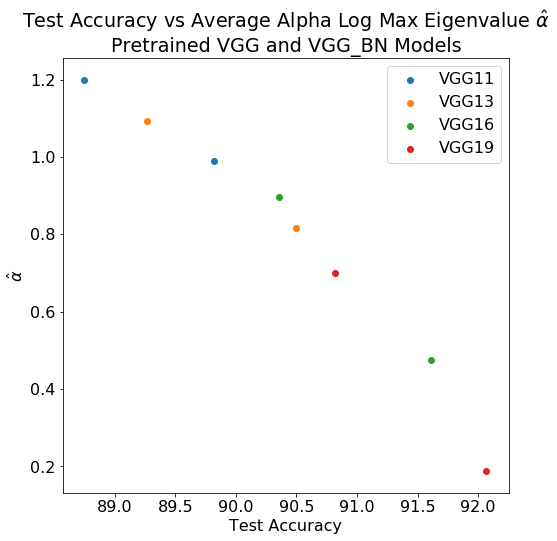

In [25]:
# Alpha Weighted using WeightWatcher

plt.rcParams['figure.figsize'] = [8,8]


for mf in [df_vgg11, df_vgg13, df_vgg16, df_vgg19]:
#for mf in [df_vgg11, df_vgg13]:
    x = mf['acc5'].values
    y = mf['avg_w_alphas'].values
    label = mf['legend'].values[0]
    plt.scatter(x,y,label=label)

plt.legend()
plt.title(r"Test Accuracy vs Average Alpha Log Max Eigenvalue $\hat{\alpha}$"+"\nPretrained VGG and VGG_BN Models")
plt.xlabel(r"Test Accuracy")
plt.ylabel(r"$\hat{\alpha}$")
#plt.savefig("img/vgg-w_alphas.png")

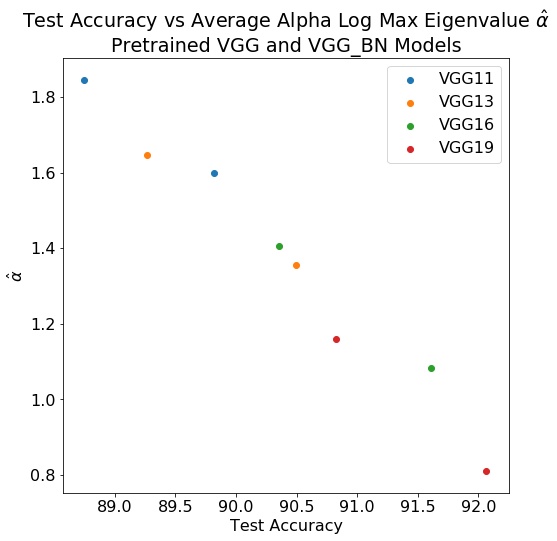

In [63]:
# Alpha Weighted (original notebook)

plt.rcParams['figure.figsize'] = [8,8]


for mf in [df_vgg11, df_vgg13, df_vgg16, df_vgg19]:
#for mf in [df_vgg11, df_vgg13]:
    x = mf['acc5'].values
    y = mf['avg_w_alphas'].values
    label = mf['legend'].values[0]
    plt.scatter(x,y,label=label)

plt.legend()
plt.title(r"Test Accuracy vs Average Alpha Log Max Eigenvalue $\hat{\alpha}$"+"\nPretrained VGG and VGG_BN Models")
plt.xlabel(r"Test Accuracy")
plt.ylabel(r"$\hat{\alpha}$")
#plt.savefig("img/vgg-w_alphas.png")

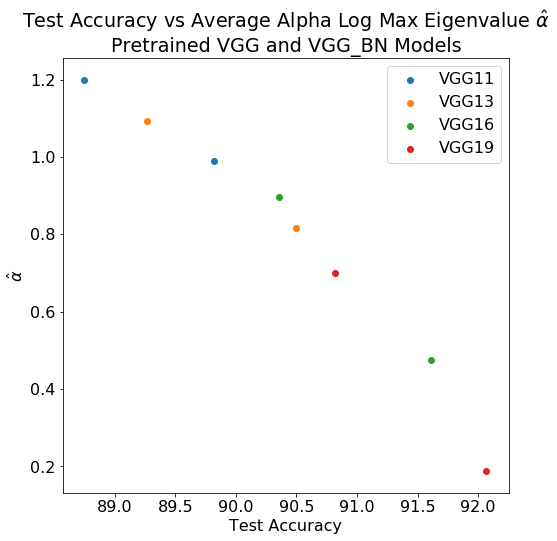

In [26]:
# Alpha Weighted compound (WeightWatcher)

plt.rcParams['figure.figsize'] = [8,8]


for mf in [df_vgg11, df_vgg13, df_vgg16, df_vgg19]:
#for mf in [df_vgg11, df_vgg13]:
    x = mf['acc5'].values
    y = mf['alpha_weighted_compound'].values
    label = mf['legend'].values[0]
    plt.scatter(x,y,label=label)

plt.legend()
plt.title(r"Test Accuracy vs Average Alpha Log Max Eigenvalue $\hat{\alpha}$"+"\nPretrained VGG and VGG_BN Models")
plt.xlabel(r"Test Accuracy")
plt.ylabel(r"$\hat{\alpha}$")
#plt.savefig("img/vgg-w_alphas.png")

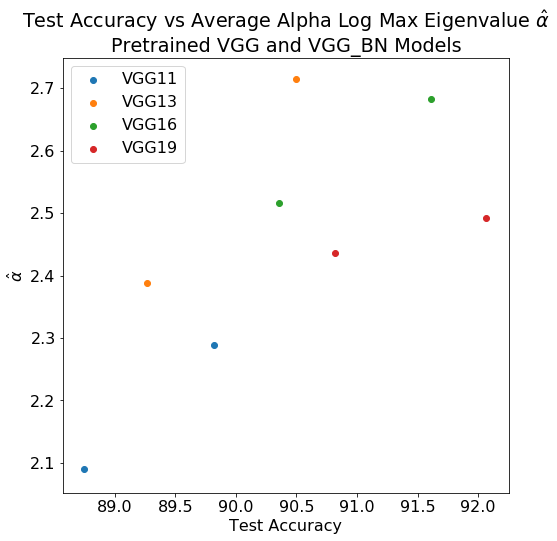

In [27]:
# Alpha (WeightWatcher)

plt.rcParams['figure.figsize'] = [8,8]


for mf in [df_vgg11, df_vgg13, df_vgg16, df_vgg19]:
#for mf in [df_vgg11, df_vgg13]:
    x = mf['acc5'].values
    y = mf['alpha'].values
    label = mf['legend'].values[0]
    plt.scatter(x,y,label=label)

plt.legend()
plt.title(r"Test Accuracy vs Average Alpha Log Max Eigenvalue $\hat{\alpha}$"+"\nPretrained VGG and VGG_BN Models")
plt.xlabel(r"Test Accuracy")
plt.ylabel(r"$\hat{\alpha}$")
#plt.savefig("img/vgg-w_alphas.png")

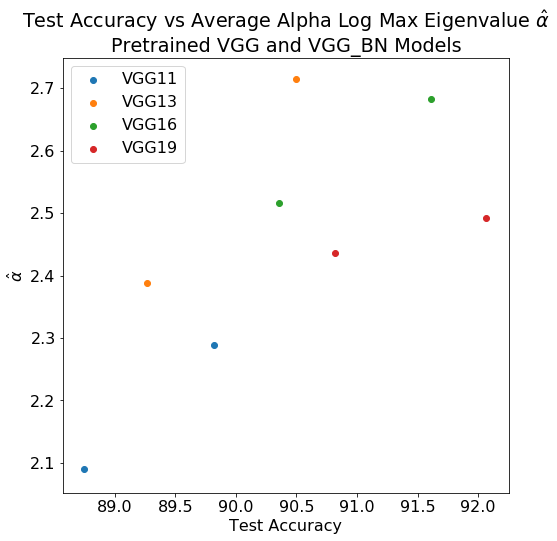

In [28]:
# Alpha compound (WeightWatcher)

plt.rcParams['figure.figsize'] = [8,8]


for mf in [df_vgg11, df_vgg13, df_vgg16, df_vgg19]:
#for mf in [df_vgg11, df_vgg13]:
    x = mf['acc5'].values
    y = mf['alpha_compound'].values
    label = mf['legend'].values[0]
    plt.scatter(x,y,label=label)

plt.legend()
plt.title(r"Test Accuracy vs Average Alpha Log Max Eigenvalue $\hat{\alpha}$"+"\nPretrained VGG and VGG_BN Models")
plt.xlabel(r"Test Accuracy")
plt.ylabel(r"$\hat{\alpha}$")
#plt.savefig("img/vgg-w_alphas.png")

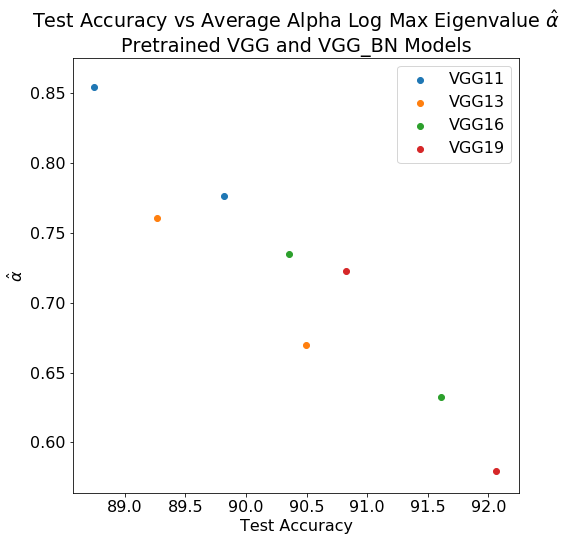

In [29]:
# Lognorm (WeightWatcher)

plt.rcParams['figure.figsize'] = [8,8]


for mf in [df_vgg11, df_vgg13, df_vgg16, df_vgg19]:
#for mf in [df_vgg11, df_vgg13]:
    x = mf['acc5'].values
    y = mf['lognorm'].values
    label = mf['legend'].values[0]
    plt.scatter(x,y,label=label)

plt.legend()
plt.title(r"Test Accuracy vs Average Alpha Log Max Eigenvalue $\hat{\alpha}$"+"\nPretrained VGG and VGG_BN Models")
plt.xlabel(r"Test Accuracy")
plt.ylabel(r"$\hat{\alpha}$")
#plt.savefig("img/vgg-w_alphas.png")

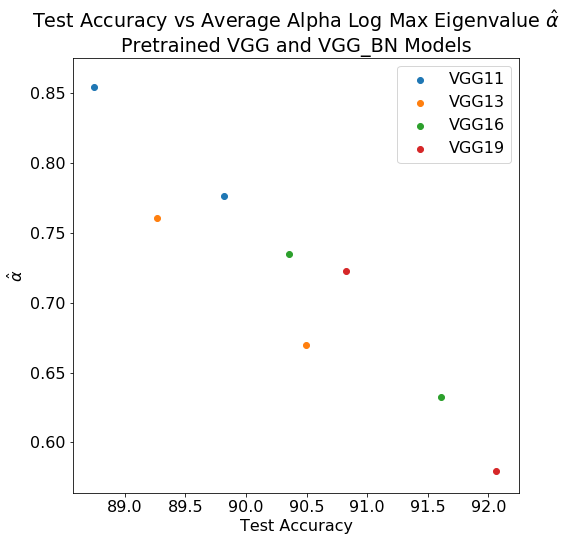

In [30]:
# Lognorm compound (WeightWatcher)

plt.rcParams['figure.figsize'] = [8,8]


for mf in [df_vgg11, df_vgg13, df_vgg16, df_vgg19]:
#for mf in [df_vgg11, df_vgg13]:
    x = mf['acc5'].values
    y = mf['lognorm_compound'].values
    label = mf['legend'].values[0]
    plt.scatter(x,y,label=label)

plt.legend()
plt.title(r"Test Accuracy vs Average Alpha Log Max Eigenvalue $\hat{\alpha}$"+"\nPretrained VGG and VGG_BN Models")
plt.xlabel(r"Test Accuracy")
plt.ylabel(r"$\hat{\alpha}$")
#plt.savefig("img/vgg-w_alphas.png")

In [31]:
df[df['modelname']=='resnet101']

,model,platform,acc1,acc5,modelname,avg_w_alphas,num_layers,alpha_weighted_compound,alpha,alpha_compound,lognorm,lognorm_compound
35,ResNet101,Pytorch,77.438,93.672,resnet101,-0.614044,1,0.087516,2.534792,2.943638,0.430459,0.622483


### ResNet

Only exception is InceptionResNetv2

[89.274] [0.39066619]
[91.456] [-0.42858589]
[92.98] [0.03924751]
[93.672] [-0.6140441]
[94.11] [-0.80216393]


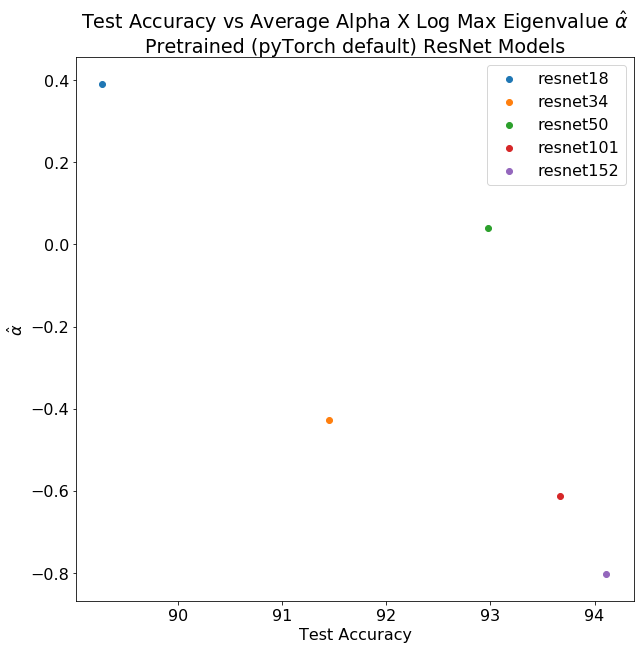

In [32]:
# WeightWatcher

plt.rcParams['figure.figsize'] = [10,10]

x, y = [], []

modelnames = ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152']

for name in modelnames:
    if 'resnet' in name:
        mf = df[df.modelname==name]
        x = mf['acc5'].values
        y = mf['avg_w_alphas'].values
        print(x,y)

        if np.abs(y) > 0:
            plt.scatter(x,y, label=name)
        
plt.title(r"Test Accuracy vs Average Alpha X Log Max Eigenvalue $\hat{\alpha}$"+"\nPretrained (pyTorch default) ResNet Models")
plt.xlabel(r"Test Accuracy")
plt.ylabel(r"$\hat{\alpha}$")
plt.legend()
#plt.savefig("img/resnet-pytorch-w_alphas.png")

[89.274] [0.61067626]
[91.456] [-0.39365554]
[92.98] [0.1403913]
[93.672] [-0.61647061]
[94.11] [-0.78980838]


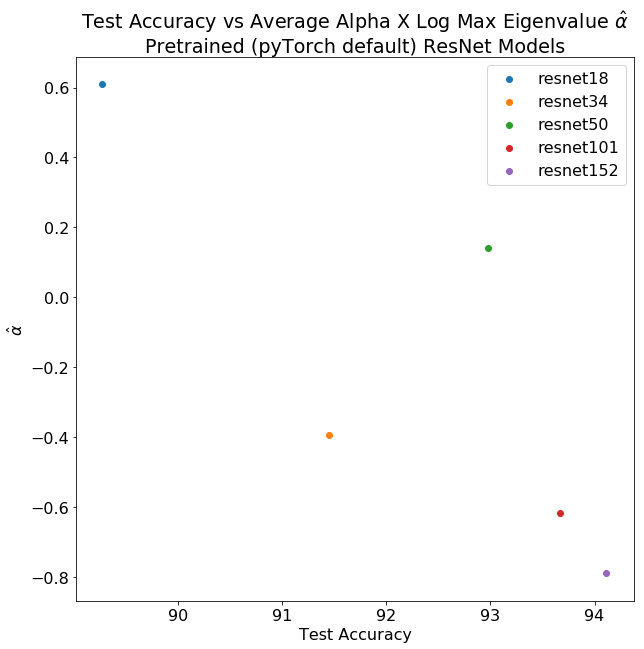

In [65]:
# Original notebook

plt.rcParams['figure.figsize'] = [10,10]

x, y = [], []

modelnames = ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152']

for name in modelnames:
    if 'resnet' in name:
        mf = df[df.modelname==name]
        x = mf['acc5'].values
        y = mf['avg_w_alphas'].values
        print(x,y)

        if np.abs(y) > 0:
            plt.scatter(x,y, label=name)
        
plt.title(r"Test Accuracy vs Average Alpha X Log Max Eigenvalue $\hat{\alpha}$"+"\nPretrained (pyTorch default) ResNet Models")
plt.xlabel(r"Test Accuracy")
plt.ylabel(r"$\hat{\alpha}$")
plt.legend()
#plt.savefig("img/resnet-pytorch-w_alphas.png")

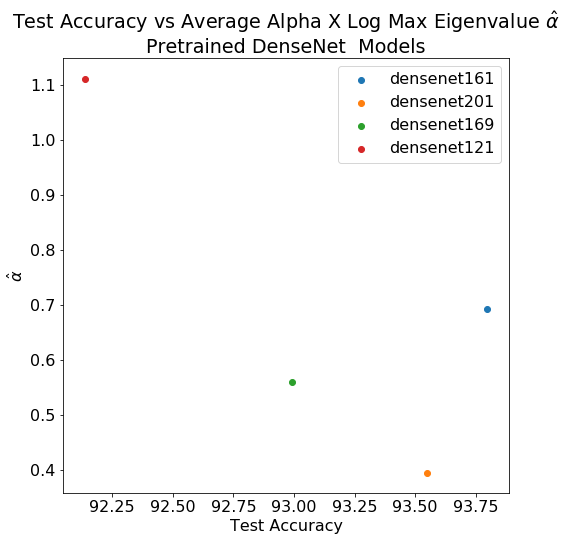

In [33]:
# Weightwatcher

plt.rcParams['figure.figsize'] = [8,8]

x, y = [], []

for name in df.modelname: 
    if 'densenet' in name and 'resnet' not in name:
        #print(name)
        mf = df[df.modelname==name]
        x = mf['acc5'].values
        y = mf['avg_w_alphas'].values
        if np.abs(y) > 0:
            plt.scatter(x,y, label=name)
        
plt.title(r"Test Accuracy vs Average Alpha X Log Max Eigenvalue $\hat{\alpha}$"+"\nPretrained DenseNet  Models")
plt.xlabel(r"Test Accuracy")
plt.ylabel(r"$\hat{\alpha}$")
plt.legend()
#plt.savefig("img/densenet-pytorch-w_alphas.png")

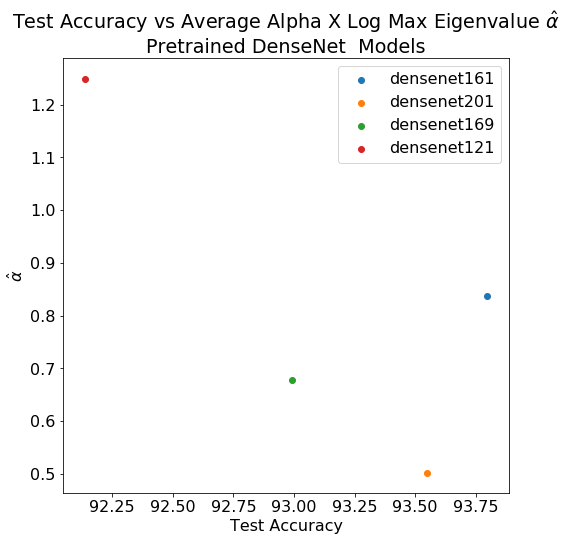

In [66]:
# Original notebook

plt.rcParams['figure.figsize'] = [8,8]

x, y = [], []

for name in df.modelname: 
    if 'densenet' in name and 'resnet' not in name:
        #print(name)
        mf = df[df.modelname==name]
        x = mf['acc5'].values
        y = mf['avg_w_alphas'].values
        if np.abs(y) > 0:
            plt.scatter(x,y, label=name)
        
plt.title(r"Test Accuracy vs Average Alpha X Log Max Eigenvalue $\hat{\alpha}$"+"\nPretrained DenseNet  Models")
plt.xlabel(r"Test Accuracy")
plt.ylabel(r"$\hat{\alpha}$")
plt.legend()
#plt.savefig("img/densenet-pytorch-w_alphas.png")

### ResNeXt, SqueezeNet

squeezenet1_0
squeezenet1_1


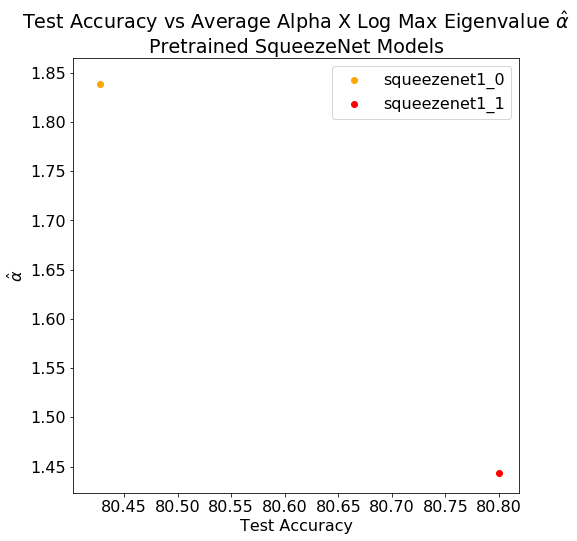

In [34]:
# Weightwatcher

for mf in [df_squeezenet]:
    for ix in [1,0]:
        x = mf['acc5'].values[ix]
        y = mf['avg_w_alphas'].values[ix]
        label = mf.modelname.values[ix] # mf['legend'].values[ix]
        print(label)
        color =  'red' if ix==0  else 'orange' 
        plt.scatter(x,y,label=label, color=color)
        
plt.legend()
plt.title(r"Test Accuracy vs Average Alpha X Log Max Eigenvalue $\hat{\alpha}$"+"\nPretrained SqueezeNet Models")
plt.xlabel(r"Test Accuracy")
plt.ylabel(r"$\hat{\alpha}$")
#plt.savefig("img/squeezenet-pytorch-w_alphas.png")

squeezenet1_0
squeezenet1_1


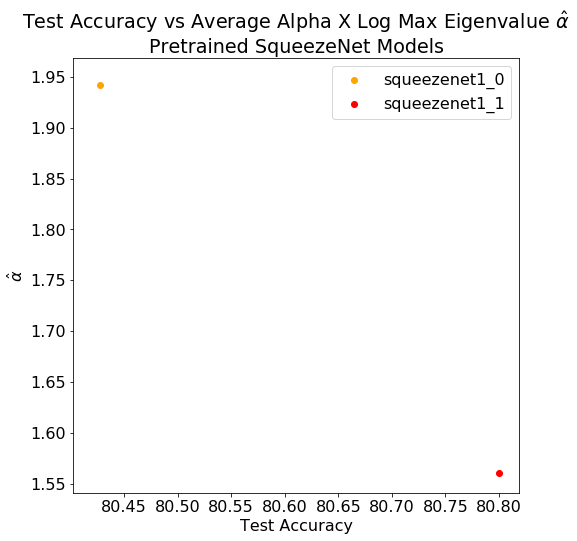

In [67]:
# Original notebook

for mf in [df_squeezenet]:
    for ix in [1,0]:
        x = mf['acc5'].values[ix]
        y = mf['avg_w_alphas'].values[ix]
        label = mf.modelname.values[ix] # mf['legend'].values[ix]
        print(label)
        color =  'red' if ix==0  else 'orange' 
        plt.scatter(x,y,label=label, color=color)
        
plt.legend()
plt.title(r"Test Accuracy vs Average Alpha X Log Max Eigenvalue $\hat{\alpha}$"+"\nPretrained SqueezeNet Models")
plt.xlabel(r"Test Accuracy")
plt.ylabel(r"$\hat{\alpha}$")
#plt.savefig("img/squeezenet-pytorch-w_alphas.png")